In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import numpy as np
import pandas as pd
import math
import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error



pd.set_option('display.max_columns',500)
pd.set_option('display.max_row',200)

font_path='C:/Windows/Fonts/malgunbd.ttf'
font_name = fm.FontProperties(fname=font_path,size=10).get_name()
plt.rc('font',family=font_name)
plt.rcParams['axes.unicode_minus'] = False

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")        

In [2]:
df_main = pd.read_excel('■ 일반입찰(종심제,종평제) 현황(16년~20년).jj', skiprows=3)

In [3]:
df_main[df_main['입찰\n방법']=='종심제'].shape

(226, 22)

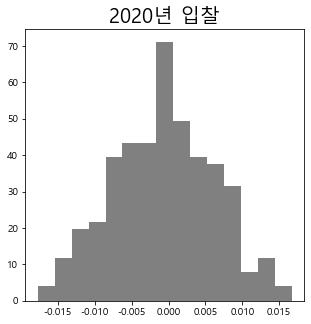

In [4]:
fig = plt.figure(figsize=(5,5))
df_main_ = df_main[df_main['입찰\n방법']=='종심제']
tmp = df_main_[(df_main_['예가산출율']>-0.02)&(df_main_['예가산출율']<0.02)]['예가산출율'].tolist()
plt.hist(tmp, bins=15, density=True, histtype='stepfilled', color='grey')
plt.title('2020년 입찰', fontsize=20)
plt.show()

In [4]:
df1 = pd.ExcelFile('입찰결과(2017년).jj')
df2 = pd.ExcelFile('입찰결과(2018년).jj')
df3 = pd.ExcelFile('입찰결과(2019년).jj')
df4 = pd.ExcelFile('입찰결과(2020년).jj')

In [139]:
df_project = []
for i in df1.sheet_names:
    a = df1.parse(i)
    project = a.iloc[6,2]
    df_project.append([i,2017,a.iloc[8,2],project])
for i in df2.sheet_names:
    a = df2.parse(i)
    project = a.iloc[6,2]
    df_project.append([i,2018,a.iloc[8,2],project])
for i in df3.sheet_names:
    a = df3.parse(i)
    project = a.iloc[6,2]
    df_project.append([i,2019,a.iloc[8,2],project])
for i in df4.sheet_names:
    a = df4.parse(i)
    project = a.iloc[6,2]
    df_project.append([i,2020,a.iloc[8,2],project])

In [140]:
df_project = pd.DataFrame(df_project, columns=['sheet_name','year','date','project_name'])

In [21]:
df_main.columns

Index(['순', '입찰년도', '입찰일시', '공종', '공사명', '수요처', '발주처', '가격심사\nA/B계수',
       '균형가격\n산정방법\n(20개초과)', '입찰\n참여\n여부', 'PQ\n통과사', '입찰\n방법', 'Unnamed: 12',
       '공고금액', '기초금액', '선정예가', '예가산출율', '낙찰사', 'Unnamed: 18', 'Unnamed: 19',
       'Unnamed: 20', '비  고'],
      dtype='object')

In [137]:
df_main_ = df_main[['입찰일시','공사명','공종','균형가격\n산정방법\n(20개초과)','낙찰사','Unnamed: 18']]
df_main_ = df_main_[~df_main_['공종'].isnull()]
df_main_['입찰일시'] = pd.to_datetime(df_main_['입찰일시'])
df_main_.rename(columns={'Unnamed: 18':'입찰금액'}, inplace=True)

In [8]:
df_project['datetime'] = df_project['date'].str.split('(', expand=True)[0]
df_project['datetime'] = pd.to_datetime(df_project['datetime'], format='%Y.%m.%d %H:%M')
df_project['date'] = df_project['datetime'].dt.date

In [9]:
df_project.head(2)

sheet_name  year        date                  project_name  \
0     진접선2공구  2017  2017-03-03  진접선(당고개~진접) 복선전철 제2공구 노반건설공사   
1    강진광주1공구  2017  2017-07-24  고속국도 제25호선 강진~광주간 건설공사(제1공구)   

             datetime  
0 2017-03-03 13:00:00  
1 2017-07-24 09:40:00

In [141]:
df_project_select = df_project.merge(df_main_, left_on='project_name', right_on='공사명',how='left')

In [142]:
df_project_select = df_project_select[~df_project_select['공사명'].isnull()]

In [143]:
df_project_select.reset_index(drop=True, inplace=True)

In [144]:
from tqdm import tqdm

In [14]:
def change(x):
    x = ['기초대비\n' if x == '기초대비' else x for x in x]
    x = ['기초대비\n' if x == '기초금액\n대비' else x for x in x]
    return x

In [109]:
dict_pct={}
dict_company={}
for p in tqdm(df1.sheet_names):
    a = df1.parse(p,skiprows=16)
    #a.columns = np.arange(len(a.columns))
    a.columns = change(a.columns.tolist())
    company,pct =[],[]
    i=0
    while True:
        if a.iloc[i,1] is np.nan:
            break
        company.append(a.iloc[i,1])
        pct.append(a.loc[i,'기초대비\n'])
        i+=1
    dict_pct[p] = pct
    dict_company[p] = company
for p in tqdm(df2.sheet_names):
    a = df2.parse(p,skiprows=16)
    #a.columns = np.arange(len(a.columns))
    a.columns = change(a.columns.tolist())
    company,pct =[],[]
    i=18
    while True:
        if a.iloc[i,1] is np.nan:
            break
        company.append(a.iloc[i,1])
        pct.append(a.loc[i,'기초대비\n'])
        i+=1
    dict_pct[p] = pct
    dict_company[p] = company    
for p in tqdm(df3.sheet_names):
    a = df3.parse(p,skiprows=16)
    #a.columns = np.arange(len(a.columns))
    a.columns = change(a.columns.tolist())
    company,pct =[],[]
    i=18
    while True:
        if a.iloc[i,1] is np.nan:
            break
        company.append(a.iloc[i,1])
        pct.append(a.loc[i,'기초대비\n'])
        i+=1
    dict_pct[p] = pct
    dict_company[p] = company    
for p in tqdm(df4.sheet_names):
    a = df4.parse(p,skiprows=16)
    #a.columns = np.arange(len(a.columns))
    a.columns = change(a.columns.tolist())
    company,pct =[],[]
    i=18
    while True:
        if a.iloc[i,1] is np.nan:
            break
        company.append(a.iloc[i,1])
        pct.append(a.loc[i,'기초대비\n'])
        i+=1
    dict_pct[p] = pct
    dict_company[p] = company    


100%|█████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 264.44it/s]


In [545]:
from matplotlib import gridspec
gs = gridspec.GridSpec(nrows=1, ncols=2, height_ratios=[1],width_ratios=[7,1])

In [382]:
len(set(df_project_select['공종']))

9

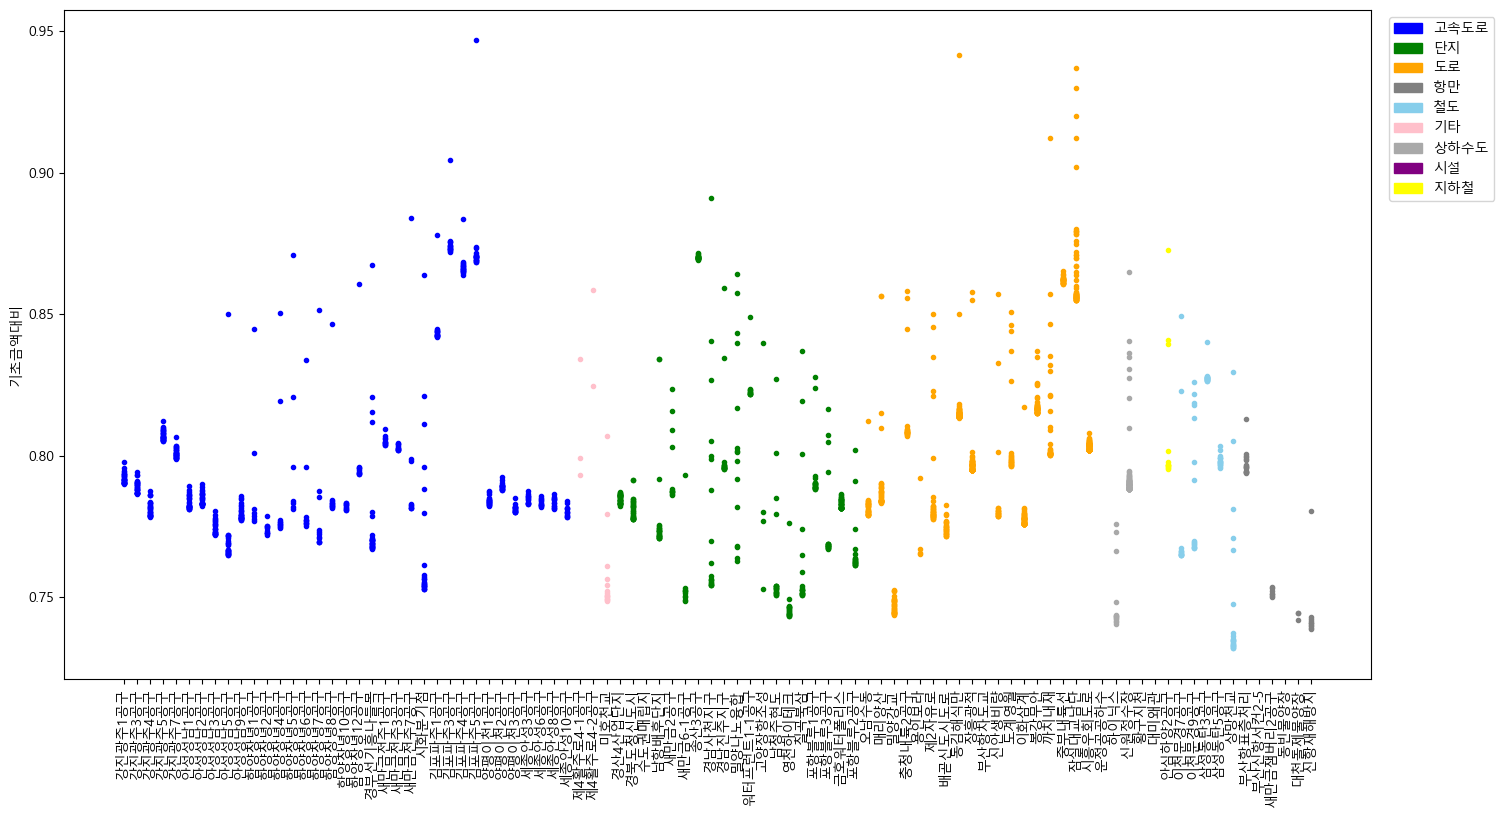

In [383]:
colors=['blue','green','orange','grey','skyblue','pink','darkgrey','purple','yellow']
color_dict={}
for i,v in enumerate(df_project_select['공종'].value_counts().index.tolist()):
    color_dict[v]=colors[i]
fig = plt.figure(figsize=(15,8.27), dpi=100)
for i,v in enumerate(df_project_select.sort_values(by=['공종','date']).index.tolist()):
    p = df_project_select.iloc[v,0]
    #y = df_project_select.iloc[v,1]
    cat = df_project_select.iloc[v,7]
    plt.scatter([i]*len(dict_pct[p]),dict_pct[p], color=color_dict[cat], marker='.')

plt.xticks(np.arange(len(df_project_select)),df_project_select.sort_values(by=['공종','date'])['sheet_name'].tolist(), rotation=90)
list_m=[]
for i in np.arange(len(colors)):
    list_m.append(mpatches.Patch(label=list(color_dict.keys())[i], color=colors[i]))
plt.legend(handles=list_m, bbox_to_anchor=(1.1, 1))
plt.ylabel('기초금액대비')
plt.tight_layout()
plt.savefig('img/1.입찰대비낙찰.jpg')
plt.show()


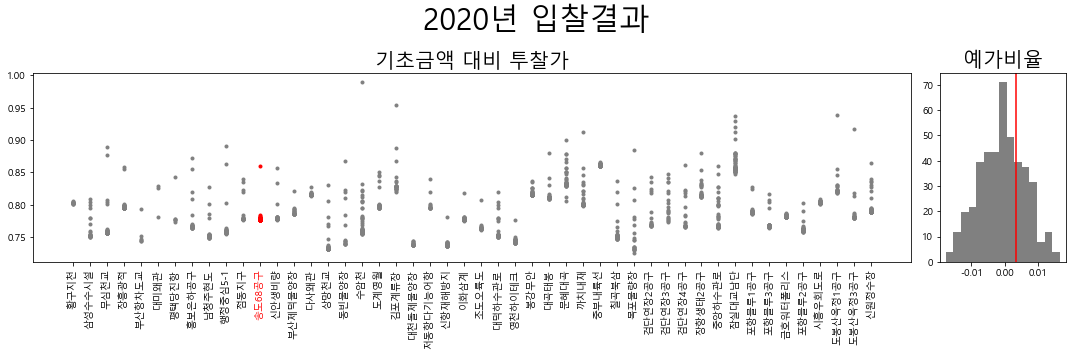

In [553]:
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(gs[0])
for i,p in enumerate(df.sheet_names):
    if i == 11:
        color='red'
    else:
        color='grey'
    ax1.scatter([i]*len(dict_pct[p]),dict_pct[p], color=color, marker='.')
plt.xticks(np.arange(len(df.sheet_names)),df.sheet_names, rotation=90)
tick_colors = ['black']*len(df.sheet_names)
tick_colors[11] = 'red'
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), tick_colors):
    ticklabel.set_color(tickcolor)
plt.title('기초금액 대비 투찰가',fontsize=20)
df_main_ = df_main[df_main['입찰\n방법']=='종심제']
tmp = df_main_[(df_main_['예가산출율']>-0.02)&(df_main_['예가산출율']<0.02)]['예가산출율'].tolist()
ax2 = plt.subplot(gs[1])
ax2.hist(tmp, bins=15, density=True, histtype='stepfilled', color='grey')
a = df.parse(df.sheet_names[11])
#a.iloc[-5:-1,8].tolist()
ax2.axvline(np.mean(a.iloc[-5:-1,8].tolist())-1, color='red')
plt.title('예가비율', fontsize=20)
plt.suptitle('2020년 입찰결과', fontsize=30)
plt.tight_layout()
plt.savefig('fig0.png', dpi=1000)
plt.show()

In [550]:
np.mean(a.iloc[-5:-1,8].tolist())

1.0033825005554153

In [164]:
a = df.parse(df.sheet_names[11])
a.columns = np.arange(len(a.columns))

In [555]:
project = a.iloc[6,2]
company = []
bid = []
score1, score2 = [],[]
i=18
while True:
    b = a.iloc[i,1]
    if b is np.nan:
        break
    company.append(b)
    bid.append(a.iloc[i,2])
    score1.append(a.iloc[i,5])
    score2.append(a.iloc[i,6])
    i += 1
gonggo = a.iloc[9,2]
gicho = a.iloc[10,2]
yega = a.iloc[11,2]
gyunga = a.iloc[12,2]

In [36]:
def get_pct(x):
    a = x.split('/')[0]
    b = x.split('/')[1]
    if '%' in a:
        a = float(a.replace('%',''))
        a /=100
    elif '개' in a:
        a = float(a.replace('개',''))
    if '%' in b:
        b = float(b.replace('%',''))
        b /=100
    elif '개' in b:
        b = float(b.replace('개',''))
    return a,b
def get_com(x, company):
    if x <1:
        return math.floor(len(company)*x)
    elif x>=1:
        return x

In [159]:
def convert_won(x):
    s = ''
    for i,v in enumerate(str(nakchalga)):
        if i % 3 == 0:
            s += ','
        s += v
    if s[0]==',':
        s = s[1:]
    return s+'원'

Timestamp('2017-07-24 00:00:00')

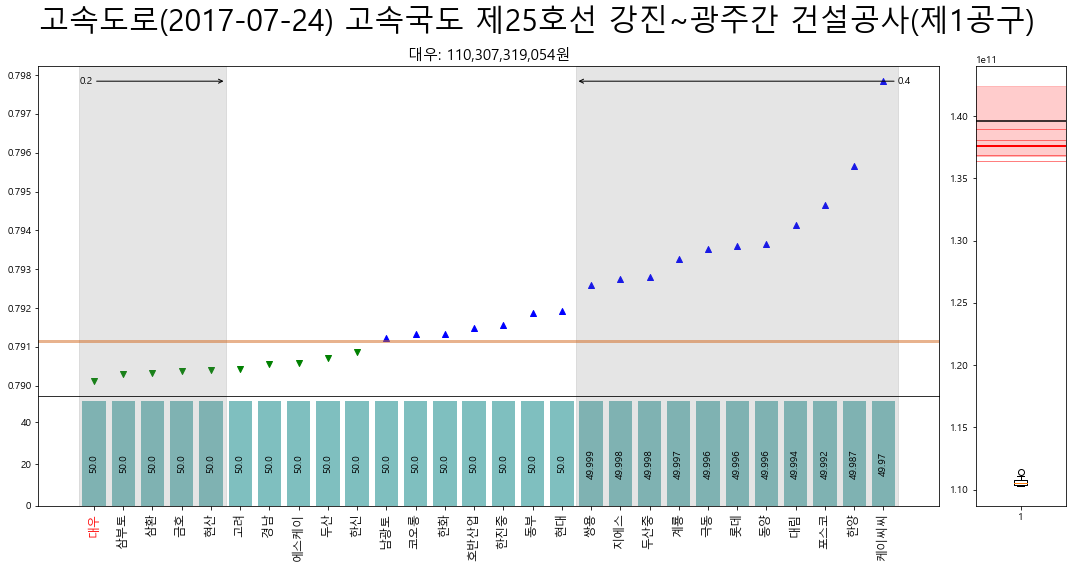

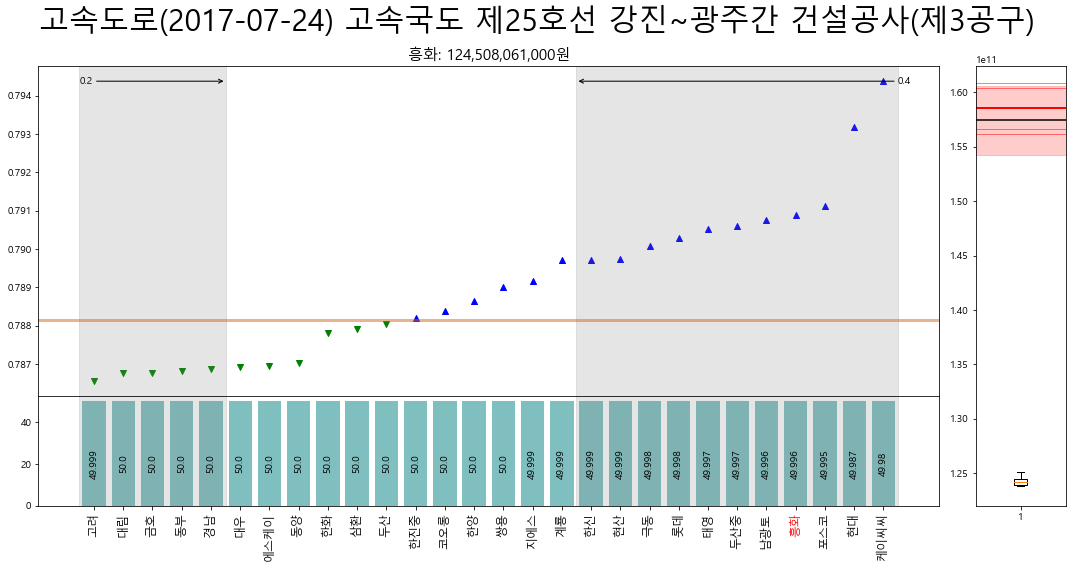

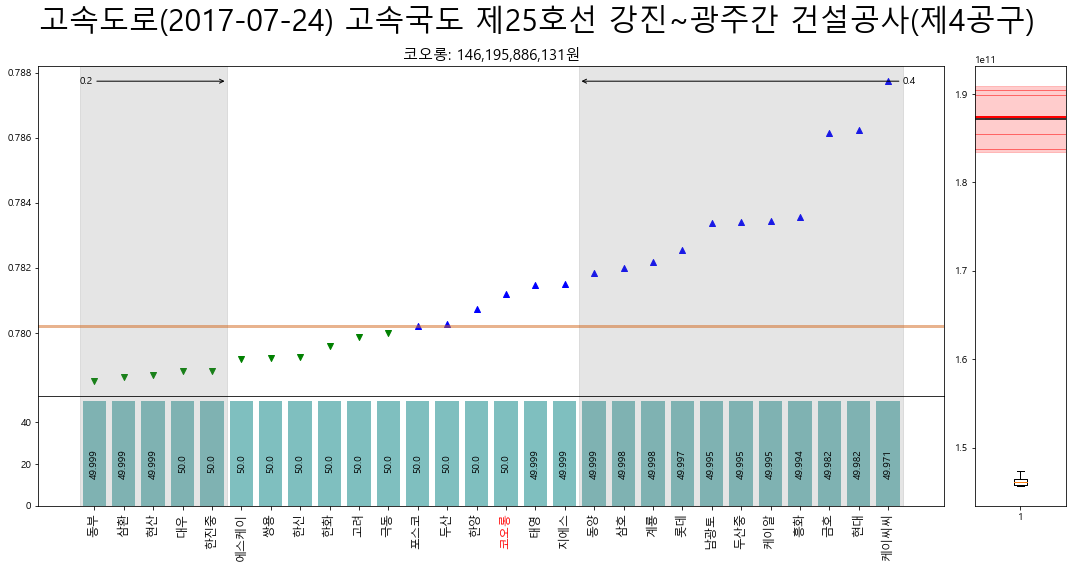

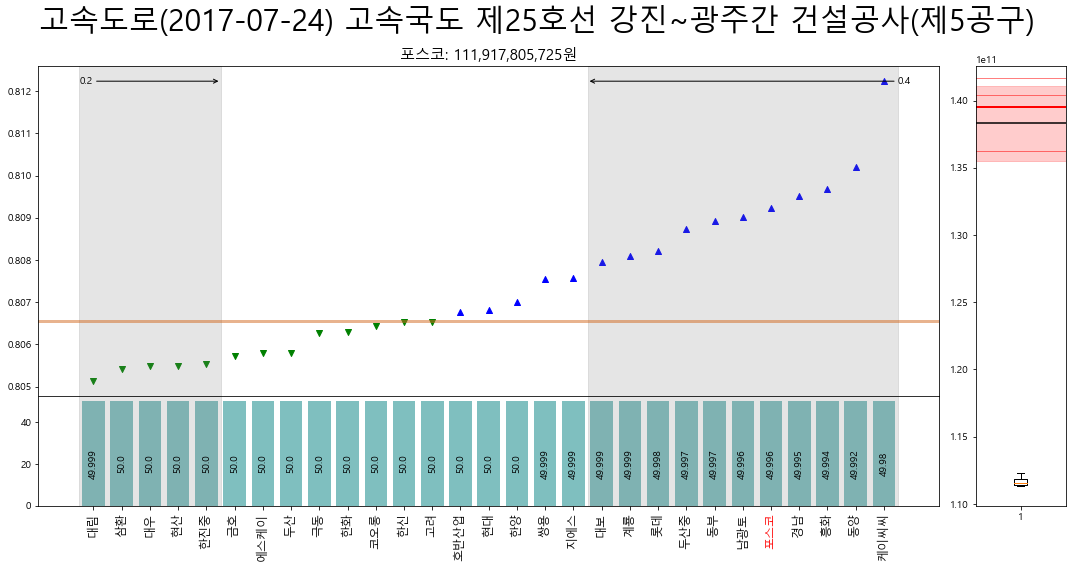

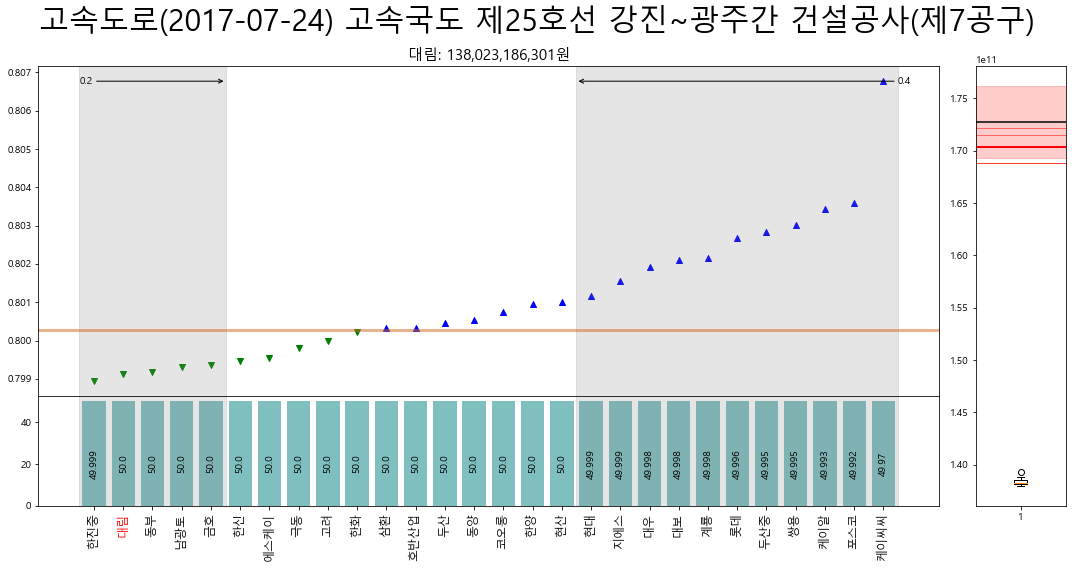

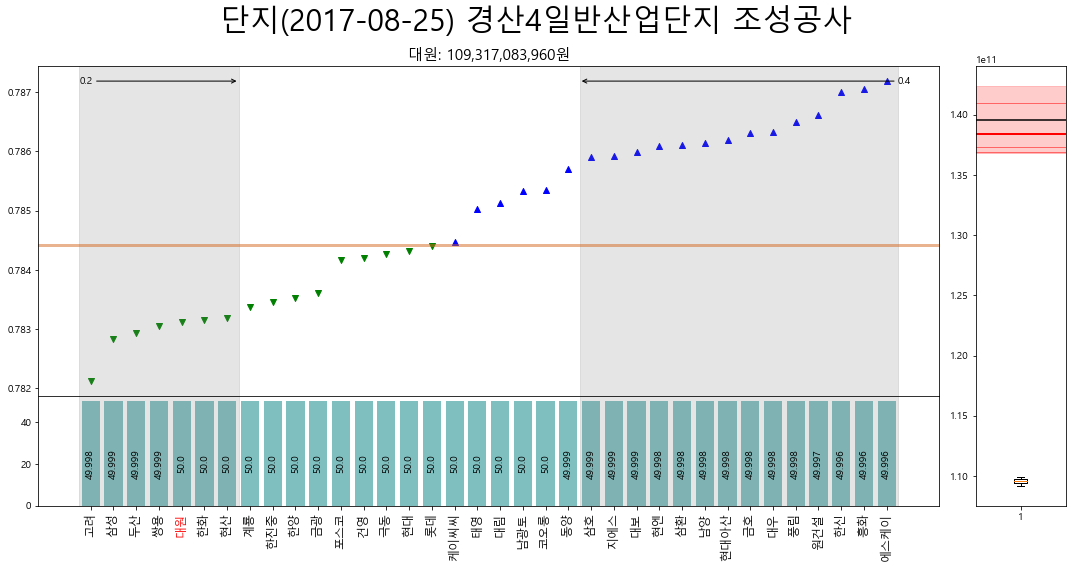

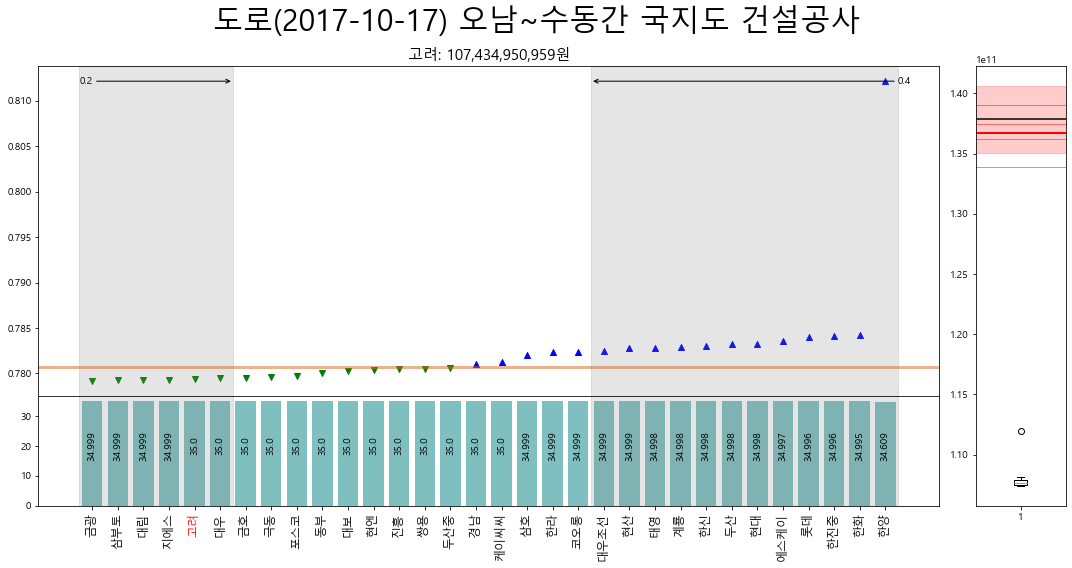

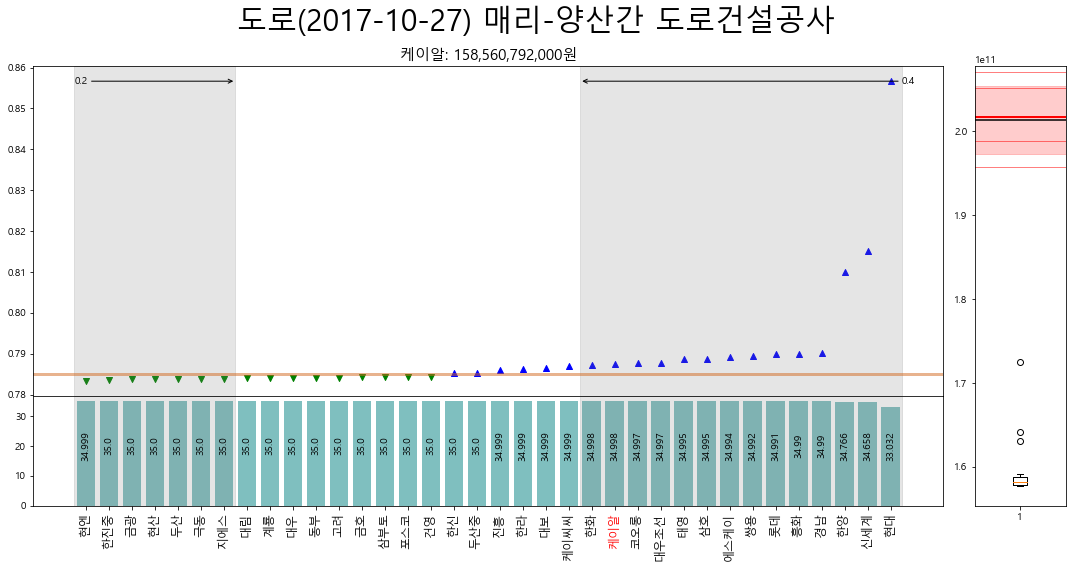

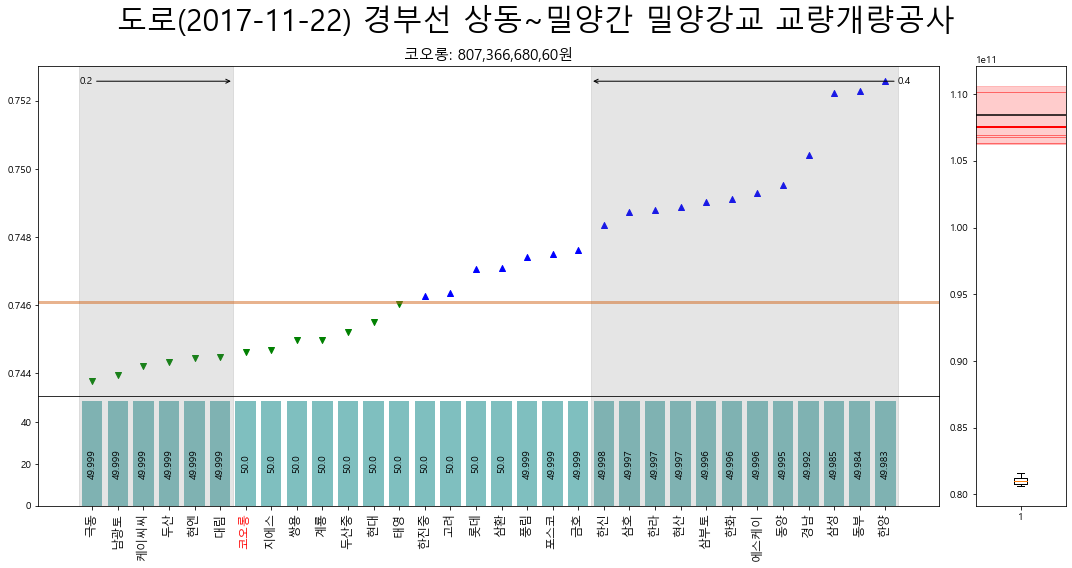

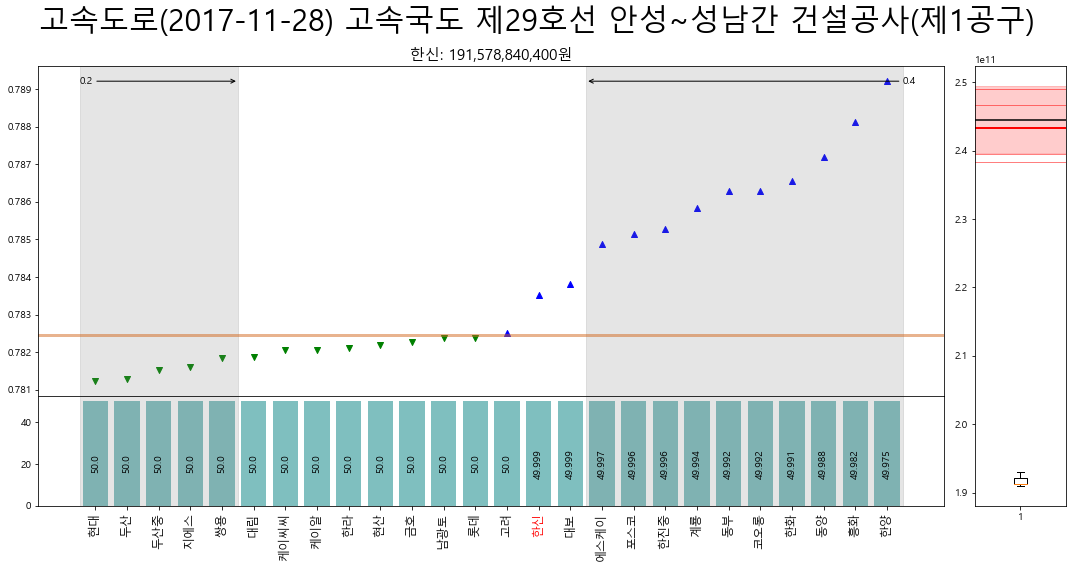

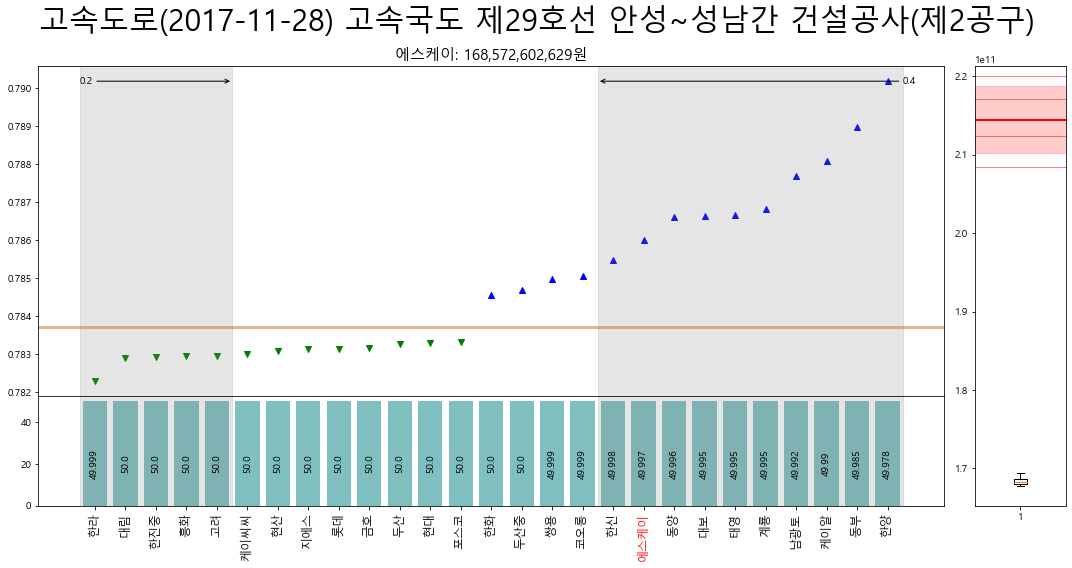

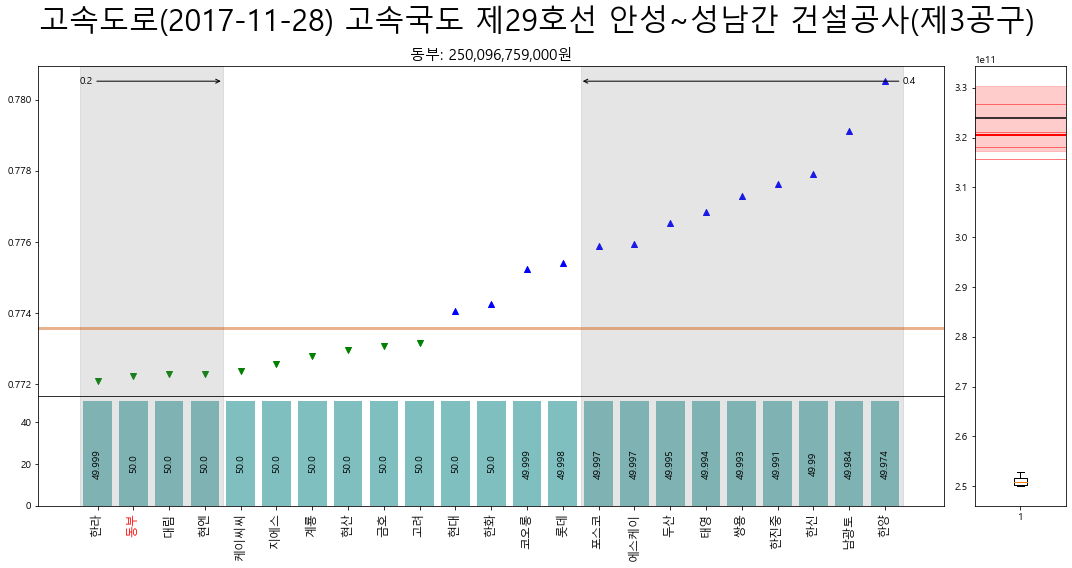

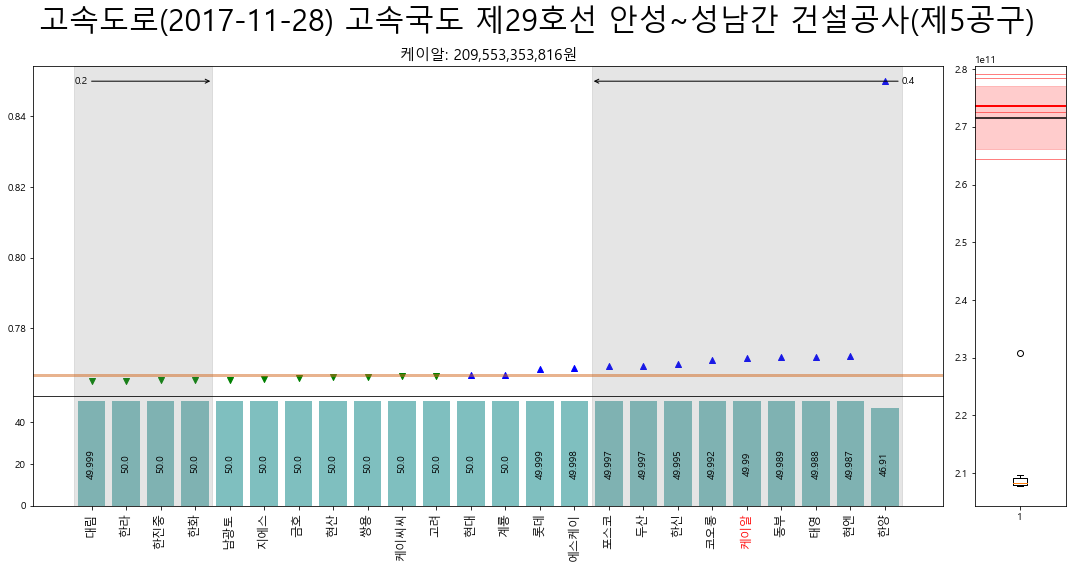

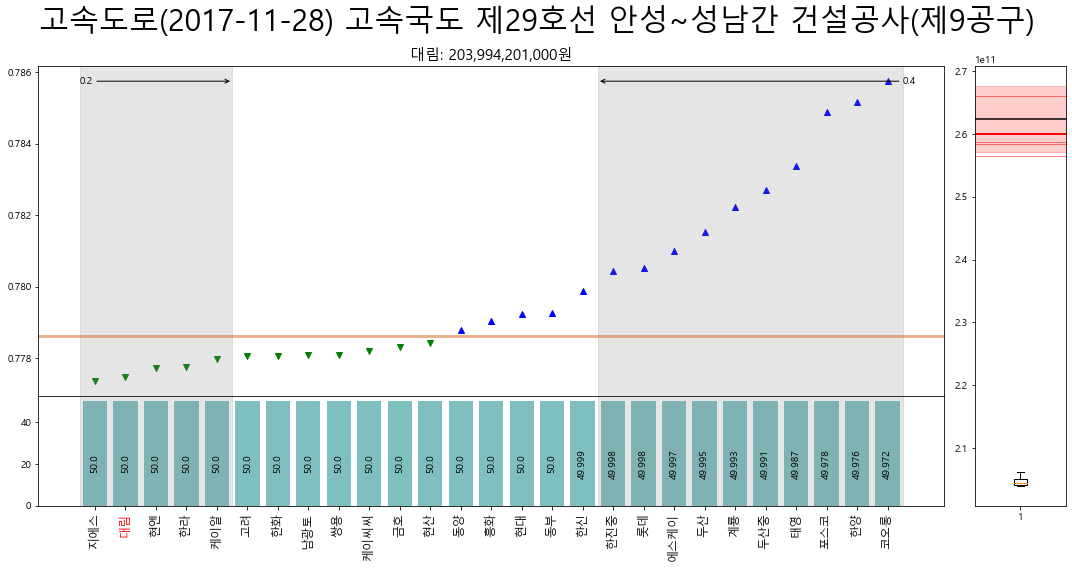

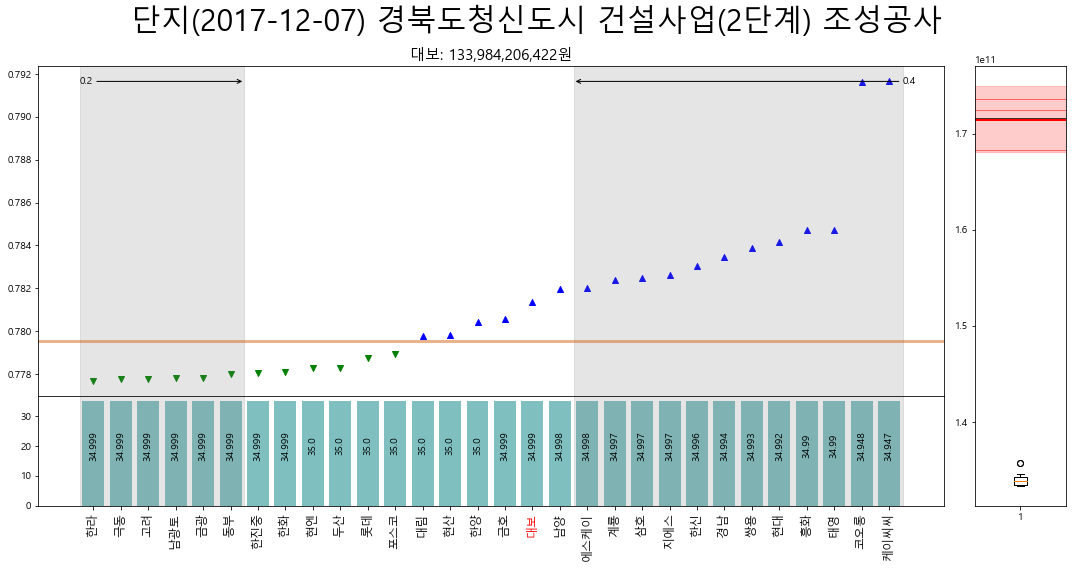

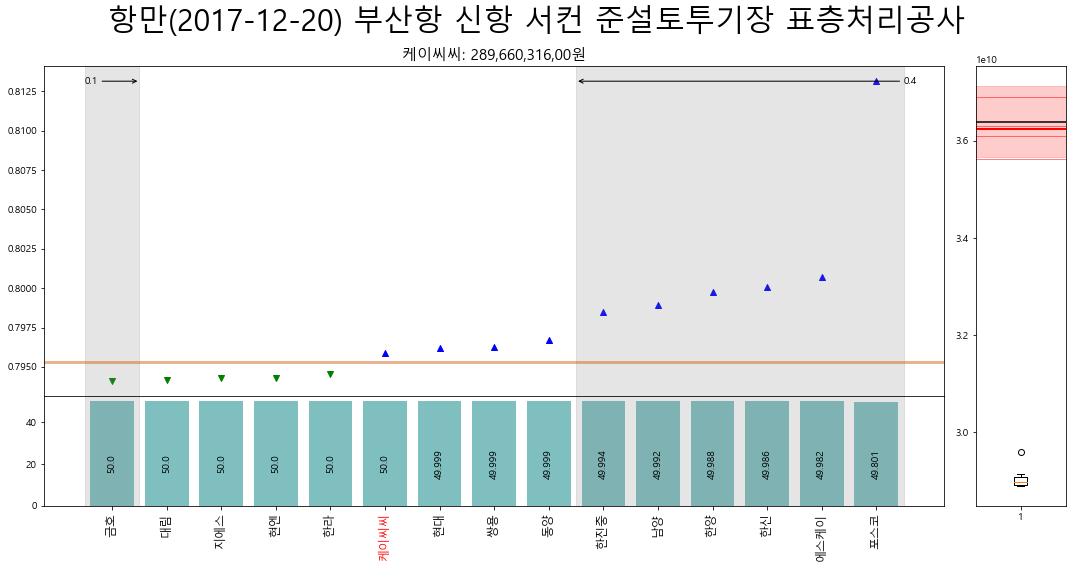

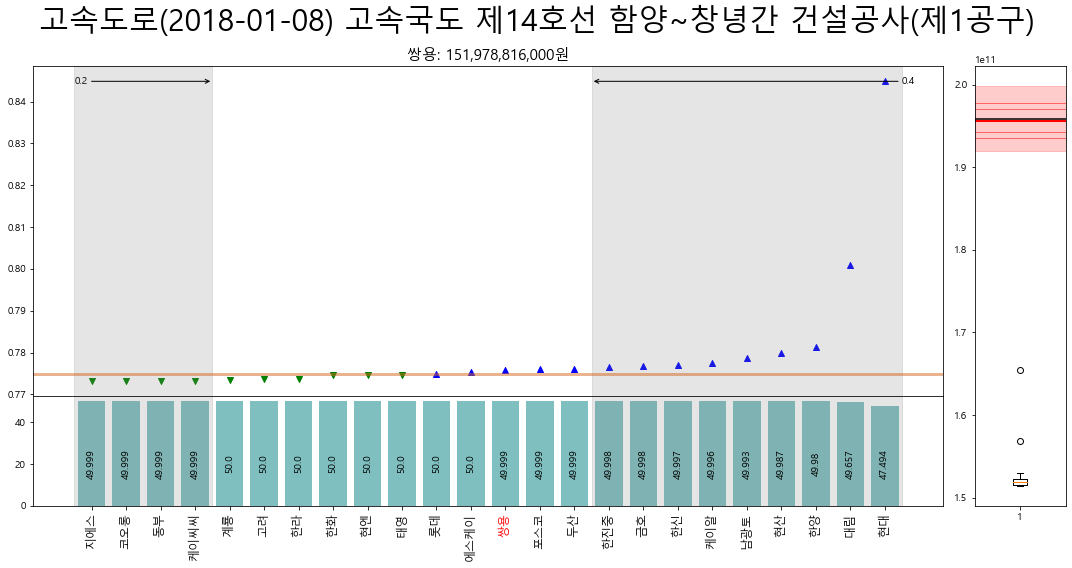

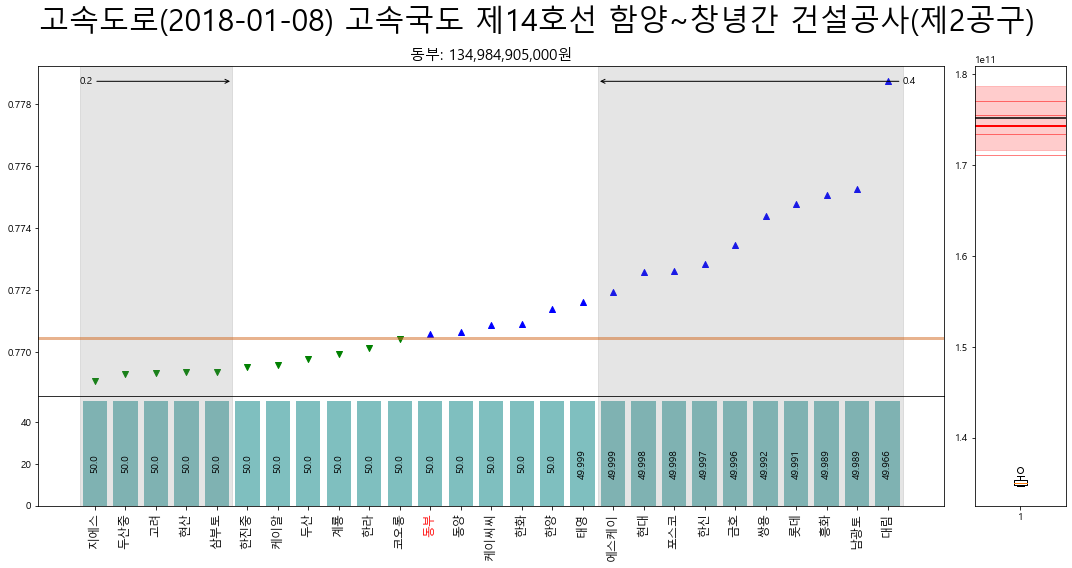

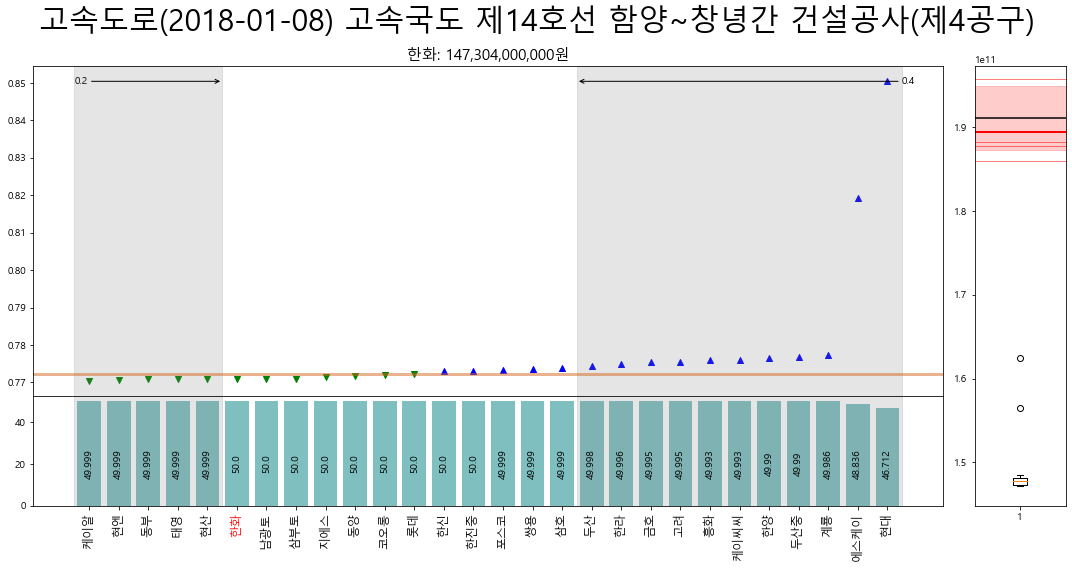

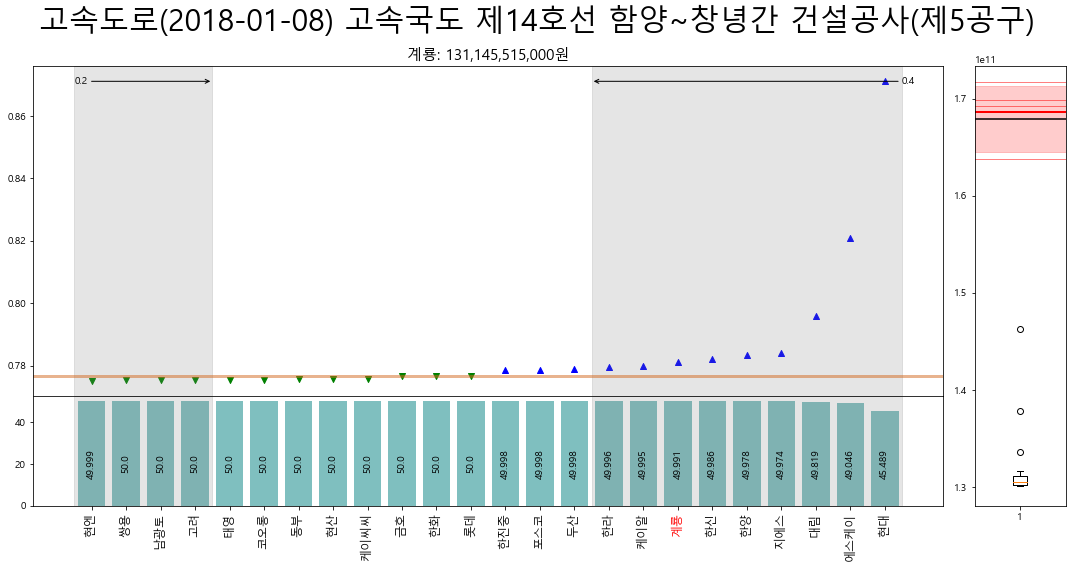

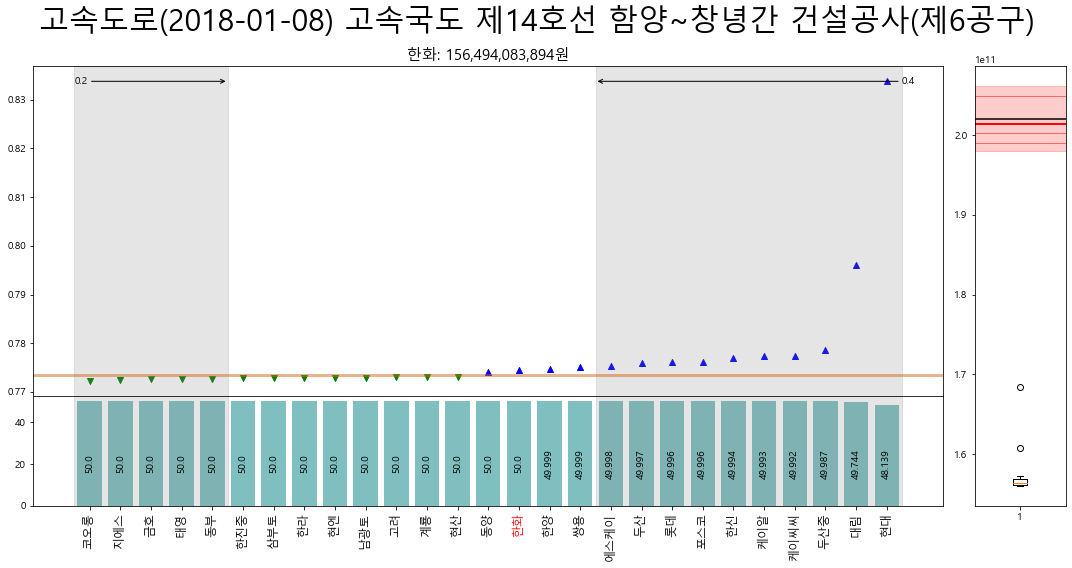

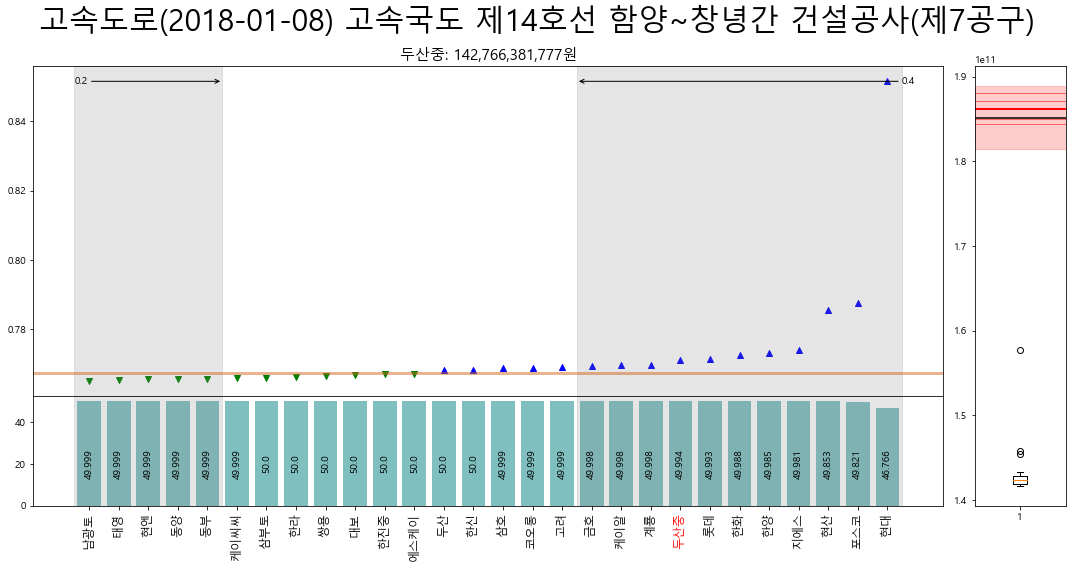

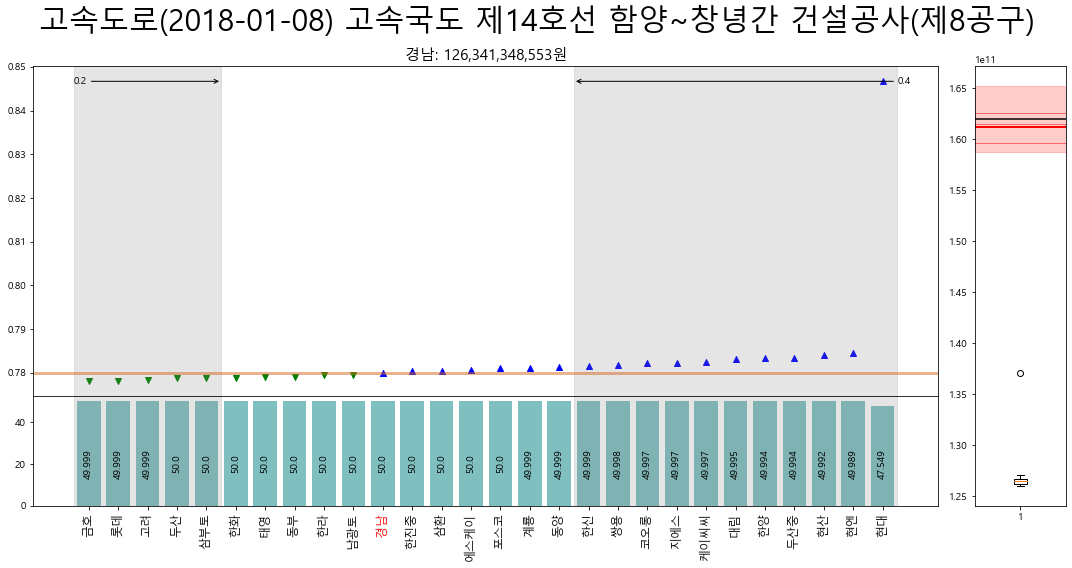

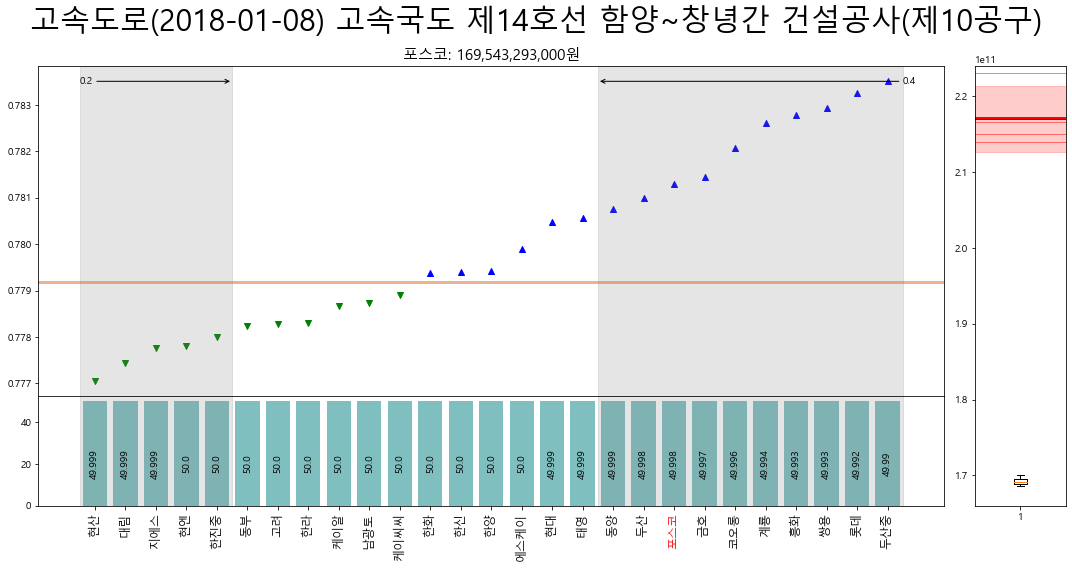

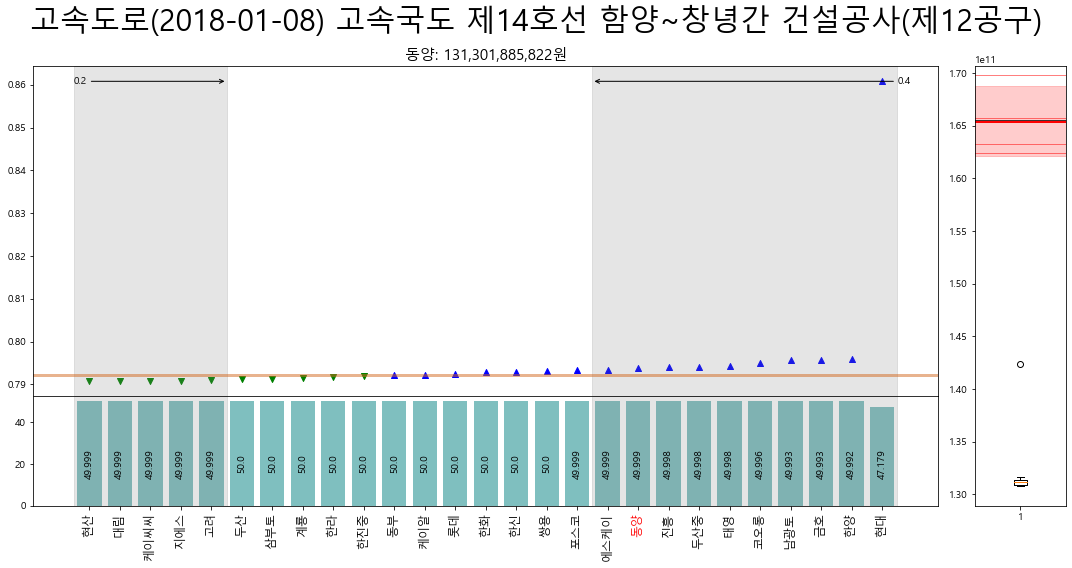

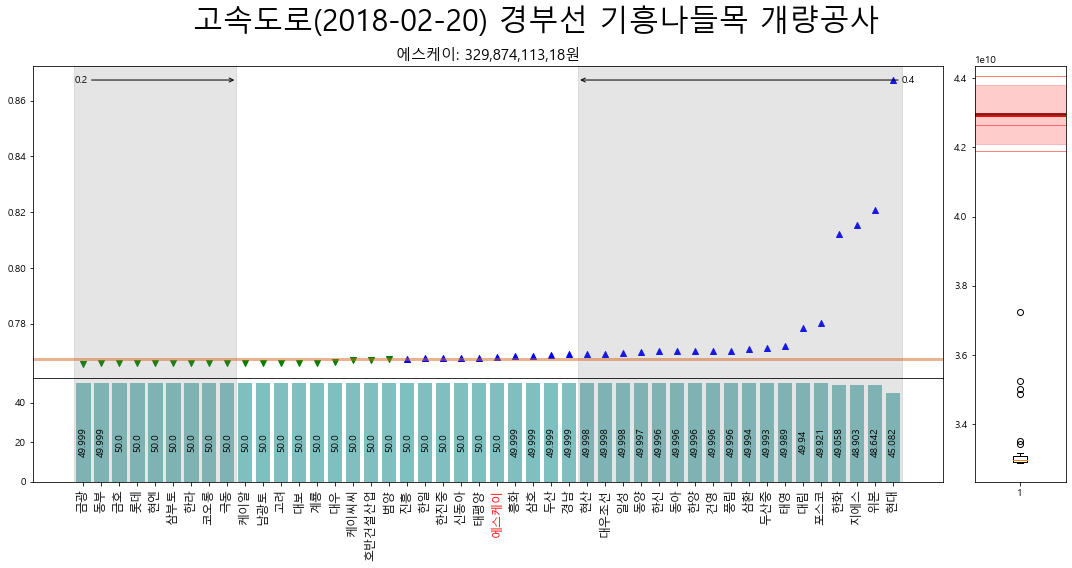

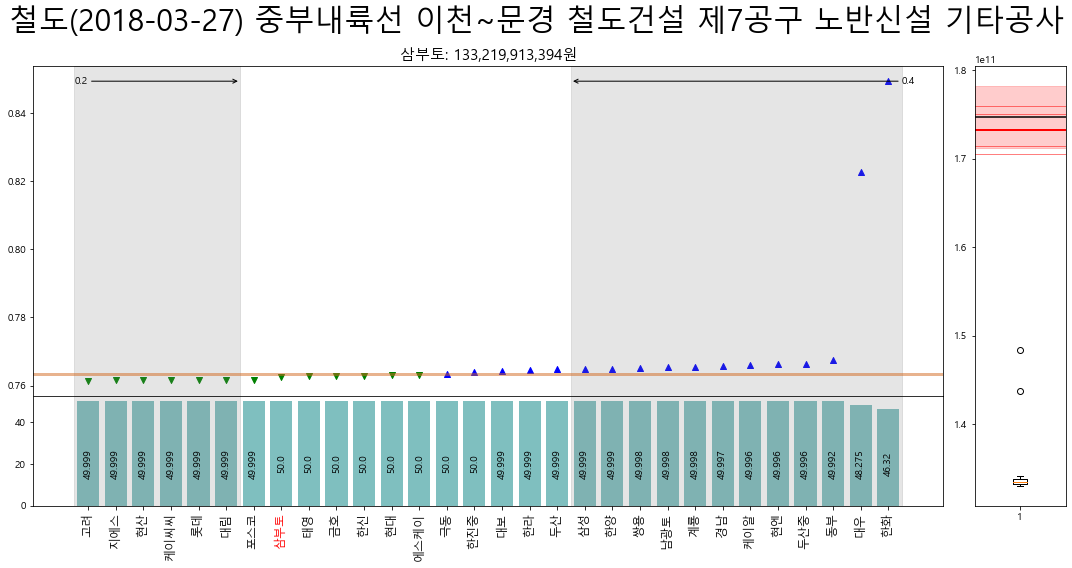

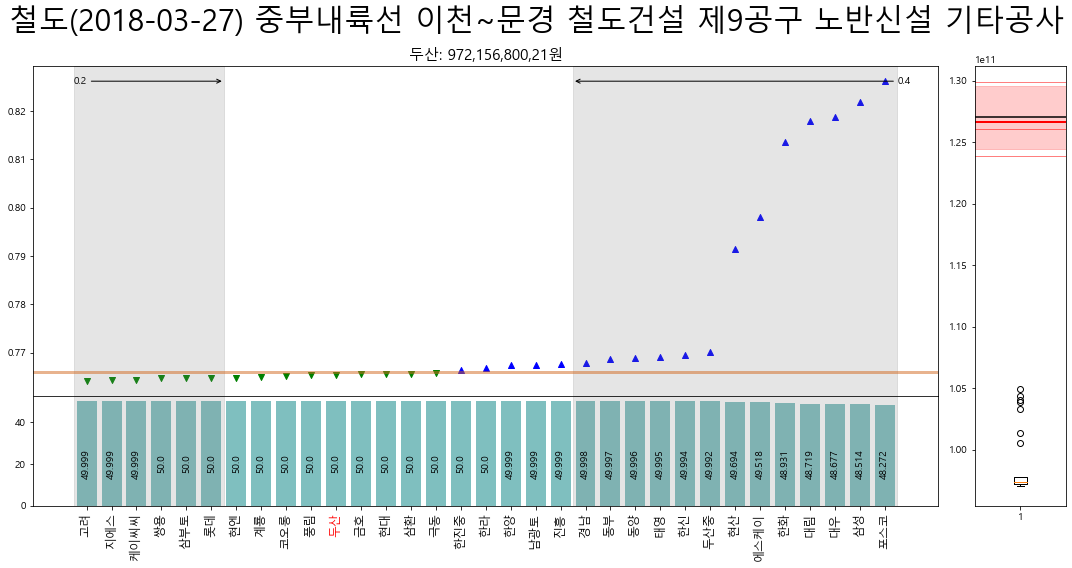

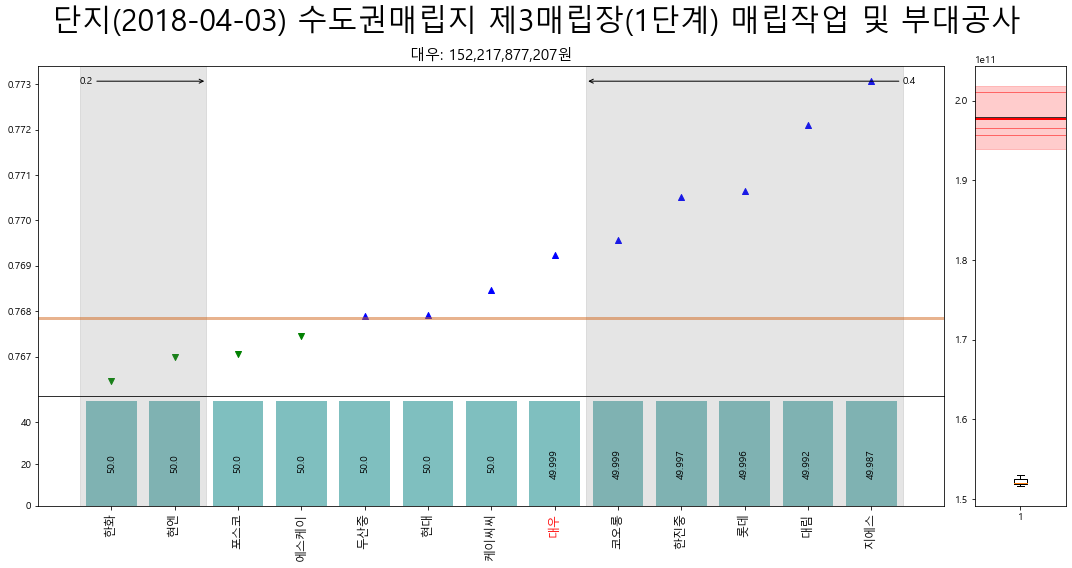

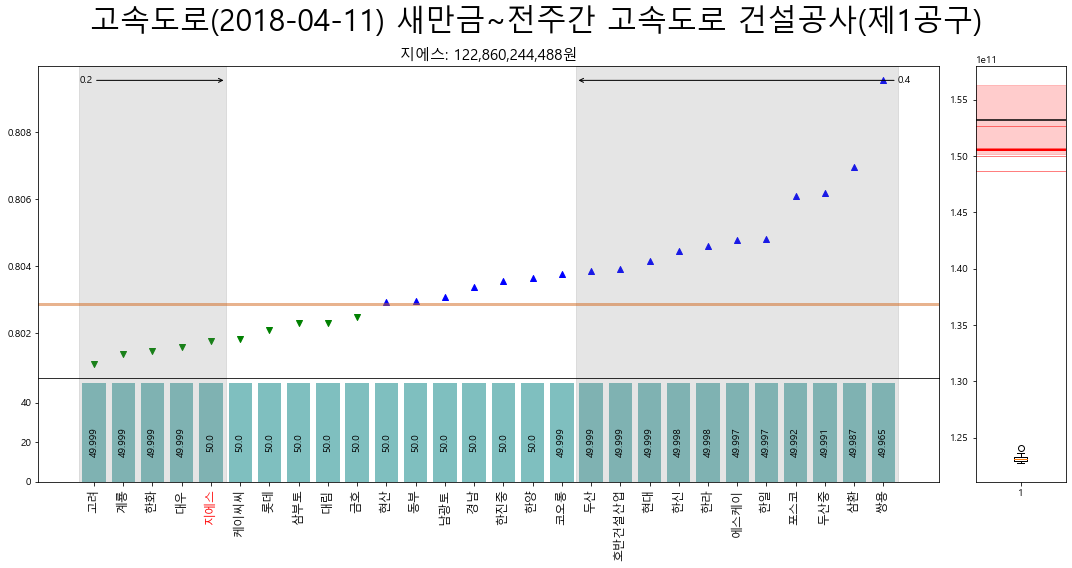

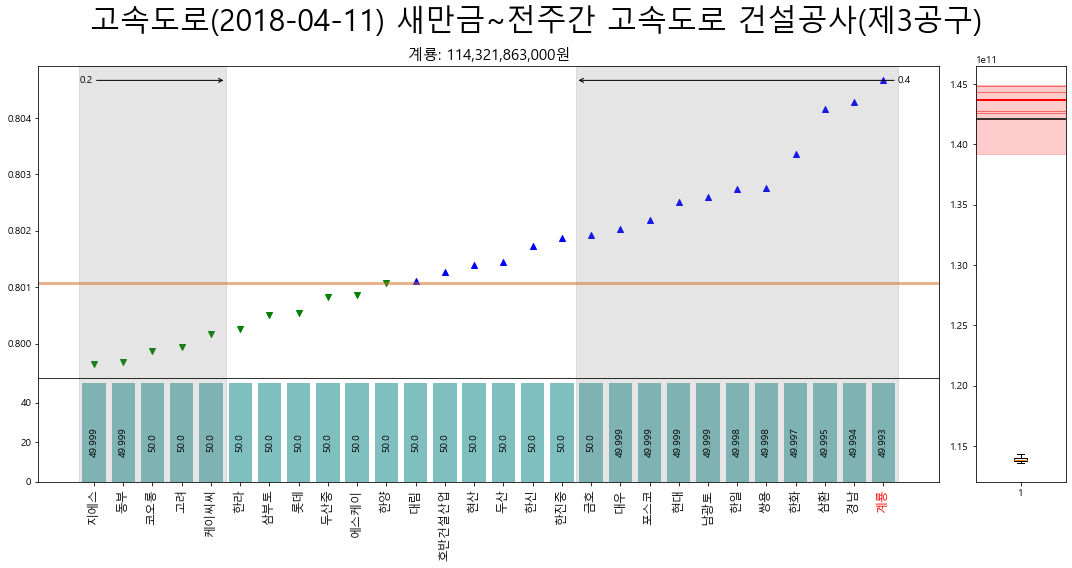

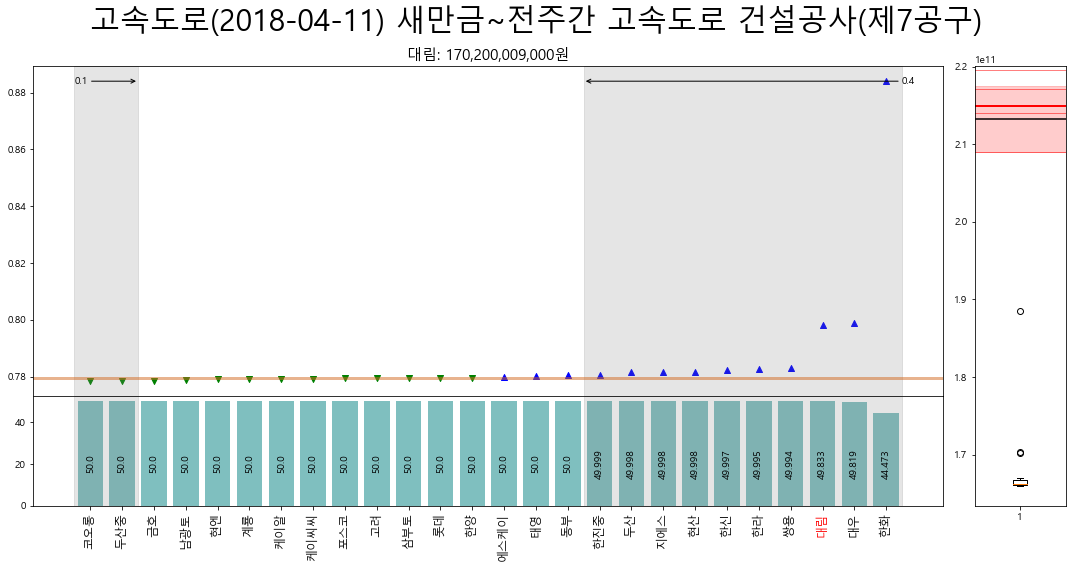

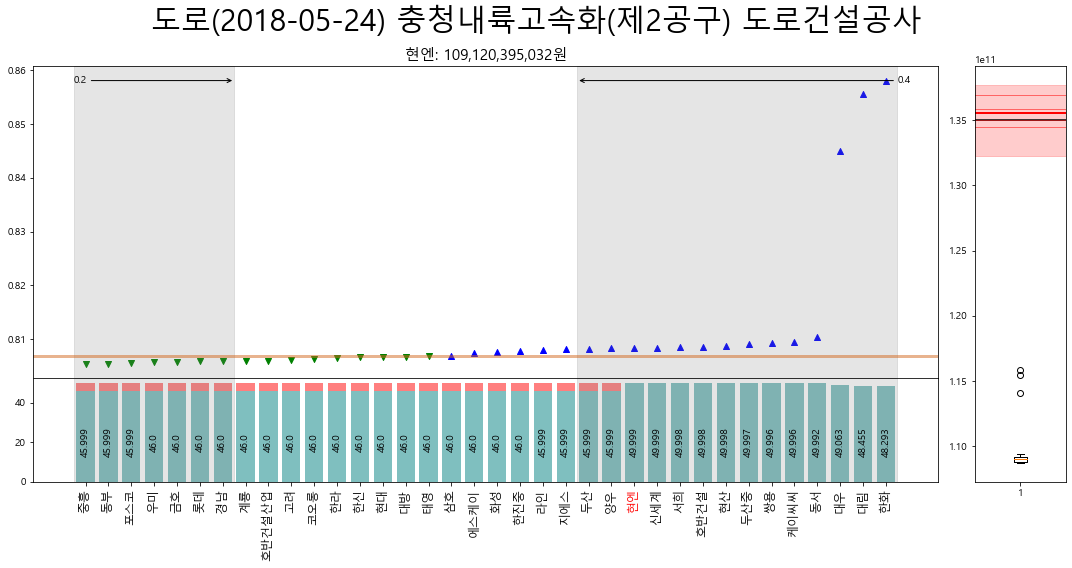

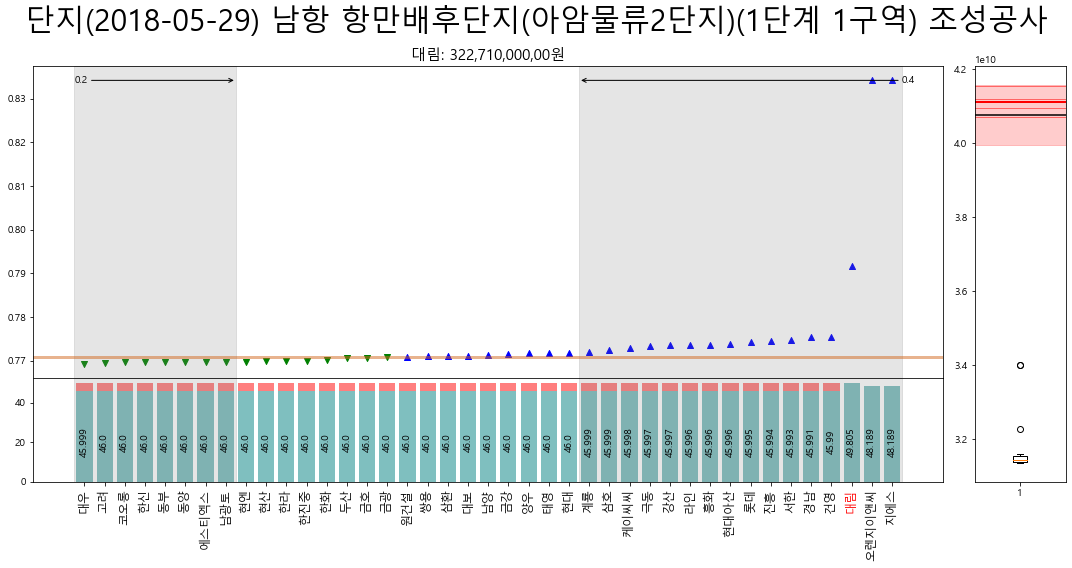

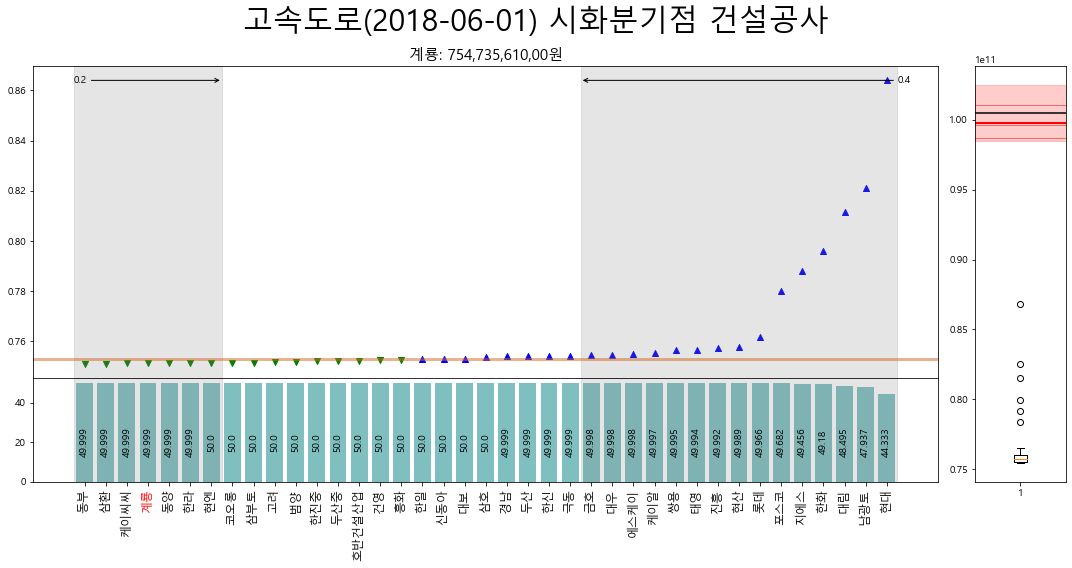

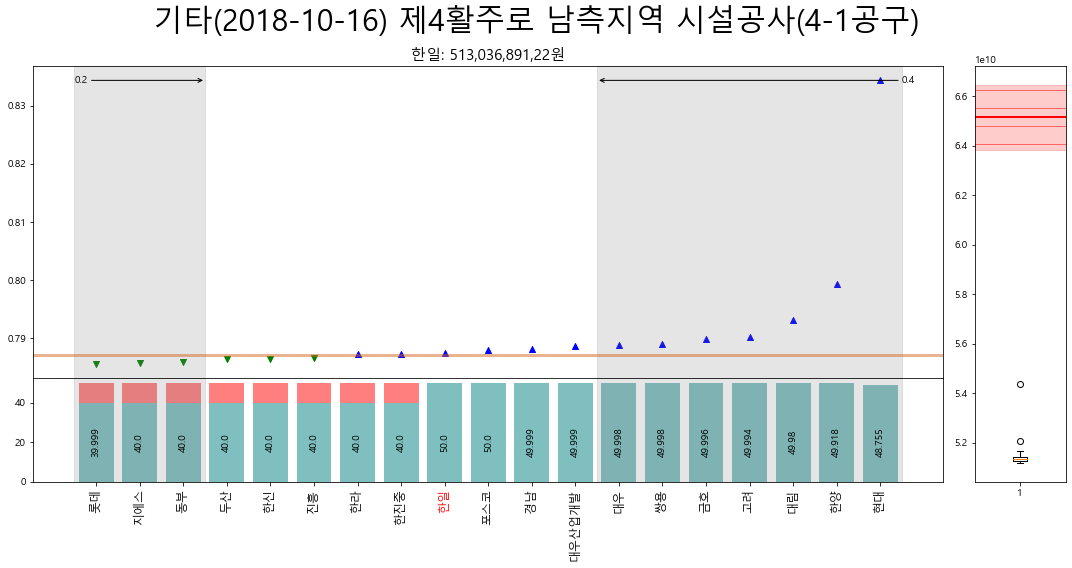

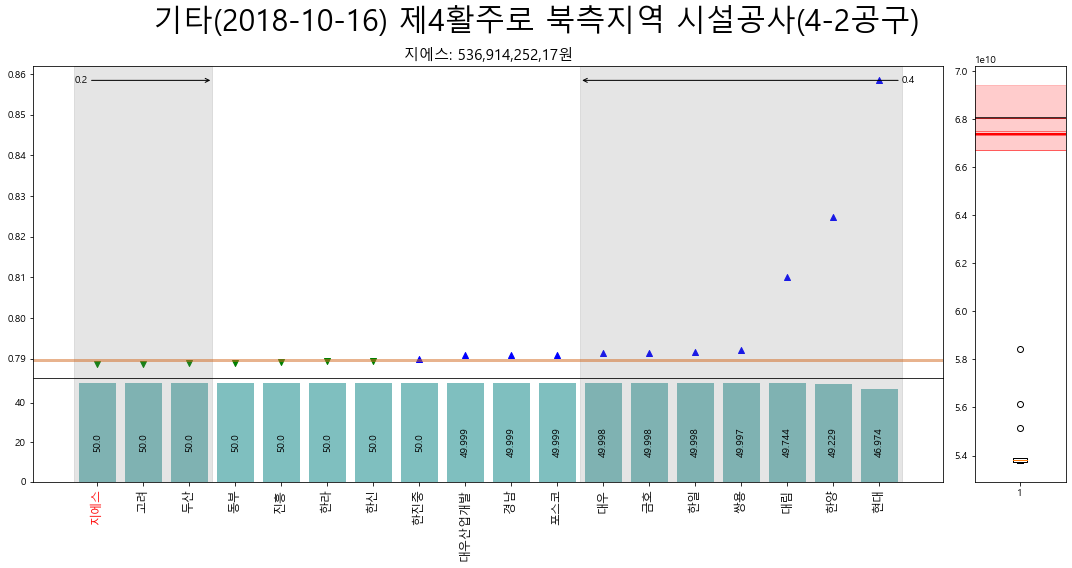

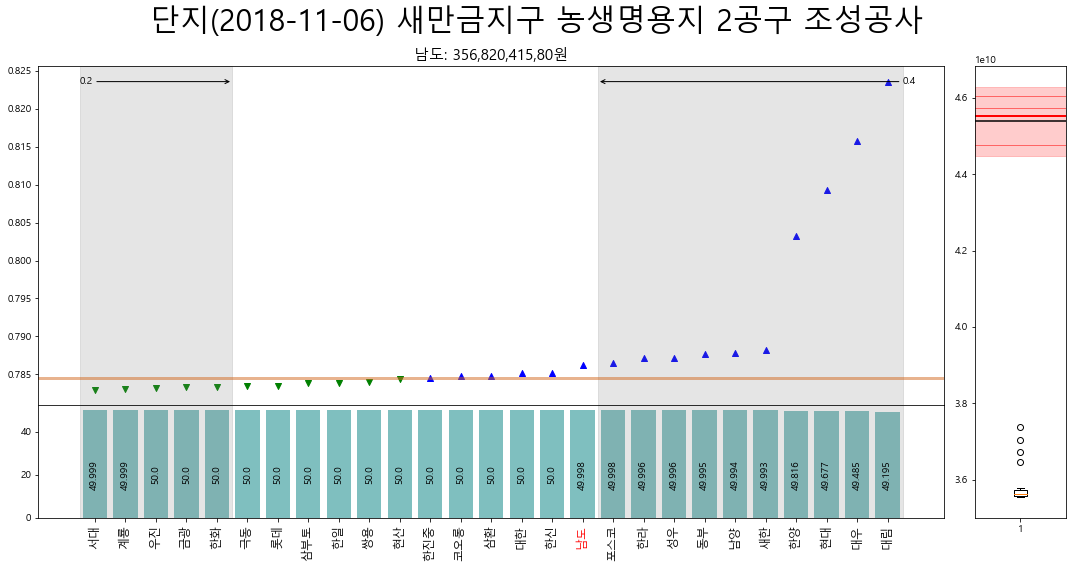

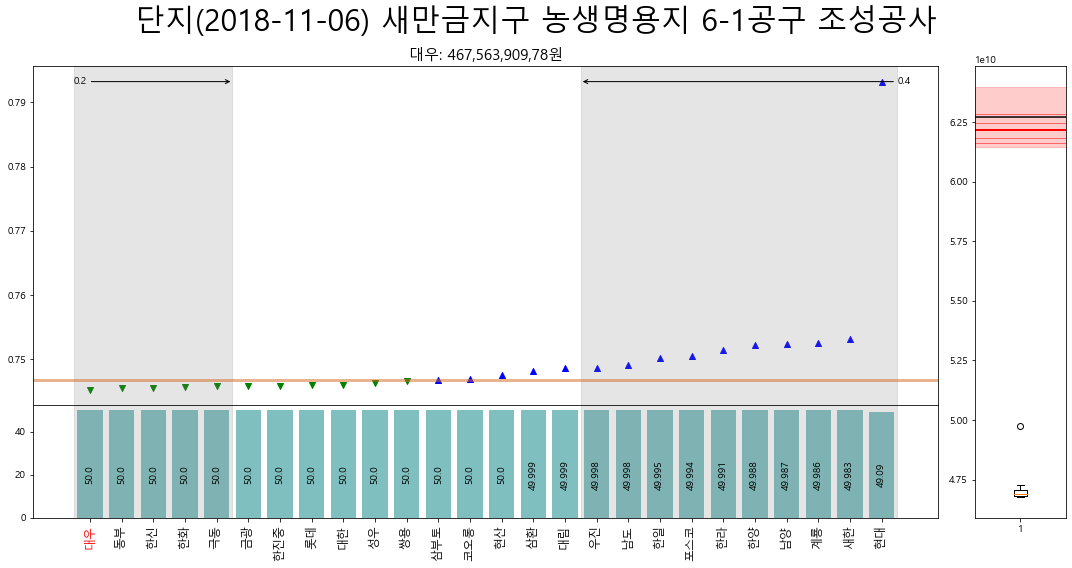

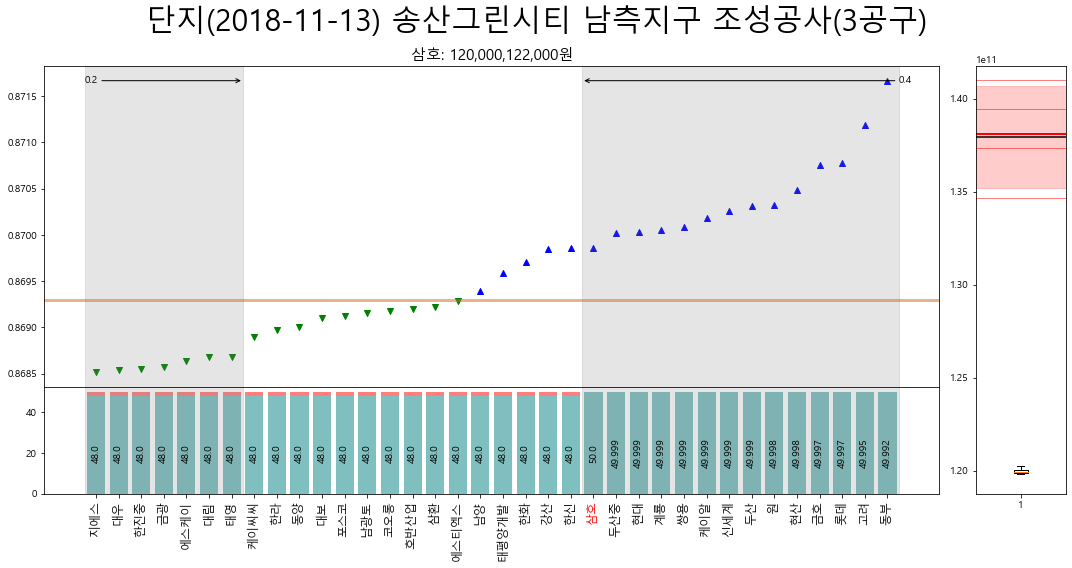

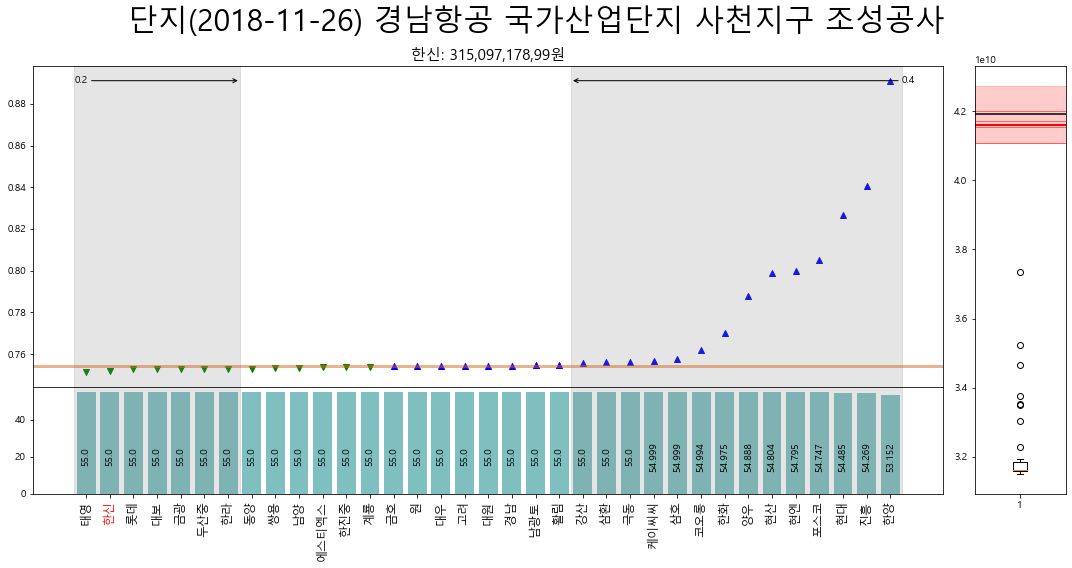

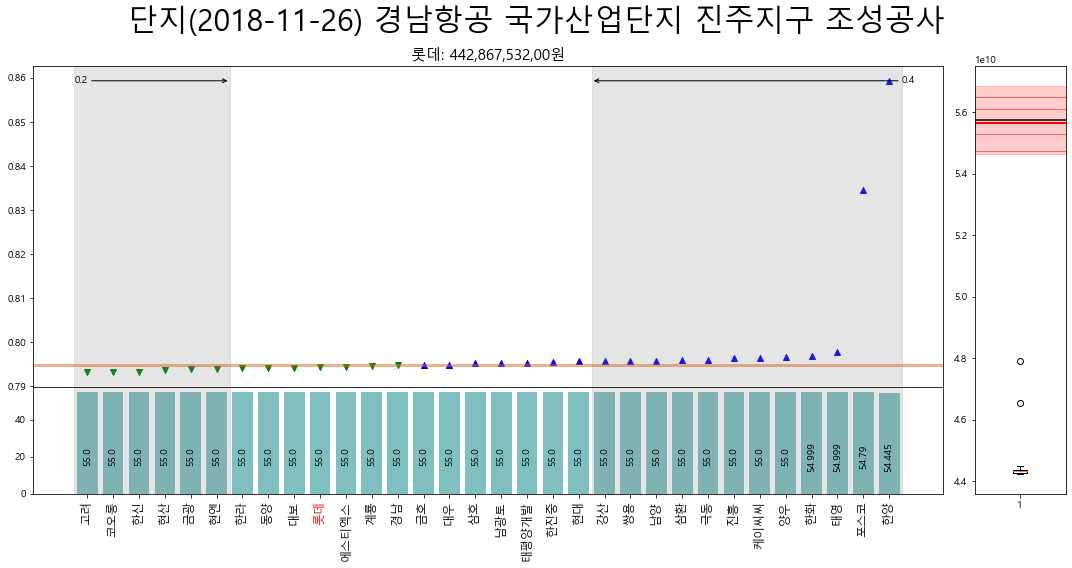

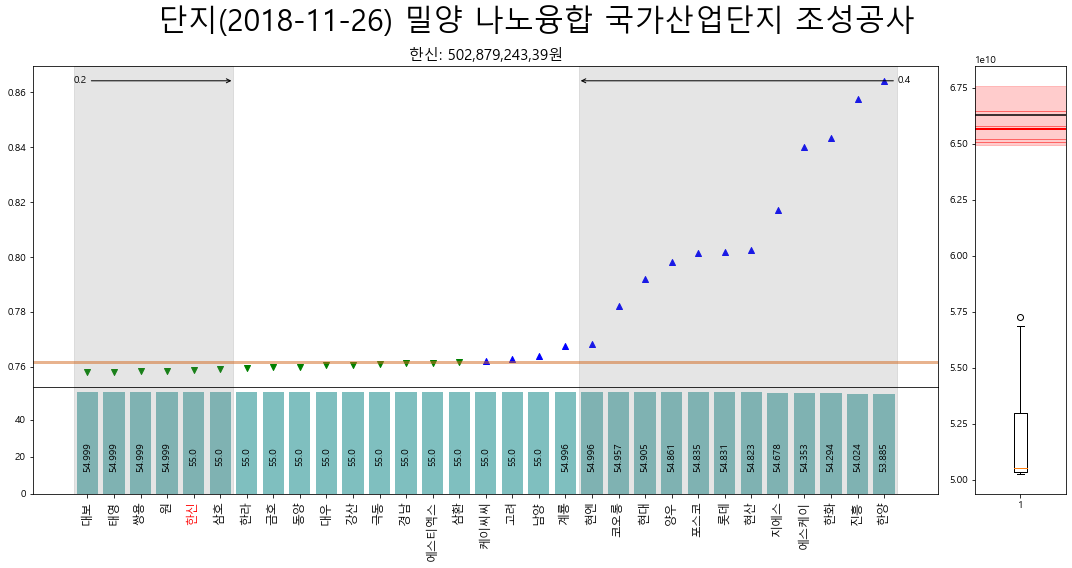

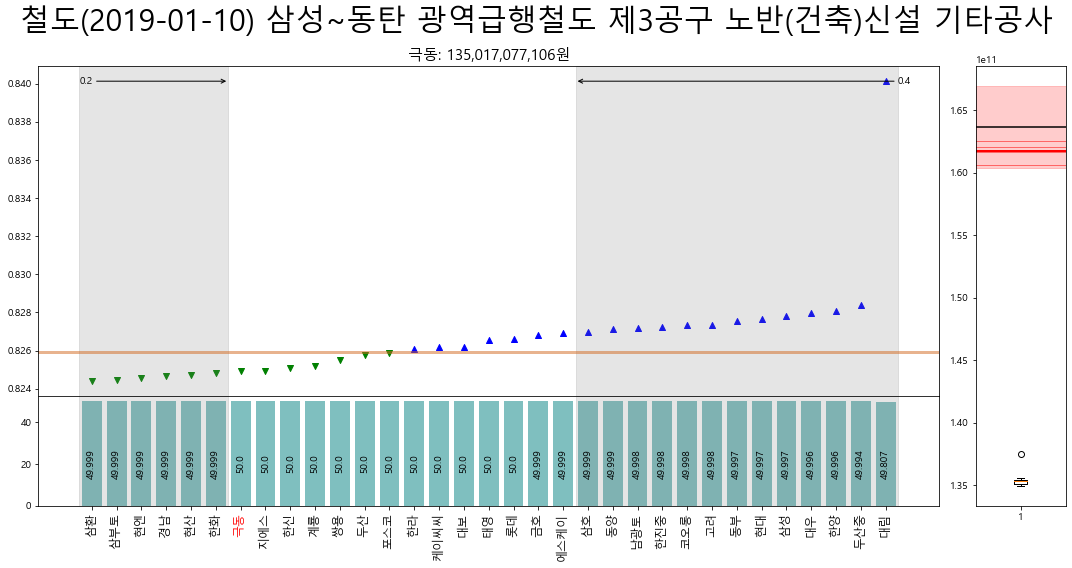

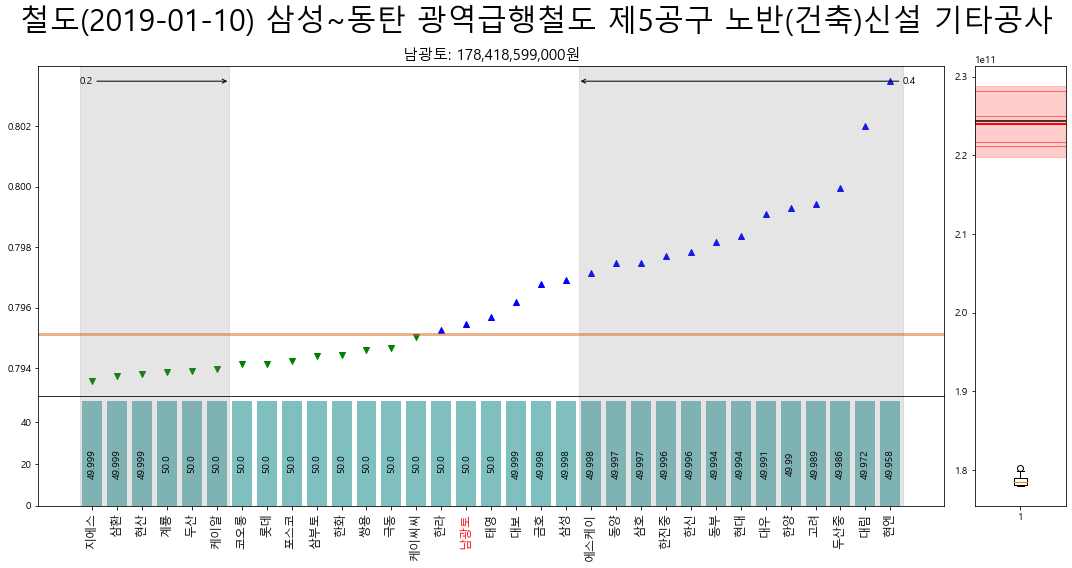

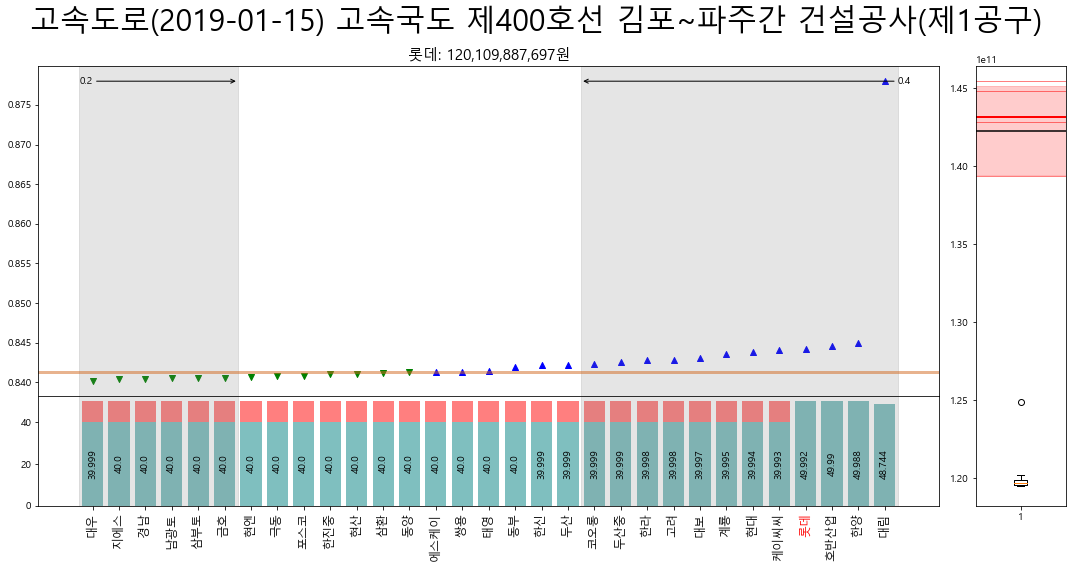

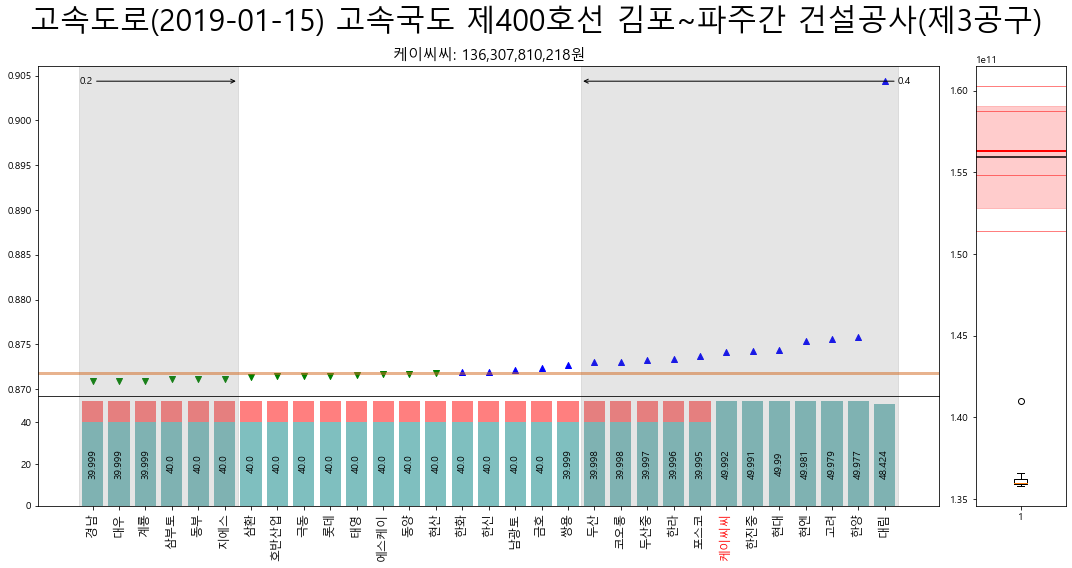

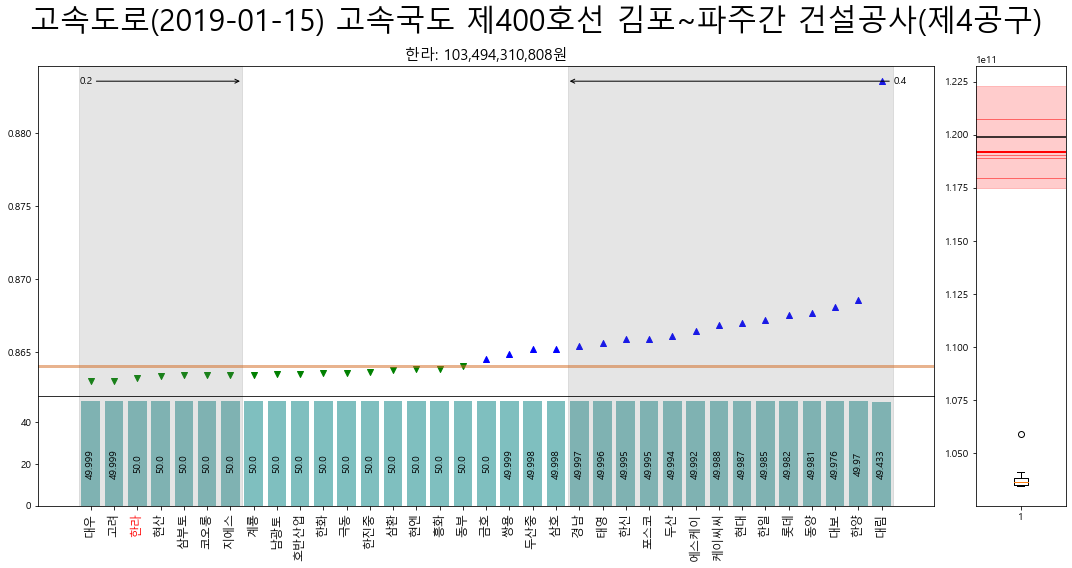

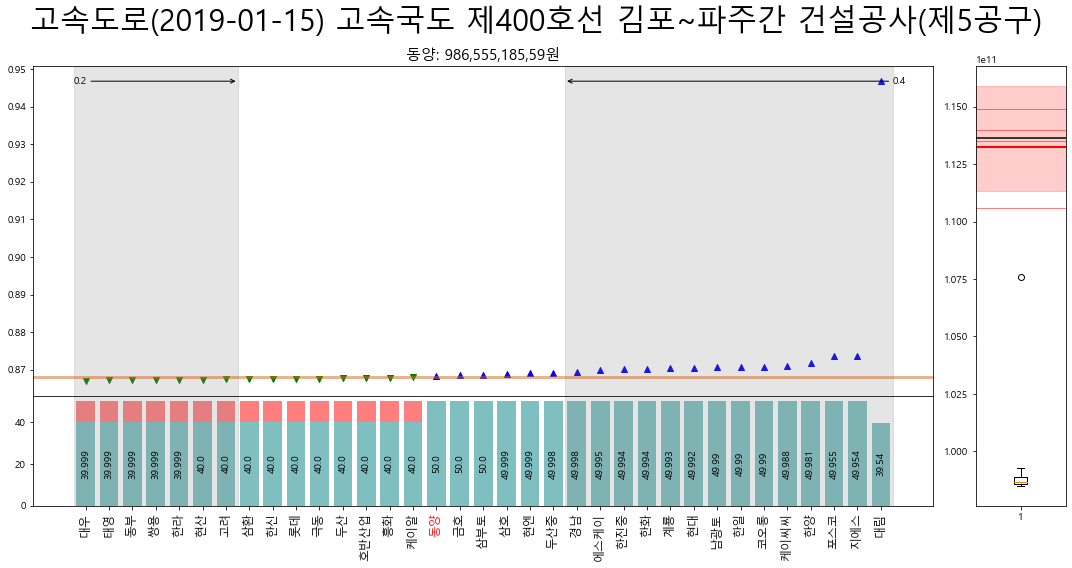

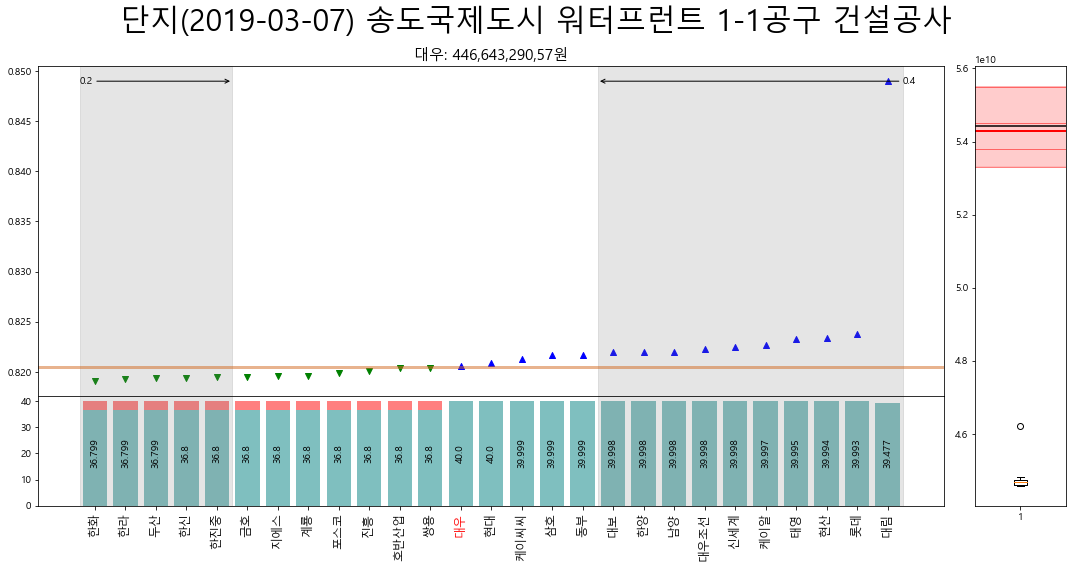

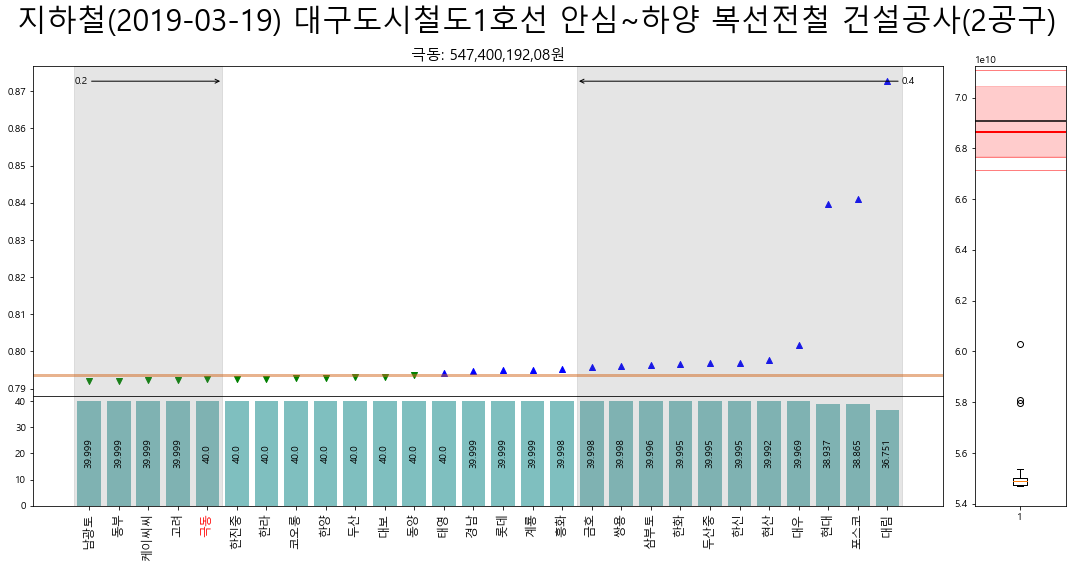

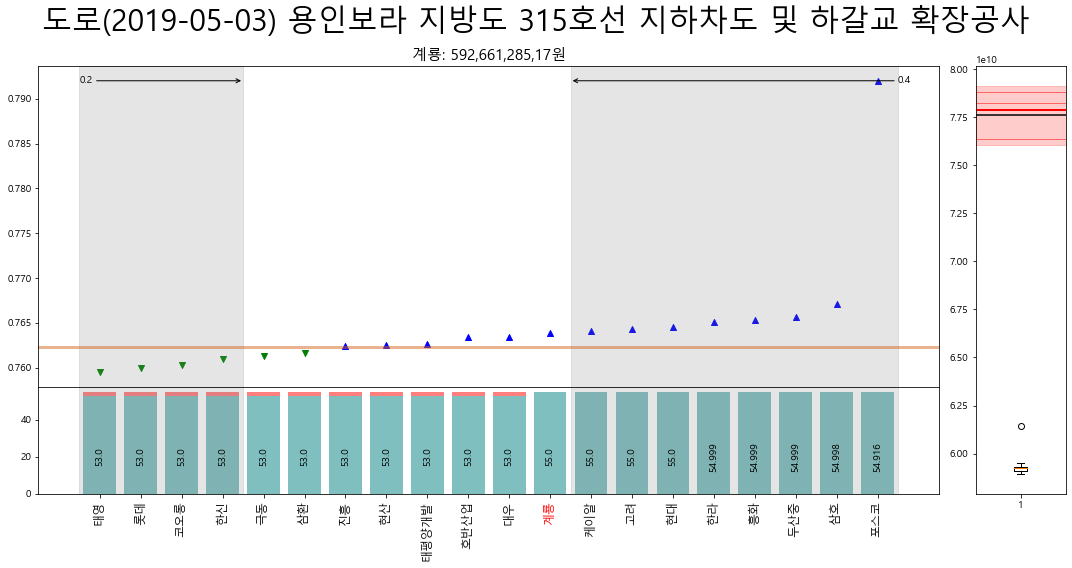

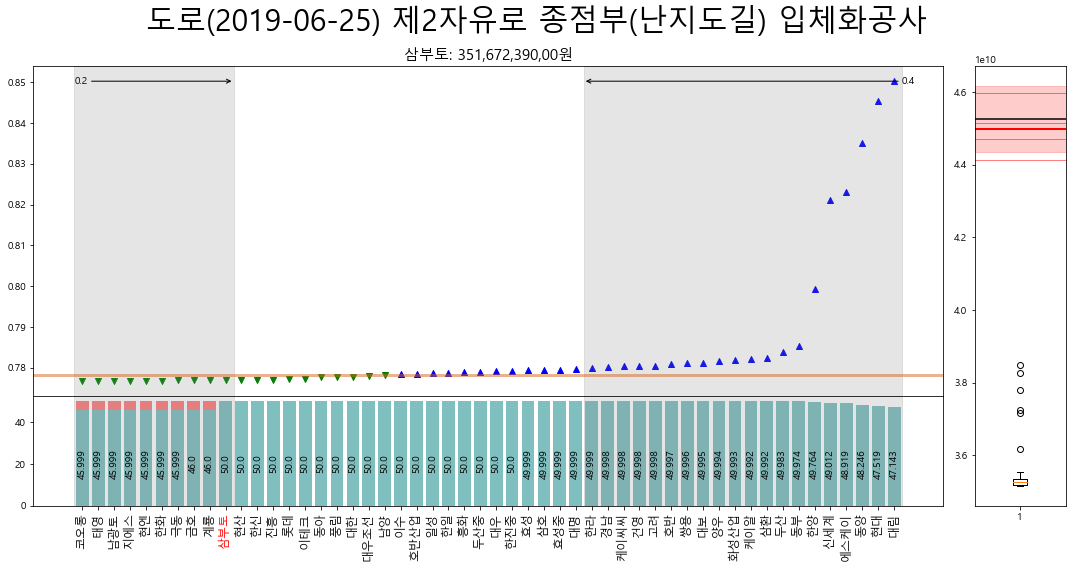

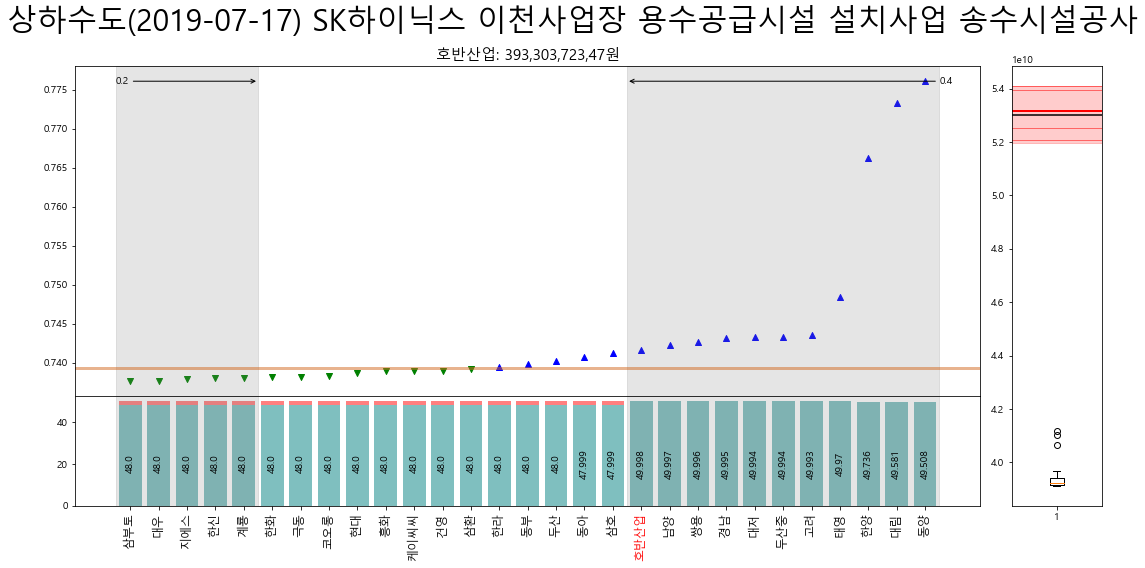

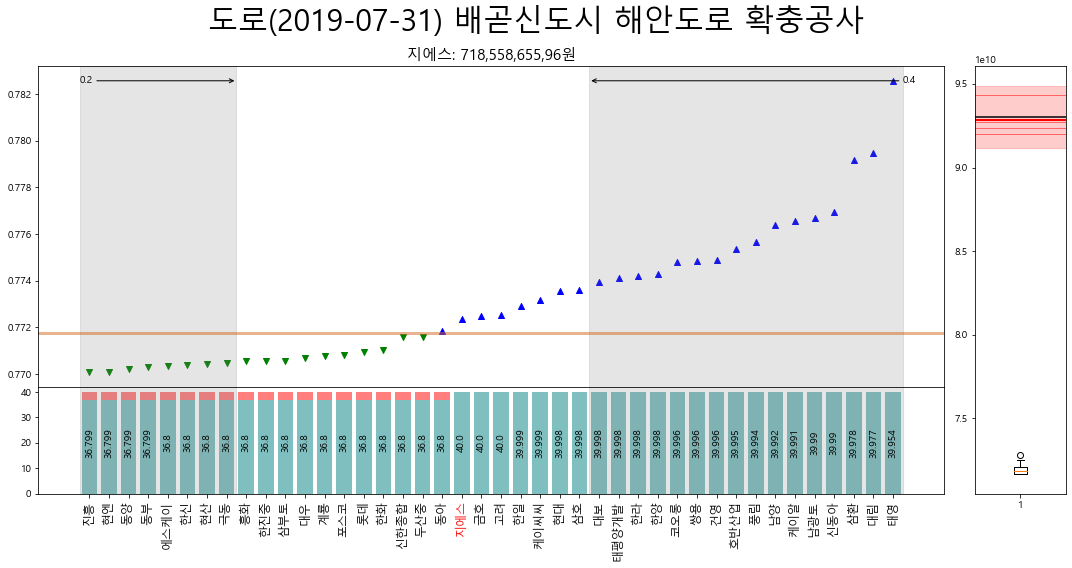

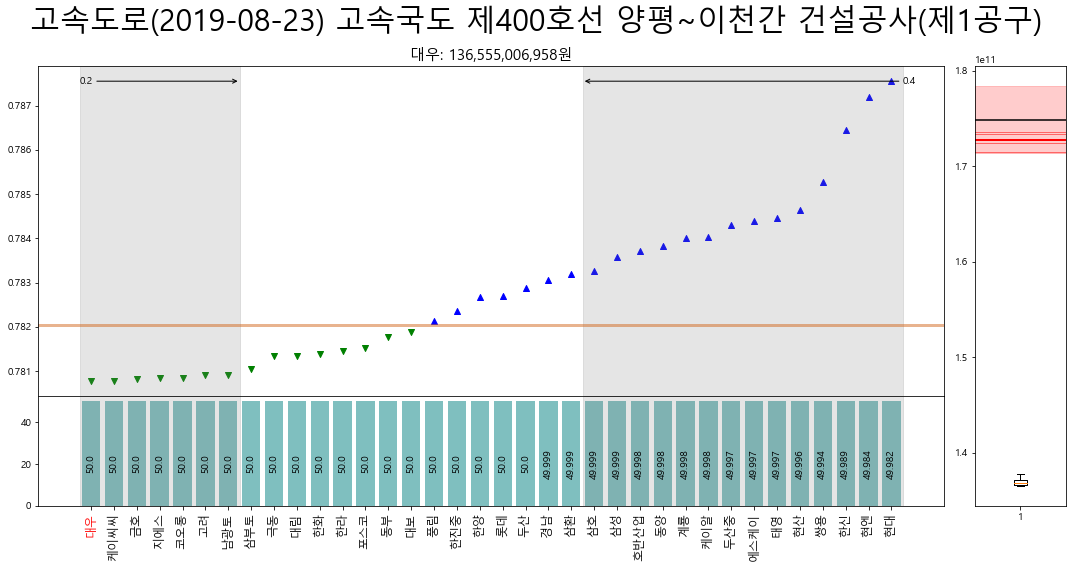

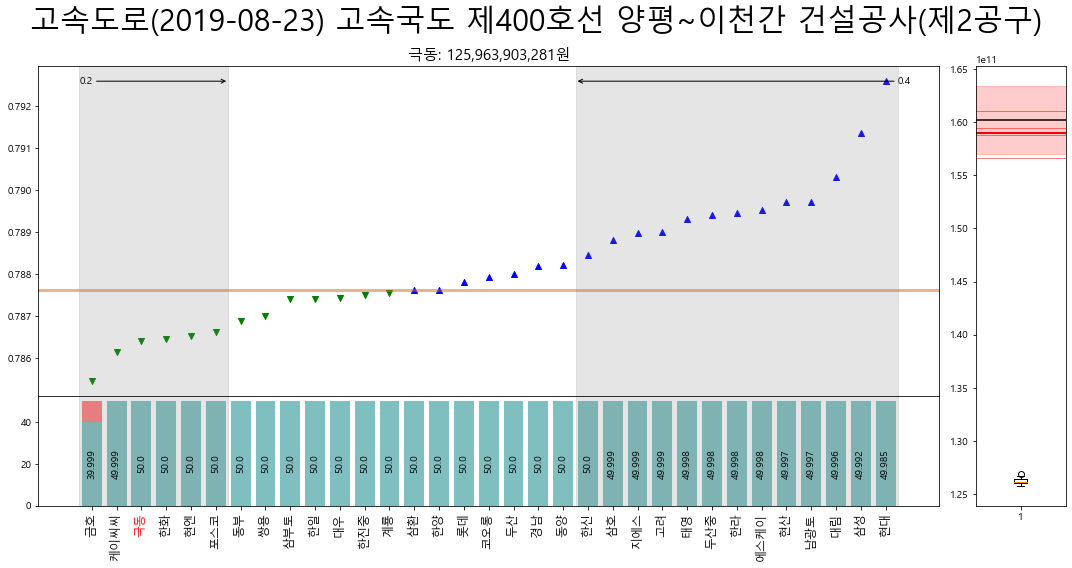

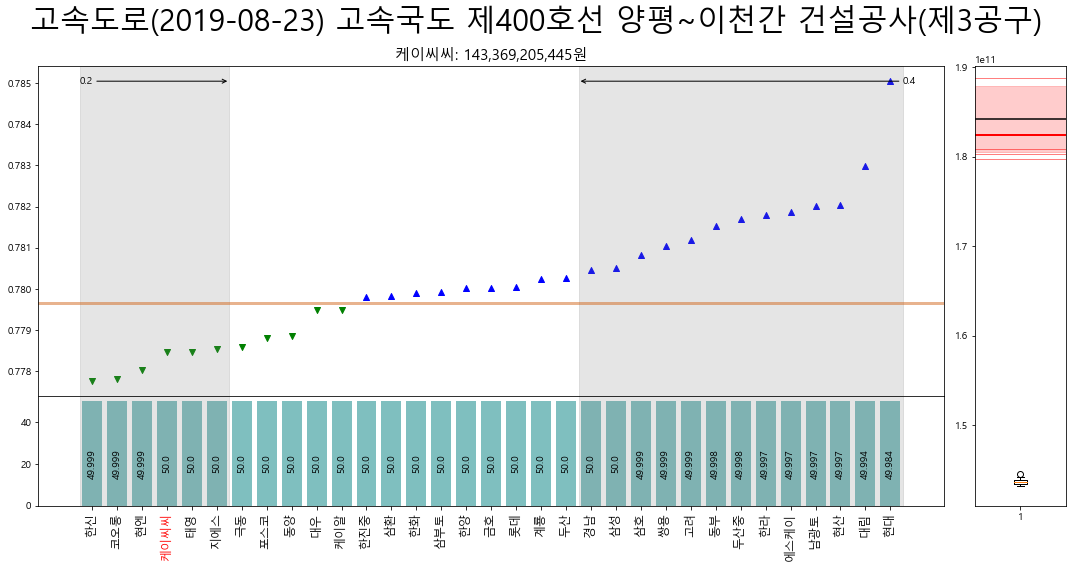

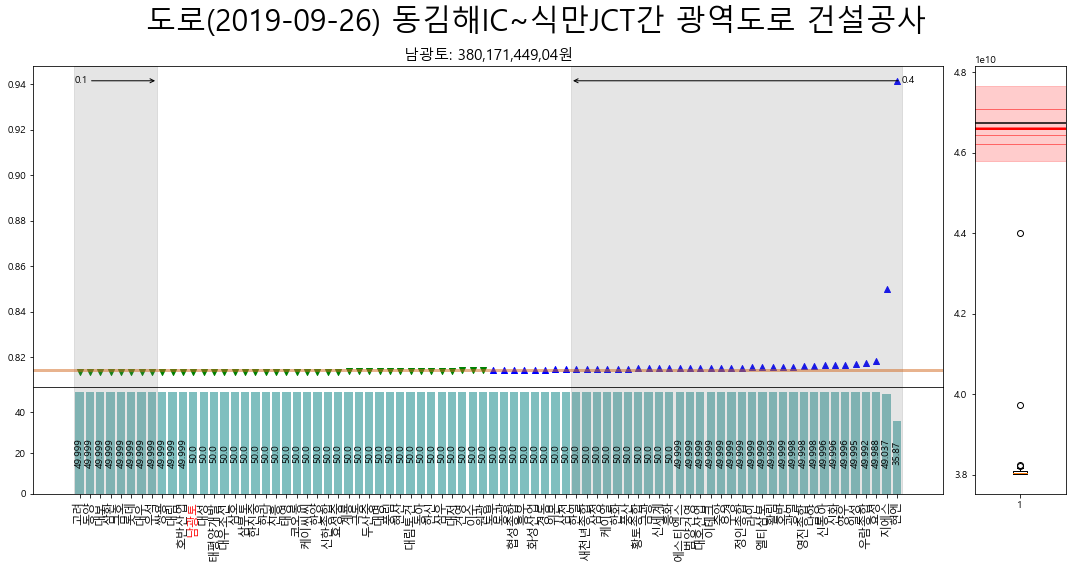

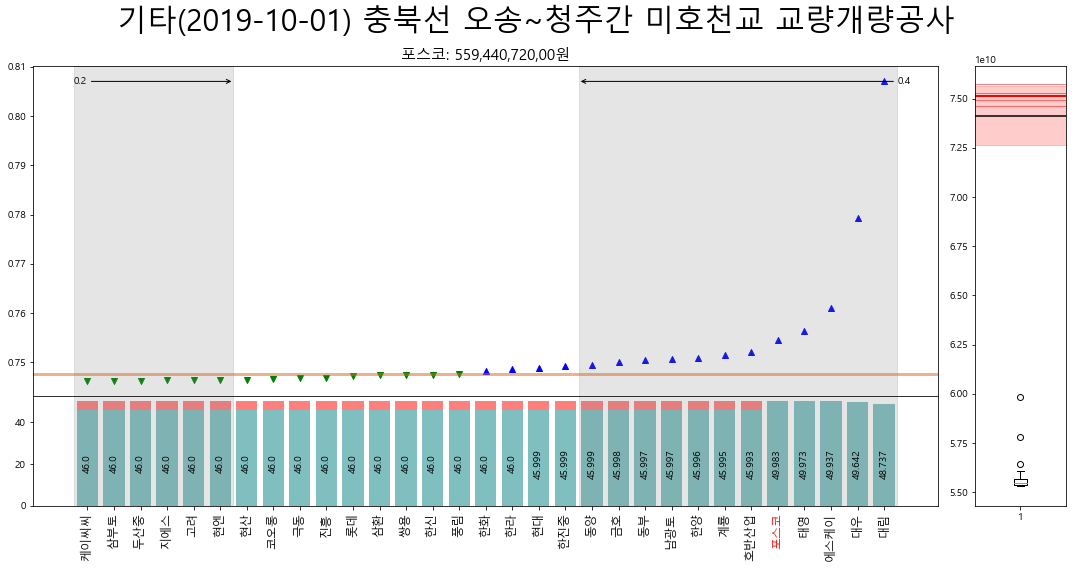

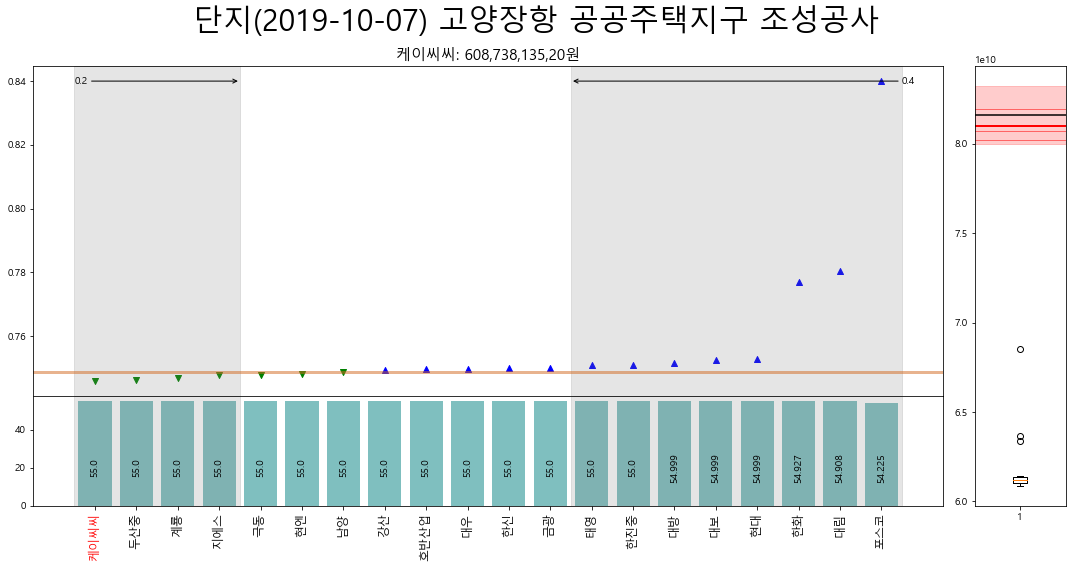

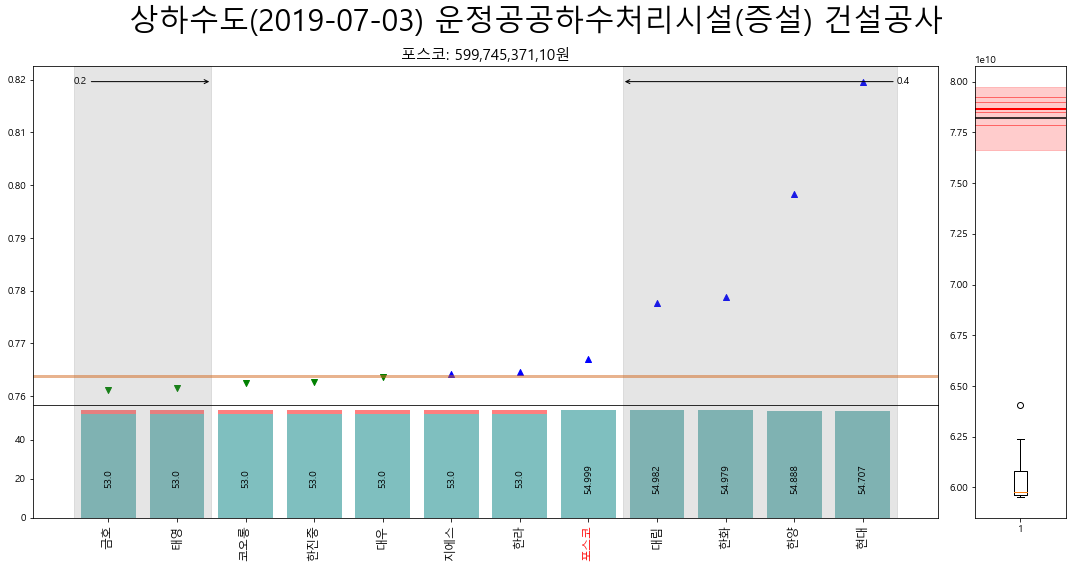

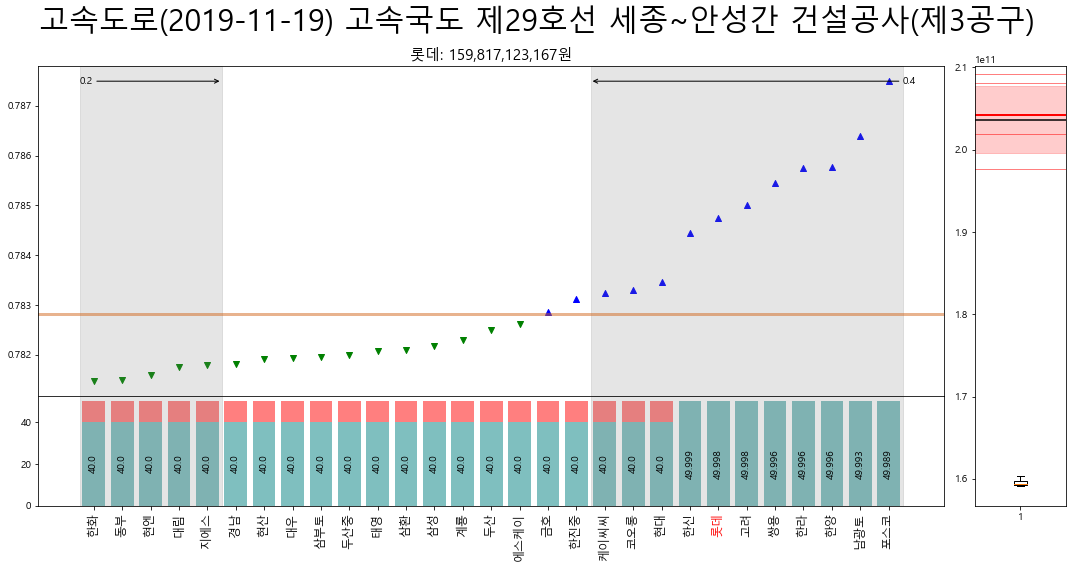

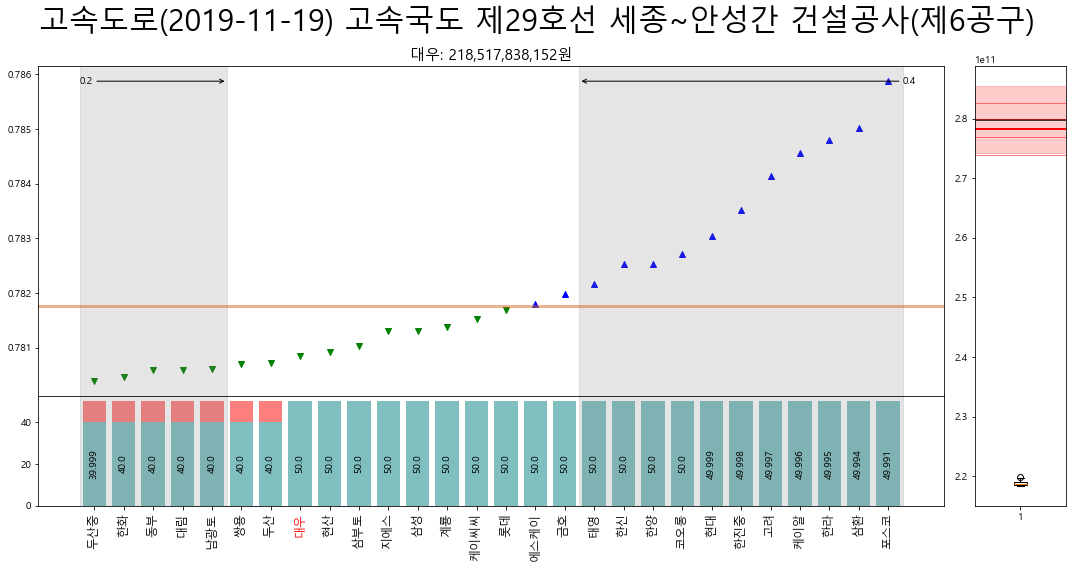

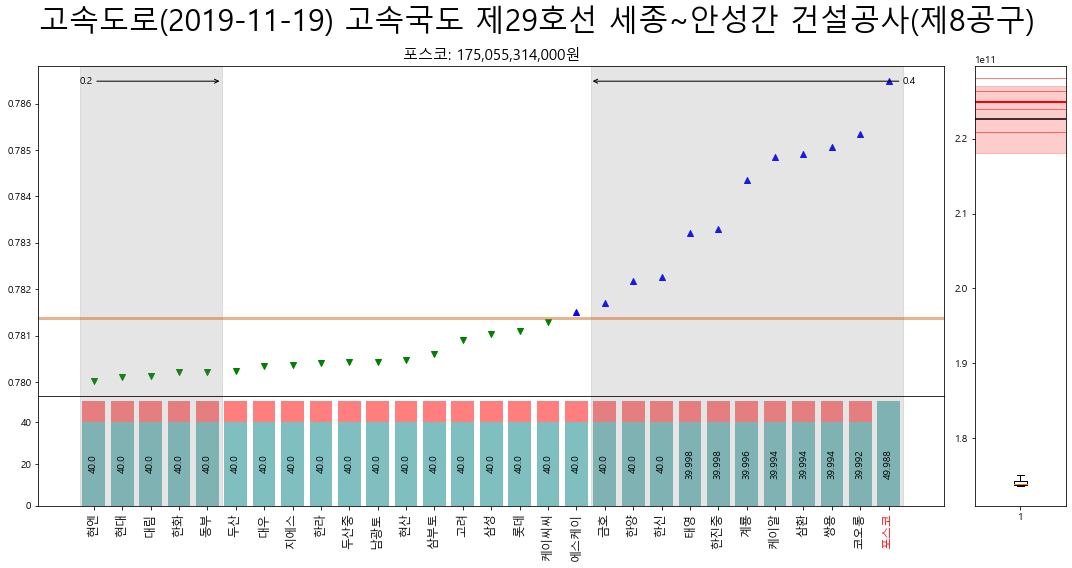

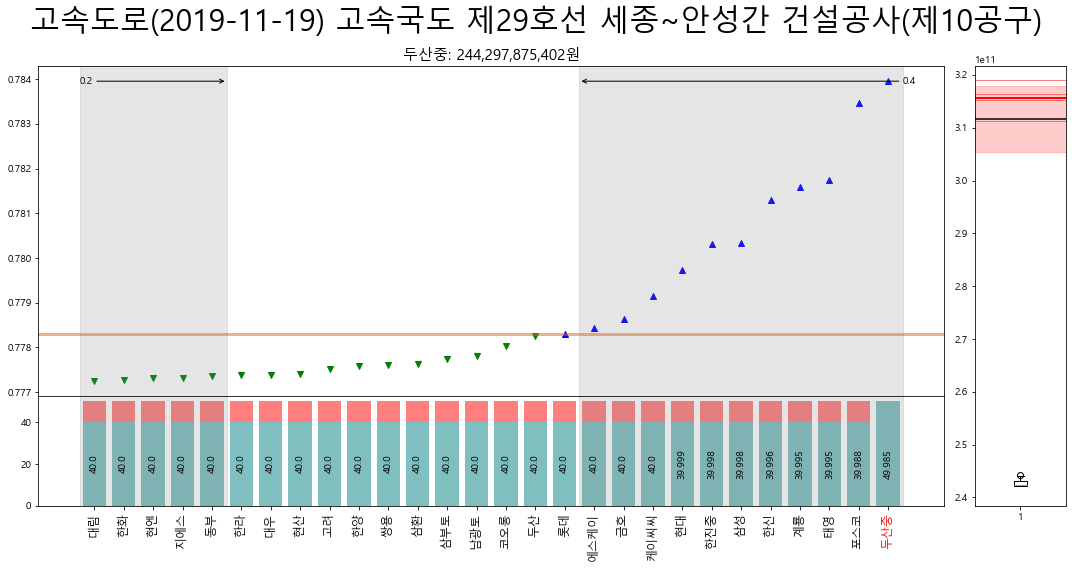

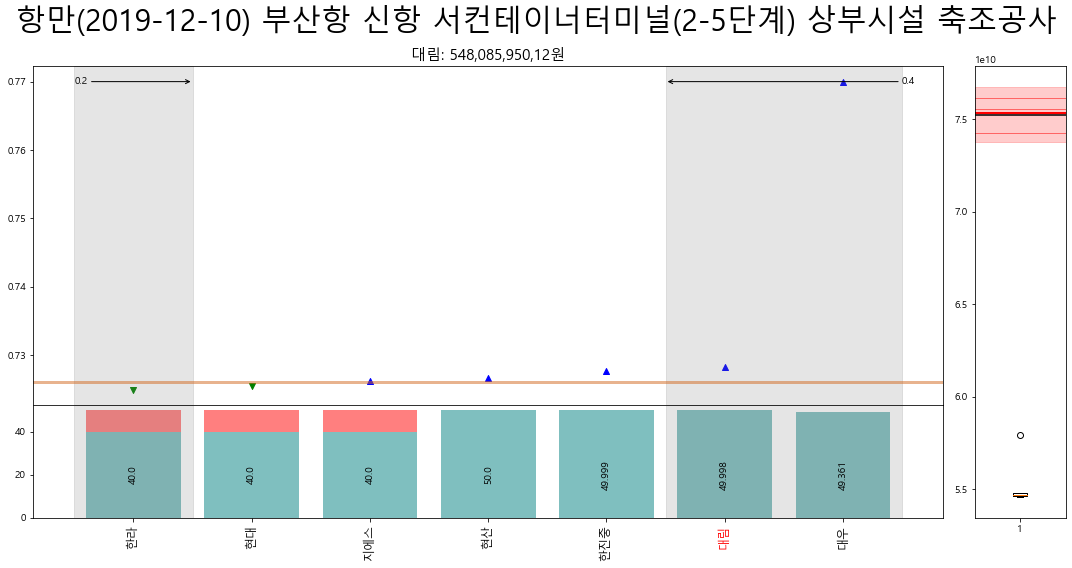

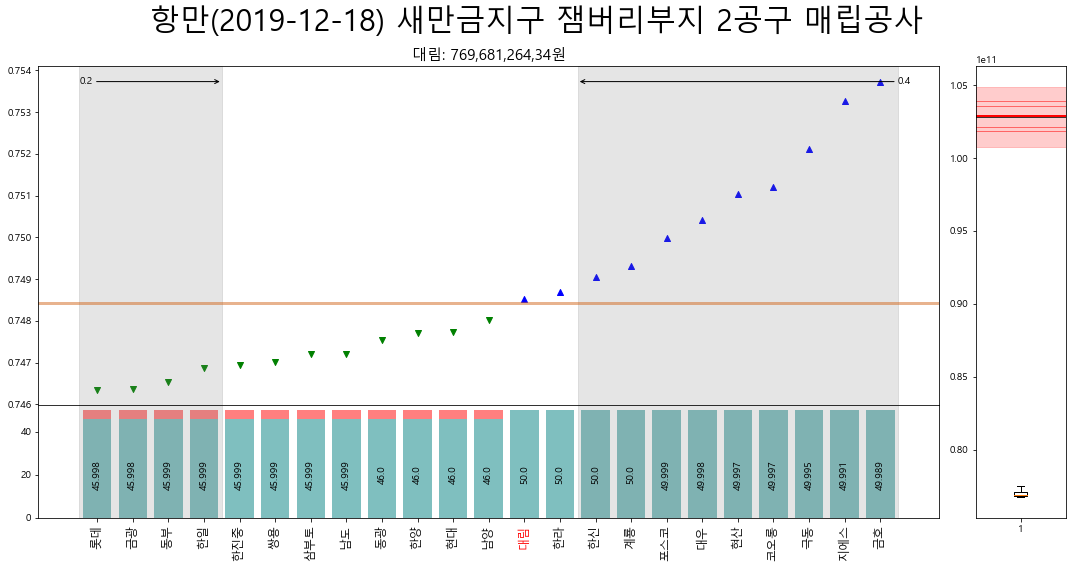

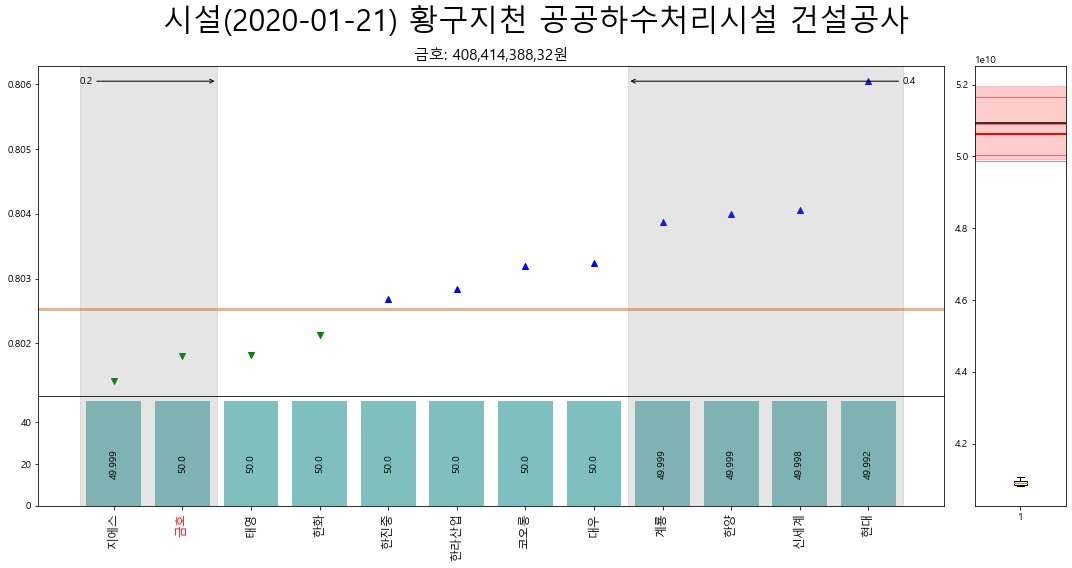

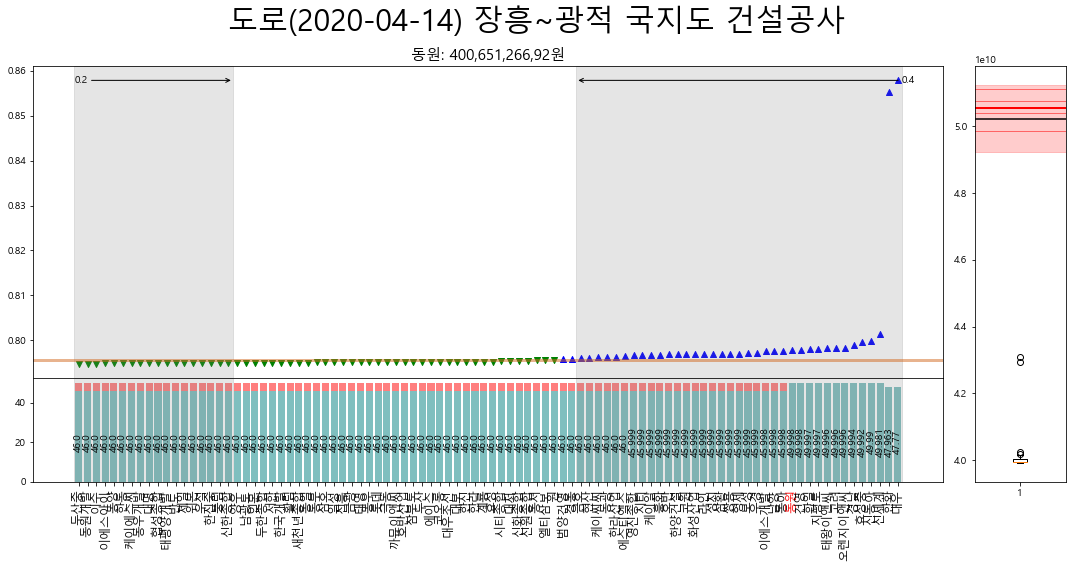

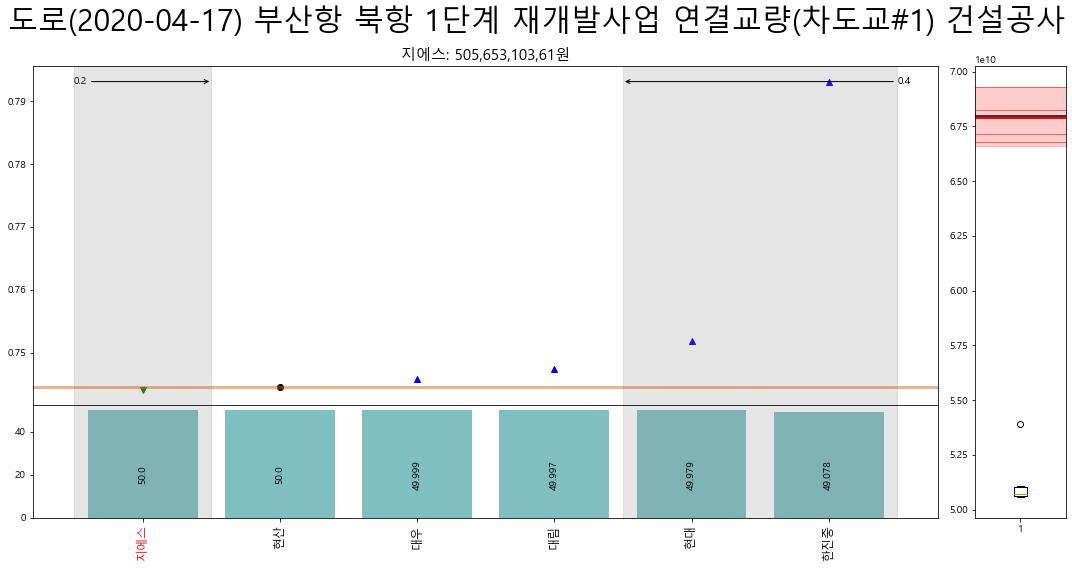

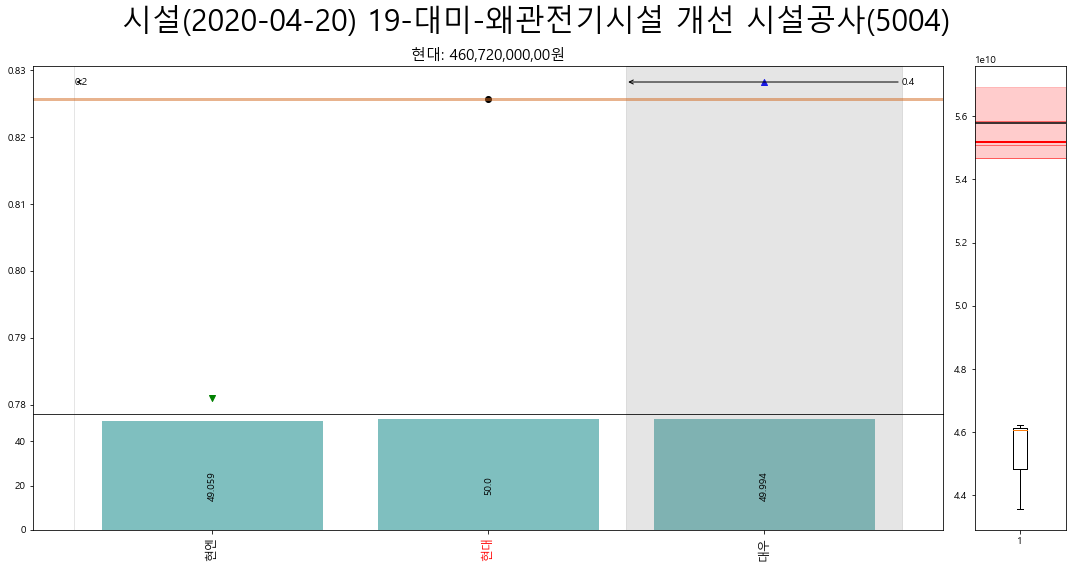

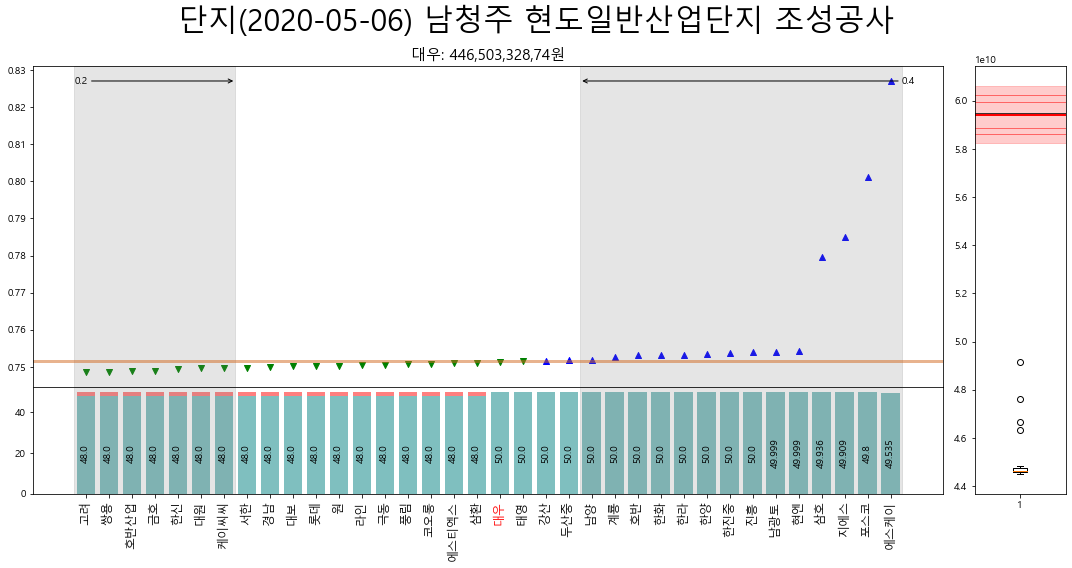

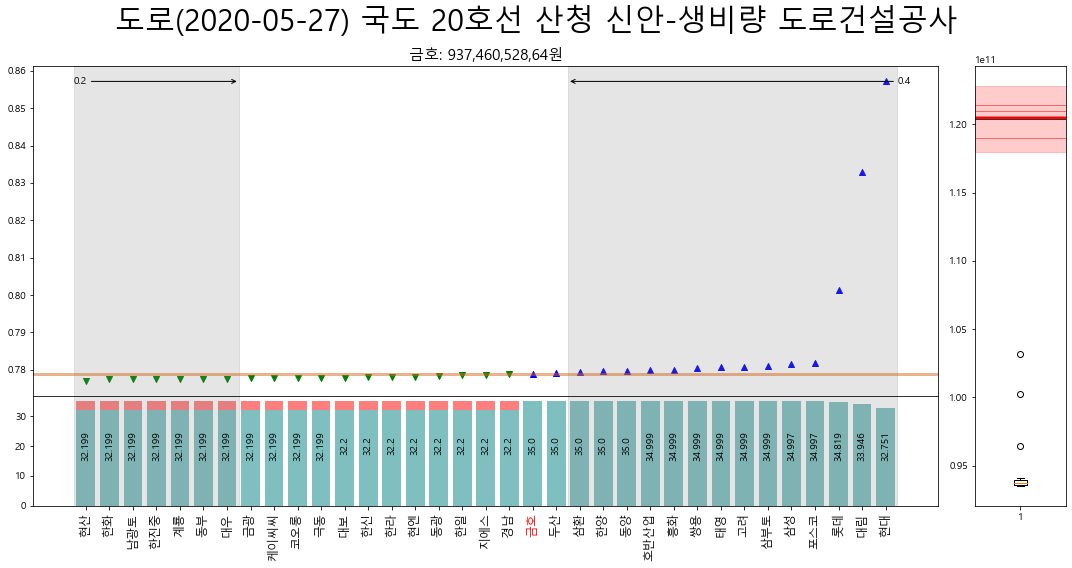

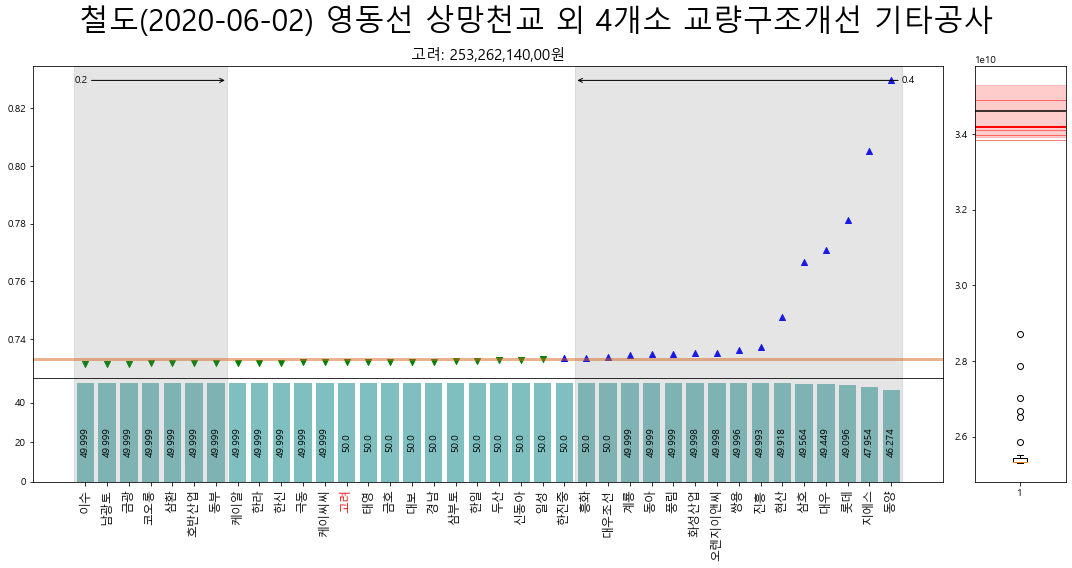

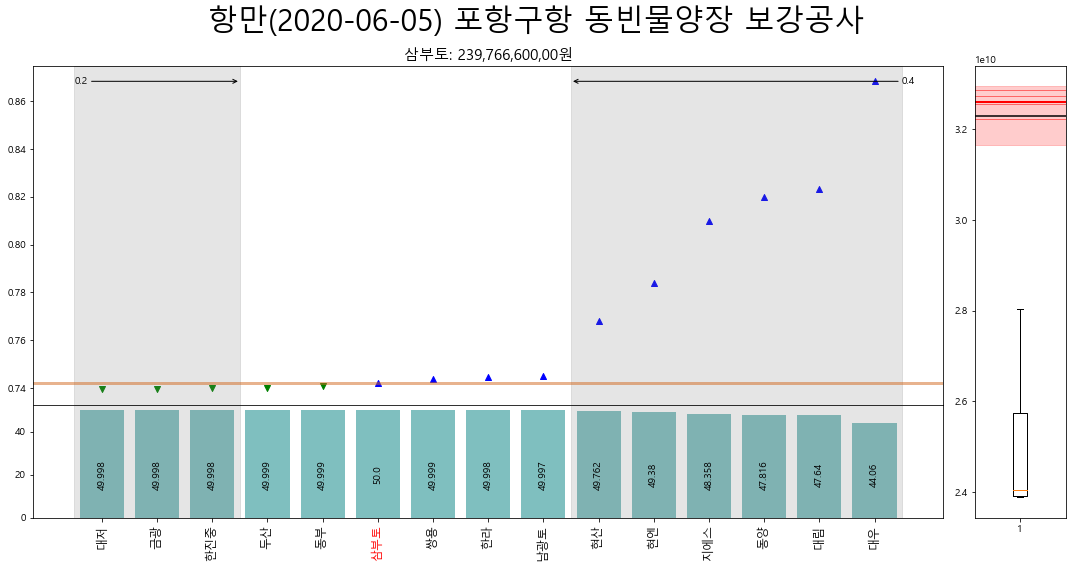

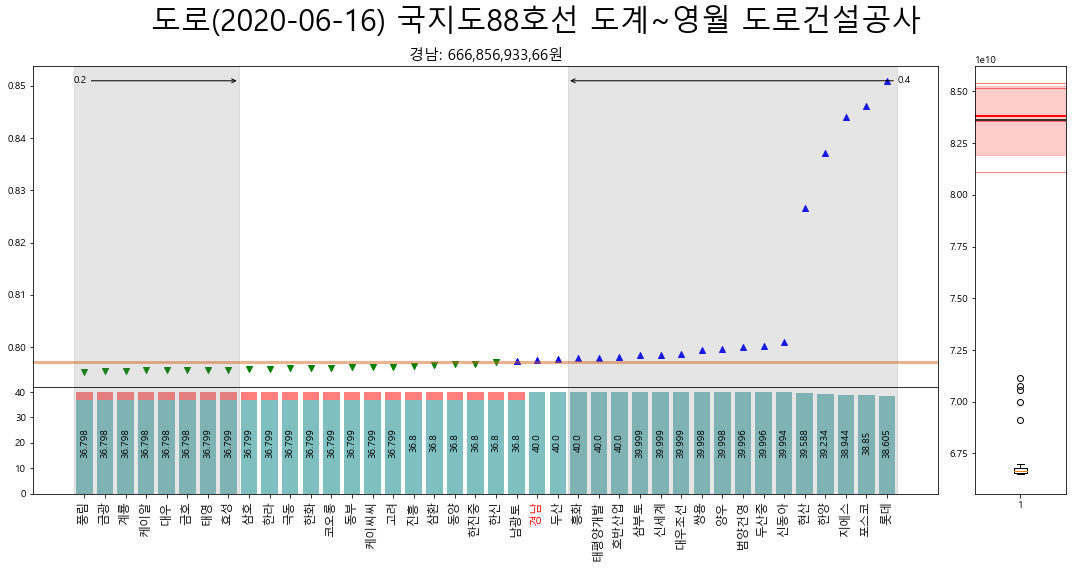

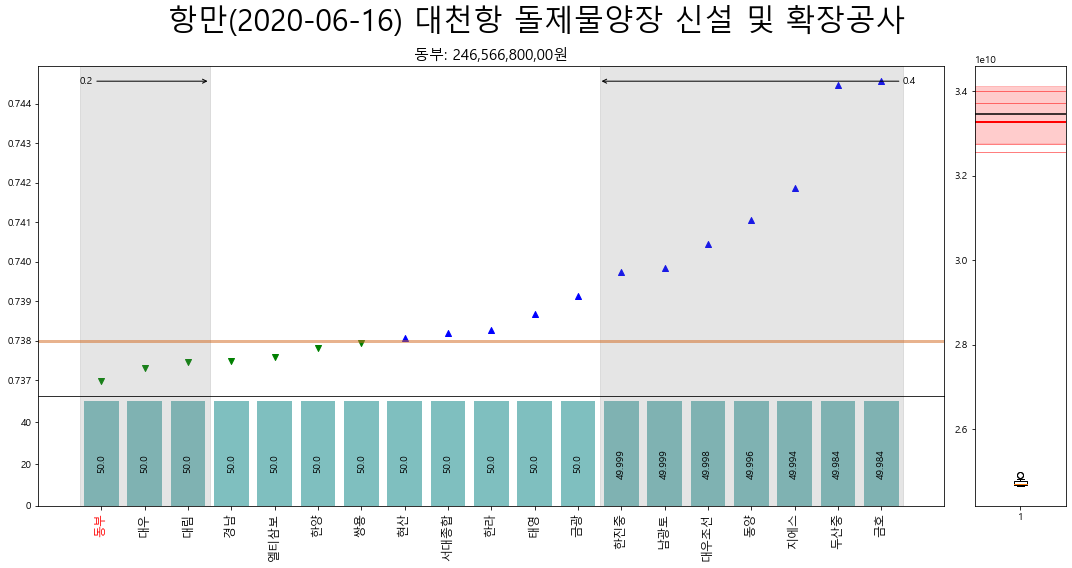

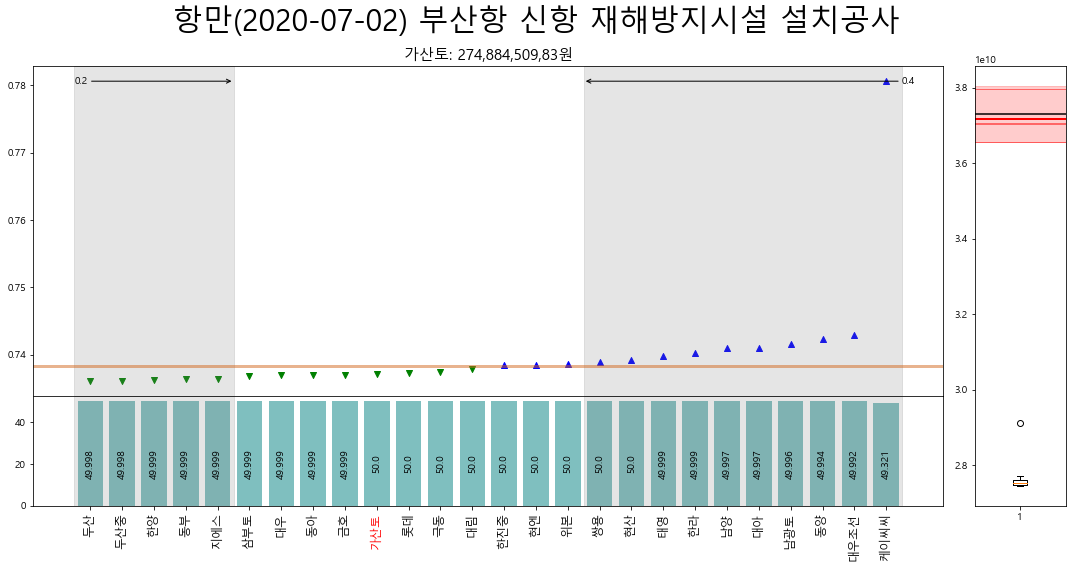

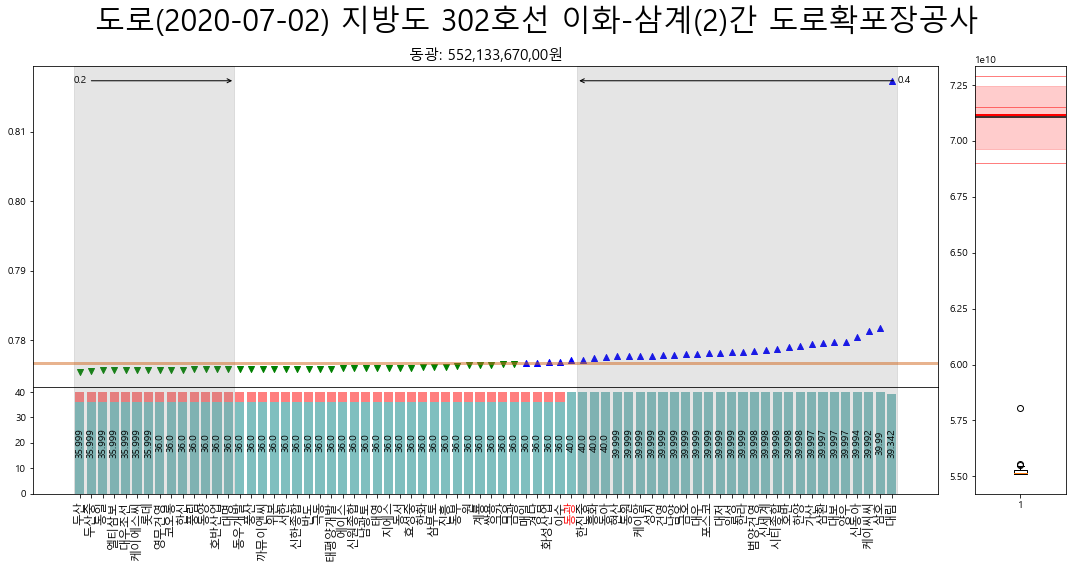

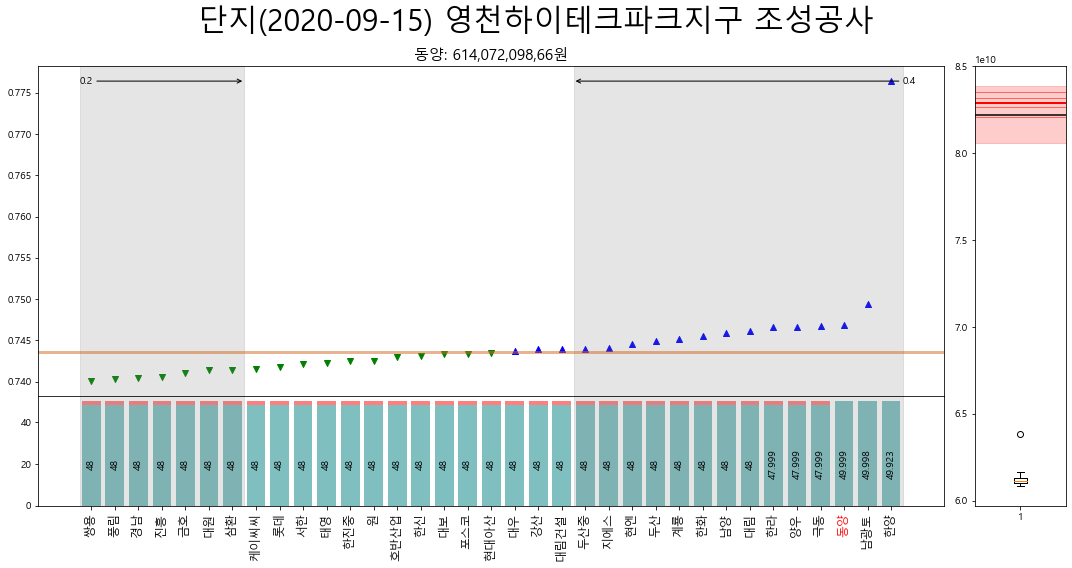

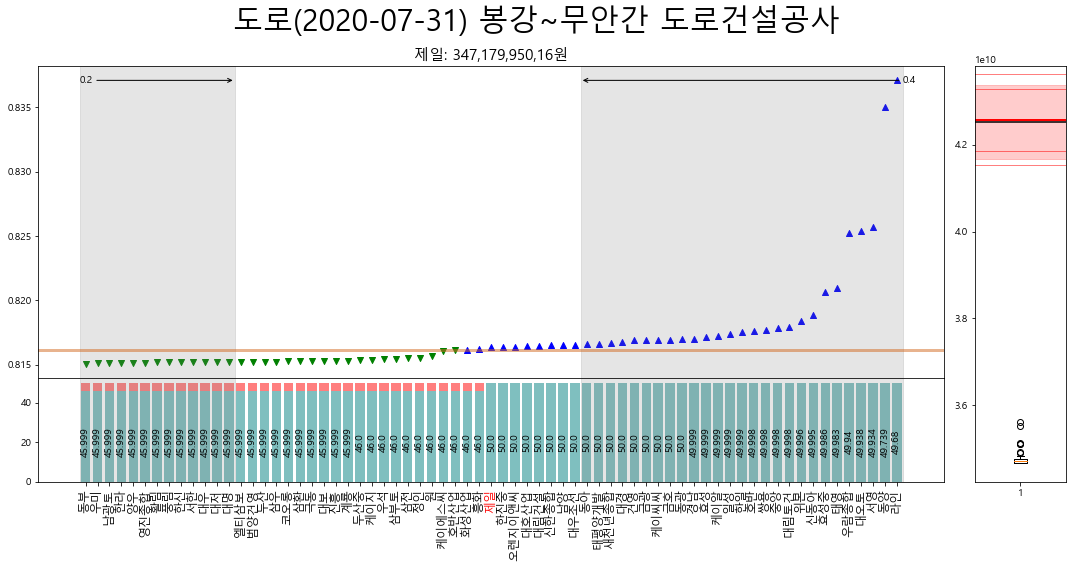

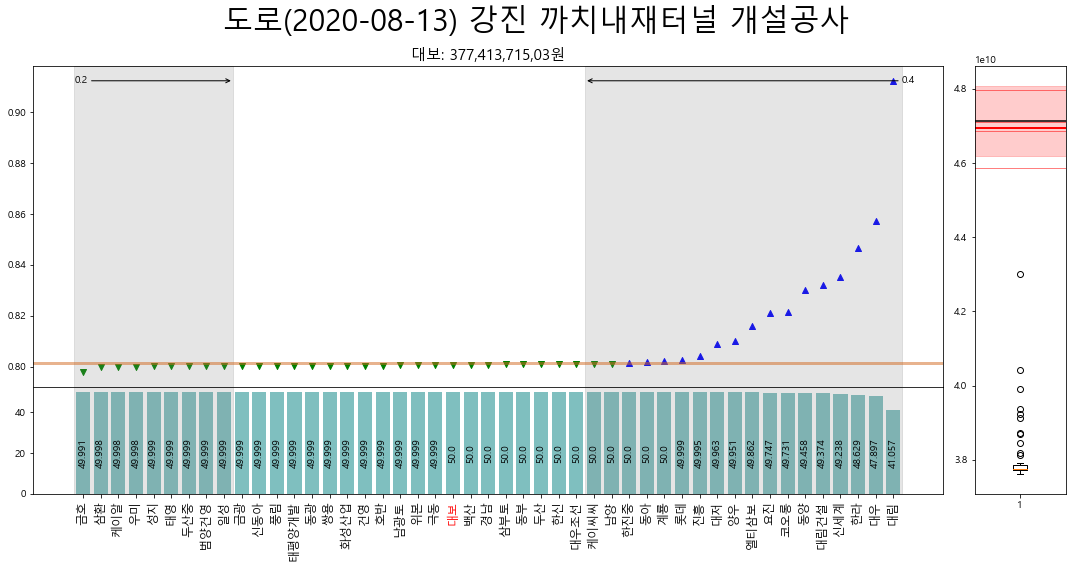

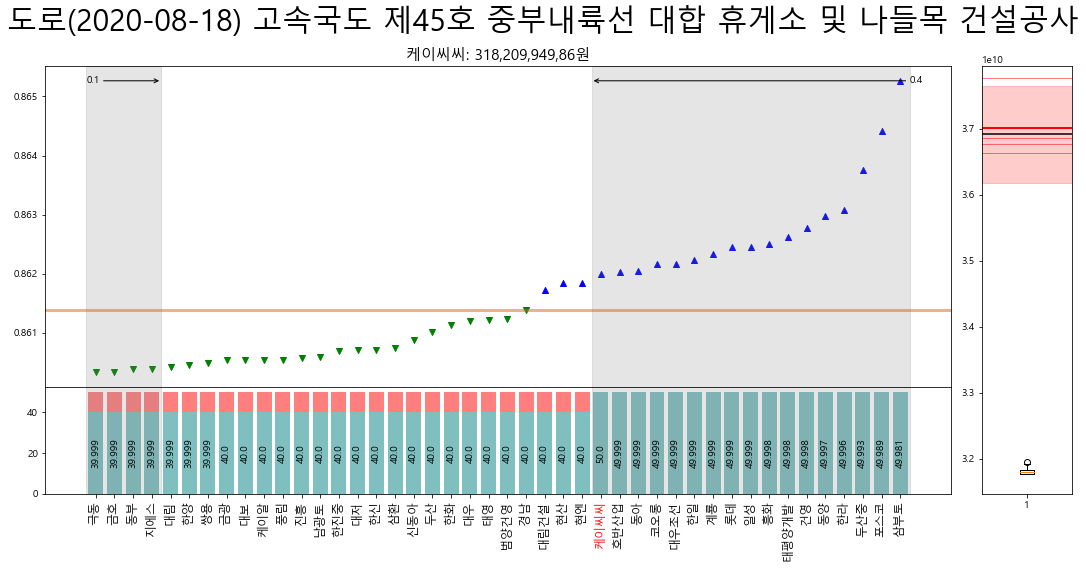

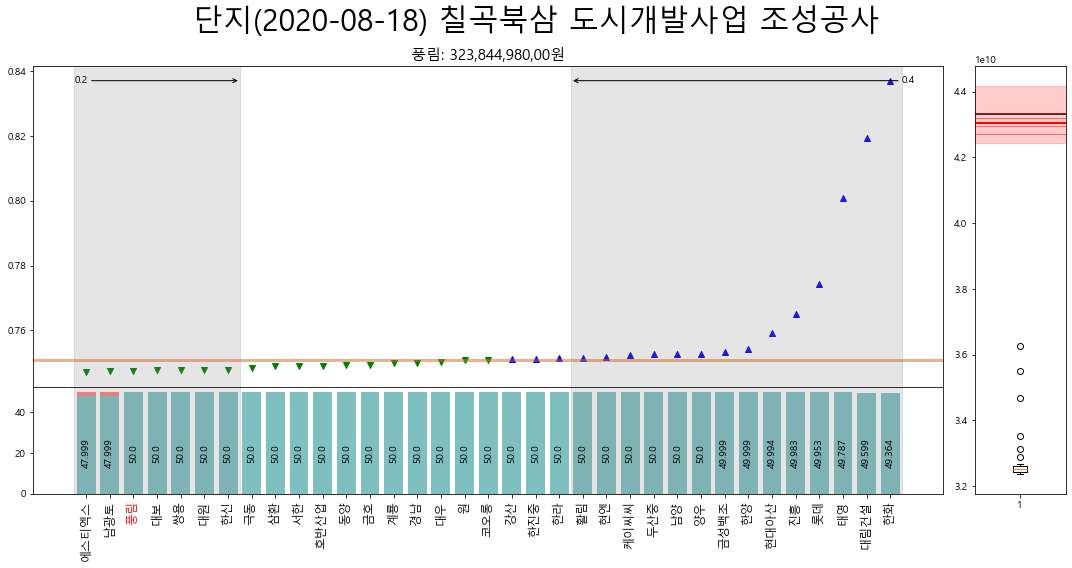

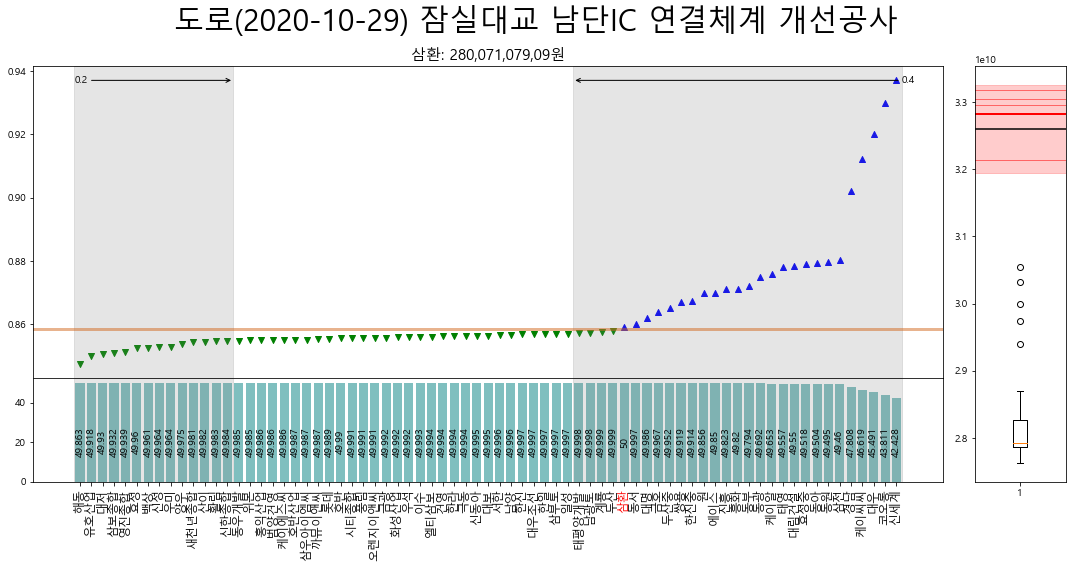

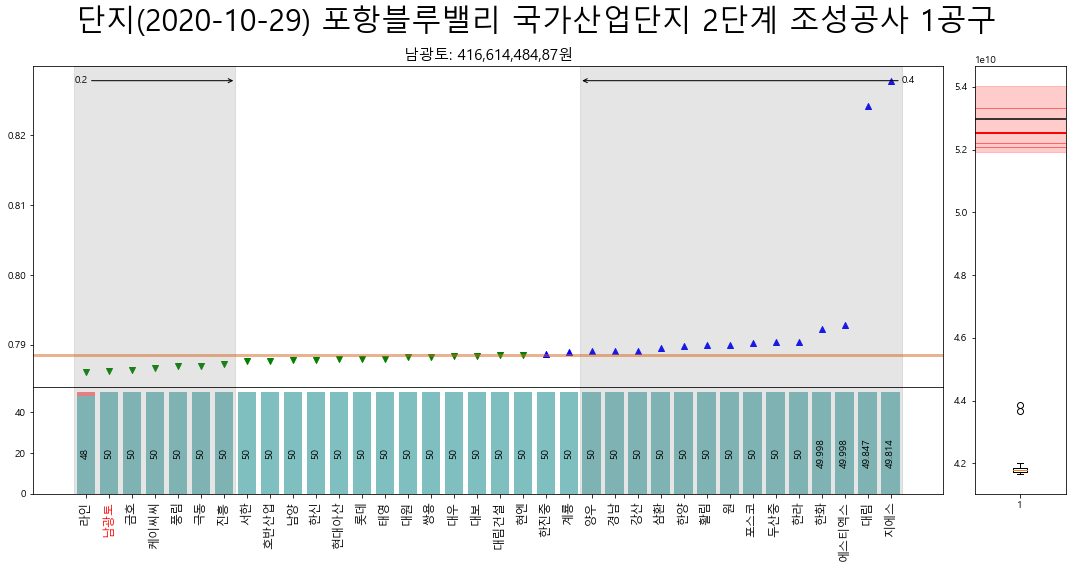

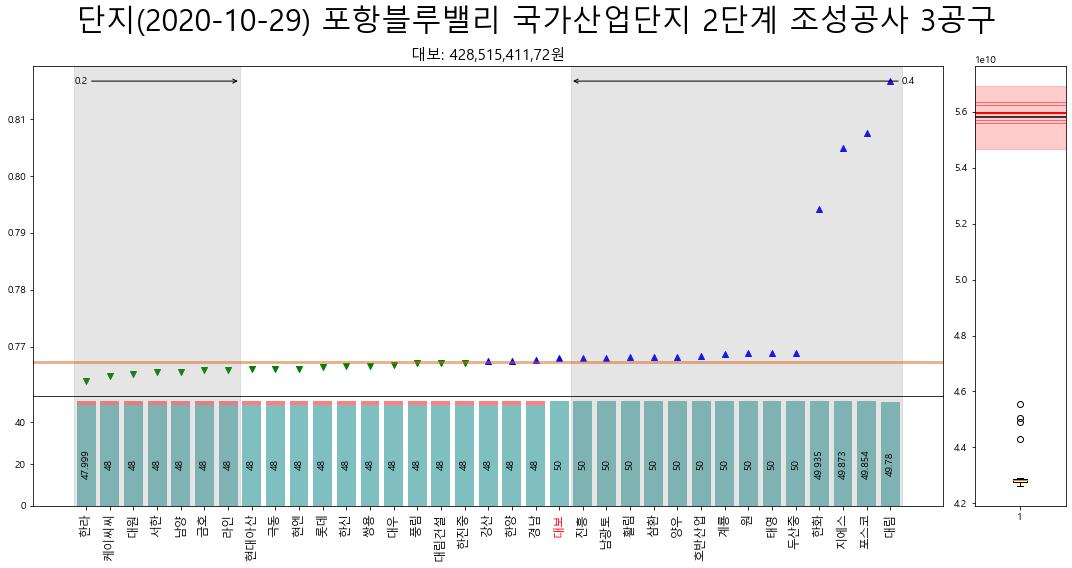

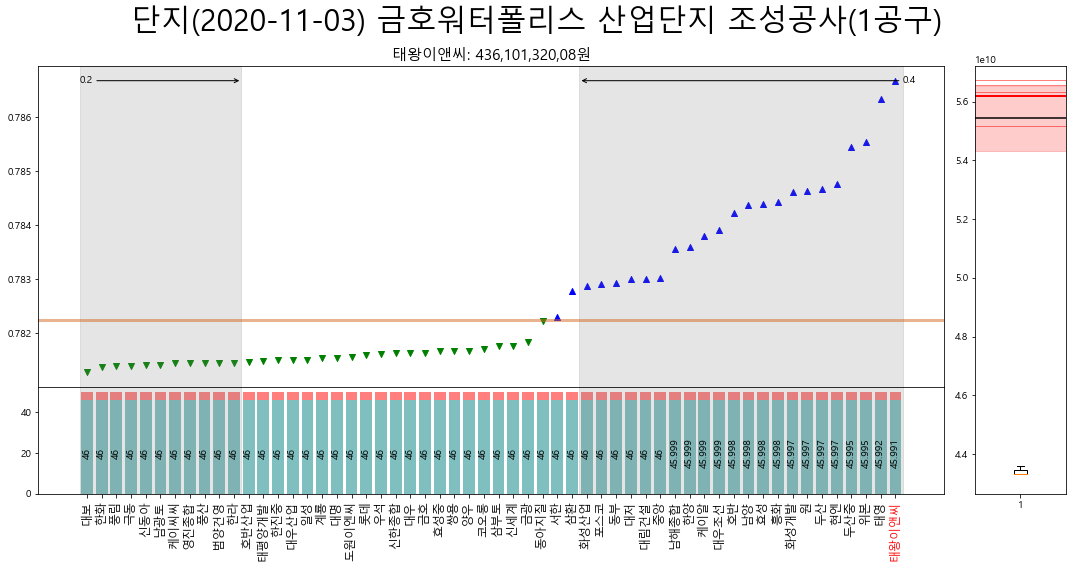

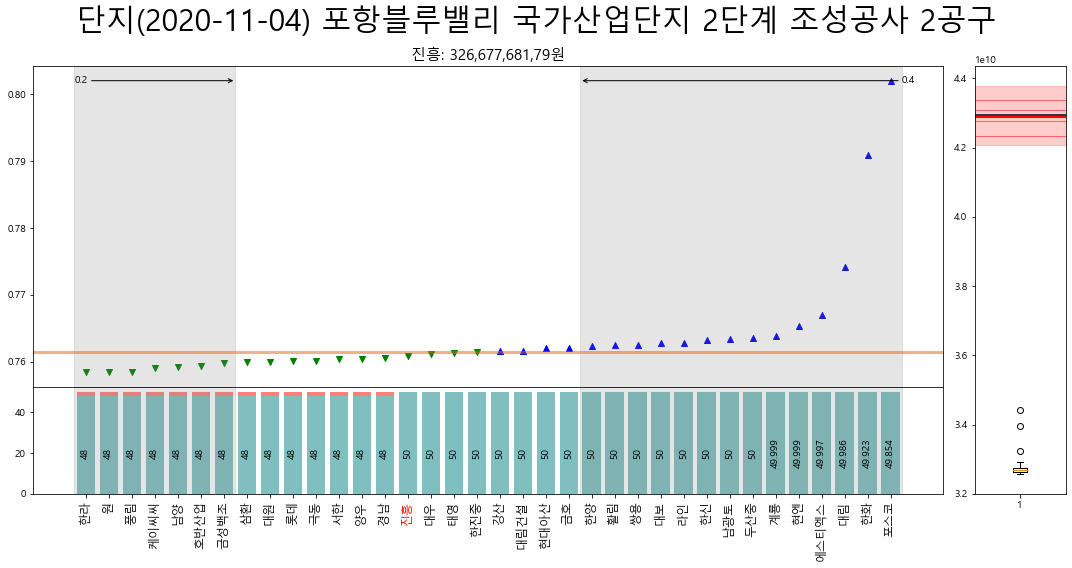

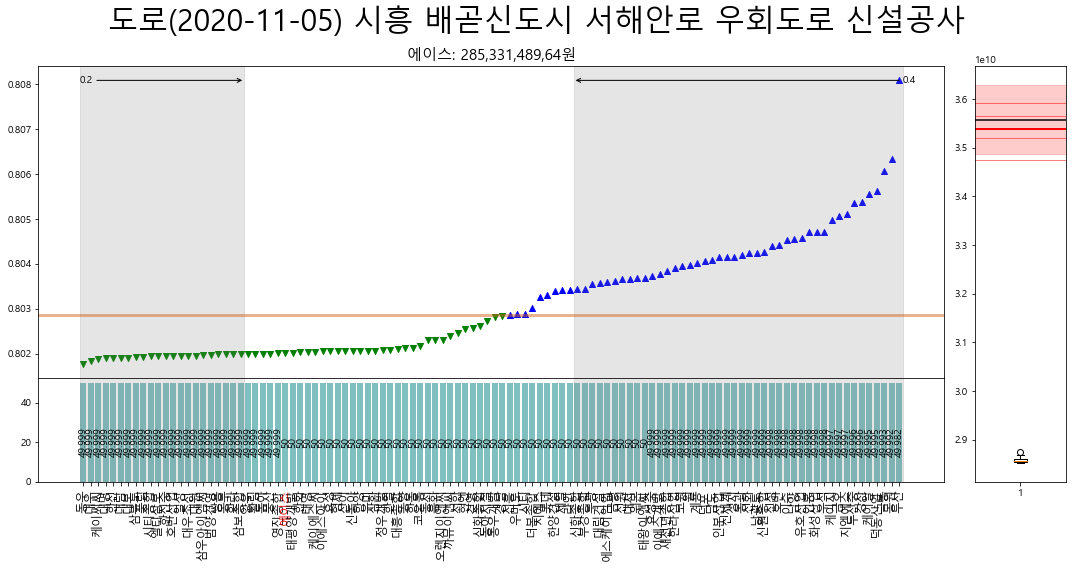

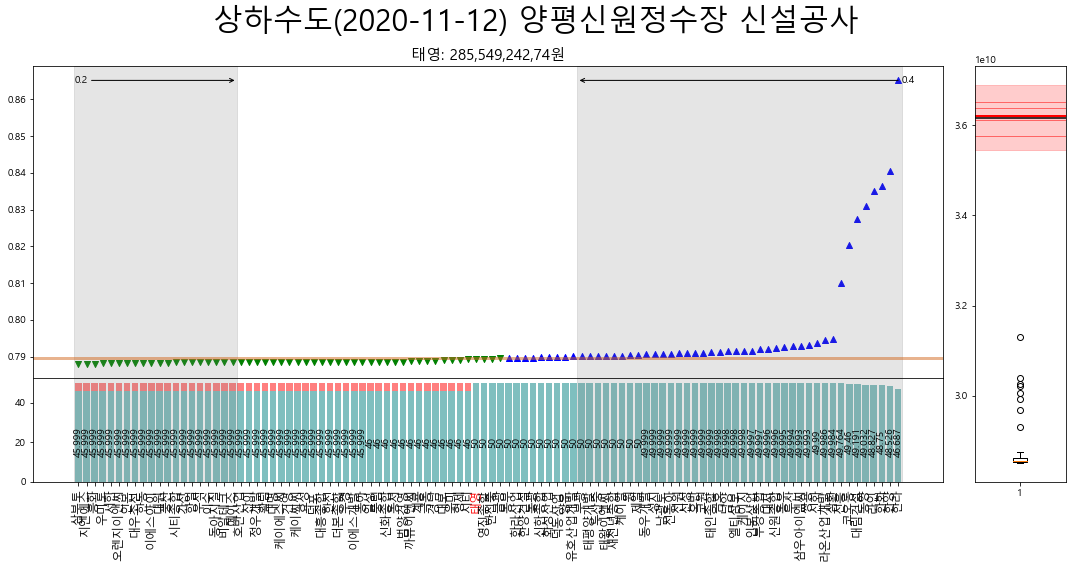

In [173]:
from matplotlib import gridspec
gs = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[3,1],width_ratios=[10,1])

for year in df_project_select['year'].unique().tolist():
    tmp = df_project_select[df_project_select['year']==year]
    for j,jj in enumerate(tmp.index.tolist()):
        df = pd.ExcelFile('입찰결과({}년).jj'.format(year))
        a = df.parse(tmp.loc[jj,'sheet_name'])
        project = tmp.iloc[j,3]
        date = tmp.iloc[j,tmp.columns.tolist().index('입찰일시')]
        date = date.strftime('%Y-%m-%d')
        category = tmp.iloc[j,tmp.columns.tolist().index('공종')]
        a.columns = np.arange(len(a.columns))
        gonggo = a.iloc[9,2]
        gicho = a.iloc[10,2]
        yega = a.iloc[11,2]
        yega = yega.split(' (')[0].replace(',','')
        gyunga = a.iloc[12,2]
        nakchal = df_project_select.iloc[jj,-2]
        nakchalga = df_project_select.iloc[jj,-1]
        a = df.parse(tmp.loc[jj,'sheet_name'],skiprows=17)
        if a.columns.tolist()[0] == '당사':
            a = df.parse(tmp.loc[jj,'sheet_name'],skiprows=16)
        if a.iloc[0,0] =='당사':
            a = a.drop([0])
            a.reset_index(drop=True, inplace=True)
        company, bid, score1, score2 = [],[],[],[]
        i=0
        while True:
            if i==0 and a.iloc[i,1] is np.nan:
                i+=1
                pass
            if i==1 and a.iloc[i,1] is np.nan:
                i+=1
                pass
            if a.iloc[i,1] is np.nan:
                break
            company.append(a.iloc[i,1])
            bid.append(a.iloc[i,2])
            try:
                score1.append(a.iloc[i,a.columns.tolist().index([x for x in a.columns.tolist() if '가격' and '(A)' in x][0])])
                score2.append(a.iloc[i,a.columns.tolist().index([x for x in a.columns.tolist() if '가격' and '(A)' in x][0])+2])
            except:
                if year in [2019,2020]:
                    score1.append(a.iloc[i,5])
                    score2.append(a.iloc[i,7])
                elif year in [2017,2018]:
                    score1.append(a.iloc[i,6])
                    score2.append(a.iloc[i,8])
            i+=1
        pct = [x/gicho for x in bid]
        if np.isnan(bid[0]):
            bid = bid[1:]
            pct = pct[1:]
            company = company[1:]
            score1 = score1[1:]
            score2 = score2[1:]
        n = a.iloc[:,1].tolist().index('예정가격')
        yega_list=a.iloc[n+1:n+1+4,1].tolist()
        nn = a.iloc[n,:].tolist().index('기초금액 대비')
        yega_list_pct = a.iloc[n+1:n+1+4,nn].tolist()
        gyunga_ratio_high, gyunga_ratio_row = get_pct(df_project_select.iloc[j,7])
        d1 = get_com(gyunga_ratio_row,company)
        d2 = get_com(gyunga_ratio_high, company)
        #if math.floor(np.mean(bid[d1:-d2])) == gyunga:
        #    print('YES')
        score_final = [x+y for x, y in zip(score1, score2)]
        #print(gonggo,gicho,yega,gyunga)
        
        tick_colors = ['black']*len(company)
        tick_colors[company.index(nakchal)] ='red'
        
        fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=False,figsize=(15,8))
        ax1 = plt.subplot(gs[0])
        #for i in np.arange(len(company)):
        for i,v in enumerate(company):
            if bid[i]<gyunga:
                marker='v'
                color='green'
            elif bid[i]>gyunga:
                marker='^'
                color='blue' 
            else:
                marker='o'
                color='black'
            ax1.scatter(i,pct[i], color=color,marker=marker)
        #ax1.scatter(np.arange(len(company)), pct, color='black',marker='.')
        m1 = ax1.axhline(gyunga/gicho, linewidth=3, alpha=0.5, color='chocolate', label='균형가격')
        ax1.axvspan(0-0.5,d1-0.5, color='grey', alpha=0.2)
        ax1.axvspan(len(company)-d2-0.5, len(company)-0.5, color='grey', alpha=0.2)

        ax1.annotate('{}'.format(gyunga_ratio_row),
                     xy=(d1-0.5,max(pct)), 
                     xytext=(0-0.5,max(pct)),arrowprops=dict(arrowstyle="->"), va='center')

        ax1.annotate('{}'.format(gyunga_ratio_high),
                     xy=(len(company)-d2-0.5,max(pct)), 
                     xytext=(len(company)-0.5,max(pct)),arrowprops=dict(arrowstyle="->"), va='center')
        plt.title('{}: {}'.format(nakchal,convert_won(nakchalga)), fontsize=15)
        ax2 = plt.subplot(gs[2])
        m2=ax2.bar(x=np.arange(len(company)),height=score1, alpha=0.5, color='red', label='가격심사점수')
        m3 = ax2.bar(x=np.arange(len(company)),height=score2, alpha=0.5, color='cyan',label='최종점수')
        ax2.axvspan(0-0.5,d1-0.5, color='grey', alpha=0.2)
        ax2.axvspan(len(company)-d2-0.5, len(company)-0.5, color='grey', alpha=0.2)
        for i,v in enumerate(score2):
            plt.annotate(round(v,3),(i,20), va='center',ha='center', rotation=90)
        plt.xticks(np.arange(len(company)),company, fontsize=12, rotation=90)

        for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), tick_colors):
            ticklabel.set_color(tickcolor)
        ax3 = plt.subplot(gs[0:,1])
        ax3.boxplot(bid)
        ax3.axhline(gicho, color='black')
        ax3.axhspan(gicho*0.98, gicho*1.02, color='red', alpha=0.2)
        for i,v in enumerate(yega_list):
            ax3.axhline(v,color='red', alpha=0.5, linewidth=1)
        ax3.axhline(np.mean(yega_list), color='red', linewidth=2)
        #plt.title('예정가격&투찰금액 분포', fontsize=15)

        plt.suptitle('{}({}) {}'.format(category,date,project), fontsize=30)
        plt.tight_layout()
        fig.subplots_adjust(hspace=0)
        plt.savefig('img_v2/fig_{}_{}.png'.format(year,project), dpi=1000)
        plt.show()

In [174]:
from PIL import Image
img_legend = Image.open('legend.png')
img_legend = img_legend.resize((366*3,521*3))
for i in os.listdir('img_v2/'):
    img = Image.open('img_v2/{}'.format(i))
    from PIL import Image
    new_im = Image.new('RGB', (img.size[0]+img_legend.size[0],img.size[1]+img_legend.size[1]),(255, 255, 255))
    new_im.paste(img)
    new_im.paste(img_legend,(15000,1000))
    new_im.save('img_v2/{}'.format(i))

In [127]:
from PIL import Image
new_im = Image.new('RGB', (img.size[0]+img_legend.size[0],img.size[1]+img_legend.size[1]),(255, 255, 255))
new_im.paste(img)
new_im.paste(img_legend,(15000,1000))

In [128]:
new_im

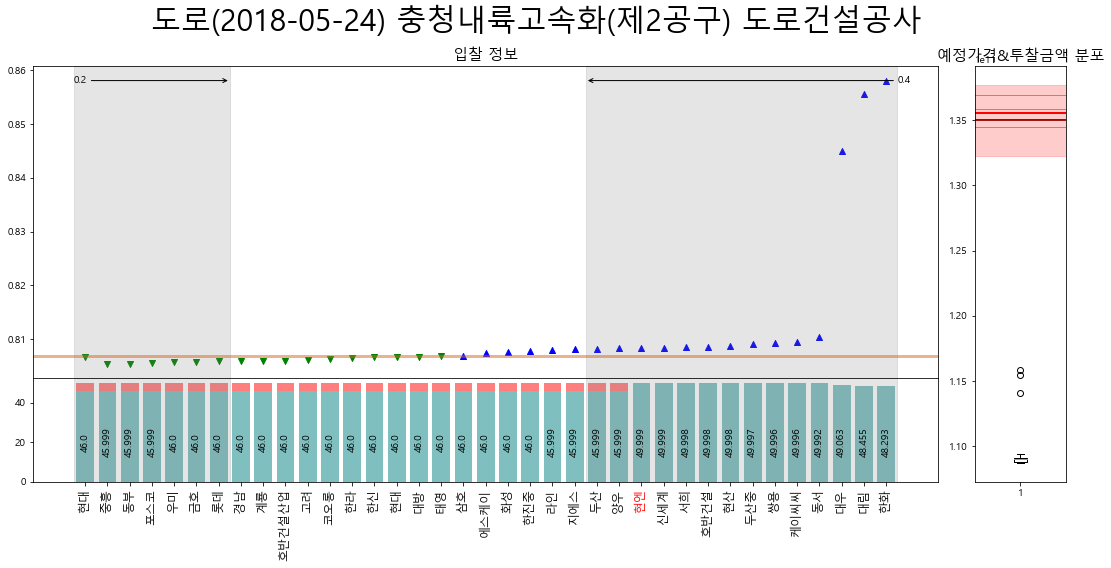

In [53]:
from matplotlib import gridspec
gs = gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[3,1],width_ratios=[10,1])
year=2018
j=16
jj=32
tmp = df_project_select[df_project_select['year']==year]
df = pd.ExcelFile('입찰결과({}년).jj'.format(year))
a = df.parse('충청내륙2공구')
project = tmp.iloc[j,3]
date = tmp.iloc[j,2]
category = tmp.iloc[j,7]
a.columns = np.arange(len(a.columns))
gonggo = a.iloc[9,2]
gicho = a.iloc[10,2]
yega = a.iloc[11,2]
yega = yega.split(' (')[0].replace(',','')
gyunga = a.iloc[12,2]
nakchal = df_project_select.iloc[jj,-1]
a = df.parse(tmp.loc[jj,'sheet_name'],skiprows=17)
a.columns.tolist().index([x for x in a.columns.tolist() if '가격' in x][0])

if a.columns.tolist()[0] == '당사':
    a = df.parse(tmp.loc[jj,'sheet_name'],skiprows=16)
company, bid, score1, score2 = [],[],[],[]
i=0
while True:
    if i==0 and a.iloc[i,1] is np.nan:
        i+=1
        pass
    if i==1 and a.iloc[i,1] is np.nan:
        i+=1
        pass
    if a.iloc[i,1] is np.nan:
        break
    company.append(a.iloc[i,1])
    bid.append(a.iloc[i,2])
    score1.append(a.iloc[i,a.columns.tolist().index([x for x in a.columns.tolist() if '가격' in x][0])])
    score2.append(a.iloc[i,a.columns.tolist().index([x for x in a.columns.tolist() if '가격' in x][0])+2])
#     if year in [2019,2020]:
#         score1.append(a.iloc[i,5])
#         score2.append(a.iloc[i,7])
#     elif year in [2017,2018]:
#         score1.append(a.iloc[i,6])
#         score2.append(a.iloc[i,8])
    i+=1
pct = [x/gicho for x in bid]
if np.isnan(bid[0]):
    bid = bid[1:]
    pct = pct[1:]
    company = company[1:]
    score1 = score1[1:]
    score2 = score2[1:]
n = a.iloc[:,1].tolist().index('예정가격')
yega_list=a.iloc[n+1:n+1+4,1].tolist()
nn = a.iloc[n,:].tolist().index('기초금액 대비')
yega_list_pct = a.iloc[n+1:n+1+4,nn].tolist()
gyunga_ratio_high, gyunga_ratio_row = get_pct(df_project_select.iloc[j,8])
d1 = get_com(gyunga_ratio_row,company)
d2 = get_com(gyunga_ratio_high, company)
#if math.floor(np.mean(bid[d1:-d2])) == gyunga:
#    print('YES')
score_final = [x+y for x, y in zip(score1, score2)]
#print(gonggo,gicho,yega,gyunga)

tick_colors = ['black']*len(company)
tick_colors[company.index(nakchal)] ='red'

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=False,figsize=(15,8))
ax1 = plt.subplot(gs[0])
#for i in np.arange(len(company)):
for i,v in enumerate(company):
    if bid[i]<gyunga:
        marker='v'
        color='green'
    elif bid[i]>gyunga:
        marker='^'
        color='blue' 
    else:
        marker='o'
        color='black'
    ax1.scatter(i,pct[i], color=color,marker=marker)
#ax1.scatter(np.arange(len(company)), pct, color='black',marker='.')
m1 = ax1.axhline(gyunga/gicho, linewidth=3, alpha=0.5, color='chocolate', label='균형가격')
ax1.axvspan(0-0.5,d1-0.5, color='grey', alpha=0.2)
ax1.axvspan(len(company)-d2-0.5, len(company)-0.5, color='grey', alpha=0.2)

ax1.annotate('{}'.format(gyunga_ratio_row),
             xy=(d1-0.5,max(pct)), 
             xytext=(0-0.5,max(pct)),arrowprops=dict(arrowstyle="->"), va='center')

ax1.annotate('{}'.format(gyunga_ratio_high),
             xy=(len(company)-d2-0.5,max(pct)), 
             xytext=(len(company)-0.5,max(pct)),arrowprops=dict(arrowstyle="->"), va='center')
plt.title('입찰 정보', fontsize=15)
ax2 = plt.subplot(gs[2])
m2=ax2.bar(x=np.arange(len(company)),height=score1, alpha=0.5, color='red', label='가격심사점수')
m3 = ax2.bar(x=np.arange(len(company)),height=score2, alpha=0.5, color='cyan',label='최종점수')
ax2.axvspan(0-0.5,d1-0.5, color='grey', alpha=0.2)
ax2.axvspan(len(company)-d2-0.5, len(company)-0.5, color='grey', alpha=0.2)
for i,v in enumerate(score2):
    plt.annotate(round(v,3),(i,20), va='center',ha='center', rotation=90)
plt.xticks(np.arange(len(company)),company, fontsize=12, rotation=90)

for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), tick_colors):
    ticklabel.set_color(tickcolor)
ax3 = plt.subplot(gs[0:,1])
ax3.boxplot(bid)
ax3.axhline(gicho, color='black')
ax3.axhspan(gicho*0.98, gicho*1.02, color='red', alpha=0.2)
for i,v in enumerate(yega_list):
    ax3.axhline(v,color='red', alpha=0.5, linewidth=1)
ax3.axhline(np.mean(yega_list), color='red', linewidth=2)
plt.title('예정가격&투찰금액 분포', fontsize=15)

plt.suptitle('{}({}) {}'.format(category,date,project), fontsize=30)
plt.tight_layout()
fig.subplots_adjust(hspace=0)
plt.savefig('img_v2/fig_{}_{}.png'.format(year,project), dpi=1000)
plt.show()

In [52]:
a.columns.tolist().index([x for x in a.columns.tolist() if '가격' in x][0])

5

In [34]:
jj

'충청내륙2공구'

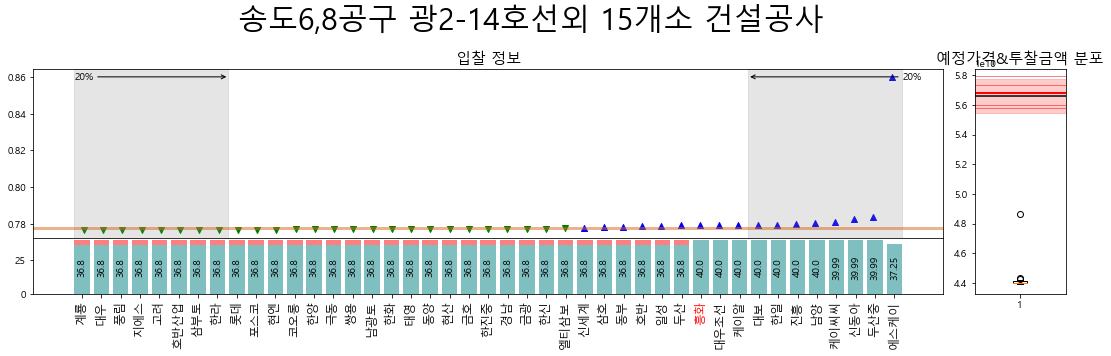

In [596]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=False,figsize=(15,5))
ax1 = plt.subplot(gs[0])
for i in np.arange(len(company)):
    if bid[i]<gyunga:
        marker='v'
        color='green'
    elif bid[i]>gyunga:
        marker='^'
        color='blue' 
    else:
        marker='o'
        coor='black'
    ax1.scatter(i,pct[i], color=color,marker=marker)
#ax1.scatter(np.arange(len(company)), pct, color='black',marker='.')
m1 = ax1.axhline(gyunga/gicho, linewidth=3, alpha=0.5, color='chocolate', label='균형가격')
ax1.axvspan(0-0.5,math.floor(len(company)*cal(gyunga_ratio_low))-0.5, color='grey', alpha=0.2)
ax1.axvspan(len(company)-math.floor(len(company)*cal(gyunga_ratio_high))-0.5, len(company)-0.5, color='grey', alpha=0.2)

ax1.annotate('{}'.format(gyunga_ratio_low),
             xy=(math.floor(len(company)*cal(gyunga_ratio_low))-0.5,max(pct)), 
             xytext=(0-0.5,max(pct)),arrowprops=dict(arrowstyle="->"), va='center')

ax1.annotate('{}'.format(gyunga_ratio_high),
             xy=(len(company)-math.floor(len(company)*cal(gyunga_ratio_high))-0.5,max(pct)), 
             xytext=(len(company)-0.5,max(pct)),arrowprops=dict(arrowstyle="->"), va='center')
plt.title('입찰 정보', fontsize=15)
ax2 = plt.subplot(gs[2])
m2=ax2.bar(x=company,height=score1, alpha=0.5, color='red', label='가격심사점수')
m3 = ax2.bar(x=company,height=score_final, alpha=0.5, color='cyan',label='최종점수')
for i,v in enumerate(score_final):
    plt.annotate(round(v,2),(i,20), va='center',ha='center', rotation=90)
plt.xticks(np.arange(len(company)),company, fontsize=12, rotation=90)

for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), tick_colors):
    ticklabel.set_color(tickcolor)
ax3 = plt.subplot(gs[0:,1])
ax3.boxplot(bid)
ax3.axhline(gicho, color='black')
ax3.axhspan(gicho*0.98, gicho*1.02, color='red', alpha=0.2)
for i,v in enumerate(yega_list):
    ax3.axhline(v,color='red', alpha=0.5, linewidth=1)
ax3.axhline(np.mean(yega_list), color='red', linewidth=2)
plt.title('예정가격&투찰금액 분포', fontsize=15)

plt.suptitle(project, fontsize=30)
#m1 = mpatches.Patch(label='균형가격', color='chocolate', hatch='-')
#m2 = mpatches.Patch(label='균현가격>입찰가격', color='blue', hatch='^')
#m3 = mpatches.Patch(label='균현가격<입찰가격', color='green', hatch='v')
#plt.legend(handles=[m1,m2,m3], bbox_to_anchor=(1.05, 1))
plt.tight_layout()
fig.subplots_adjust(hspace=0)
plt.savefig('fig1.png', dpi=1000)
plt.show()

In [66]:
df_com = pd.DataFrame([])
for p in tqdm(df.sheet_names):
    a = df.parse(p)
    #project = a.iloc[6,2]
    a.columns = np.arange(len(a.columns))
    gicho = a.iloc[10,2]
    company,pct =[],[]
    i=18
    while True:
        if a.iloc[i,1] is np.nan:
            break
        company.append(a.iloc[i,1])
        pct.append(a.iloc[i,8])
        i+=1
    tmp = pd.DataFrame([company, pct]).T
    tmp.columns=['업체명','입찰/기초']
    tmp['공사명'] = p
    tmp['기초금액'] = gicho
    df_com = pd.concat([df_com,tmp])

100%|█████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 129.11it/s]


In [443]:
[[x,y,i,j] for x,y,i,j in zip(company, pct,[project]*len(company), [category]*len(company))]

[['삼부토', 0.788042930752018, '양평신원정수장 신설공사', '상하수도'],
 ['지엔에스', 0.7880602647259988, '양평신원정수장 신설공사', '상하수도'],
 ['흥화', 0.7880851297725794, '양평신원정수장 신설공사', '상하수도'],
 ['우미토', 0.7882894089418977, '양평신원정수장 신설공사', '상하수도'],
 ['서한', 0.7883057049508816, '양평신원정수장 신설공사', '상하수도'],
 ['오렌지이앤씨', 0.7883297292306093, '양평신원정수장 신설공사', '상하수도'],
 ['인본', 0.7883386406349266, '양평신원정수장 신설공사', '상하수도'],
 ['대우조선', 0.7883506018787042, '양평신원정수장 신설공사', '상하수도'],
 ['한동', 0.7883513483177752, '양평신원정수장 신설공사', '상하수도'],
 ['이에스아이', 0.7883558678681203, '양평신원정수장 신설공사', '상하수도'],
 ['대원', 0.7883616558672599, '양평신원정수장 신설공사', '상하수도'],
 ['풍산', 0.7883691577457982, '양평신원정수장 신설공사', '상하수도'],
 ['시티종합', 0.7883830336887305, '양평신원정수장 신설공사', '상하수도'],
 ['가산', 0.788387699154091, '양평신원정수장 신설공사', '상하수도'],
 ['한일', 0.7883961812453589, '양평신원정수장 신설공사', '상하수도'],
 ['우석', 0.788397000033728, '양평신원정수장 신설공사', '상하수도'],
 ['이수', 0.7884033013064895, '양평신원정수장 신설공사', '상하수도'],
 ['동아지질', 0.7884050366391, '양평신원정수장 신설공사', '상하수도'],
 ['비알테크', 0.7884127941868431, '양평신원

In [444]:
df_com = []
for year in df_project_select['year'].unique().tolist():
    tmp = df_project_select[df_project_select['year']==year]
    for j,jj in enumerate(tmp.index.tolist()):
        df = pd.ExcelFile('입찰결과({}년).jj'.format(year))
        a = df.parse(tmp.loc[jj,'sheet_name'])
        project = tmp.iloc[j,3]
        date = tmp.iloc[j,2]
        category = tmp.iloc[j,7]
        a.columns = np.arange(len(a.columns))
        #gonggo = a.iloc[9,2]
        gicho = a.iloc[10,2]
#         yega = a.iloc[11,2]
#         yega = yega.split(' (')[0].replace(',','')
#         gyunga = a.iloc[12,2]
#         nakchal = df_project_select.iloc[jj,-1]
        a = df.parse(tmp.loc[jj,'sheet_name'],skiprows=17)
        if a.columns.tolist()[0] == '당사':
            a = df.parse(tmp.loc[jj,'sheet_name'],skiprows=16)
        company, bid, score1, score2 = [],[],[],[]
        i=0
        while True:
            if i==0 and a.iloc[i,1] is np.nan:
                i+=1
                pass
            if i==1 and a.iloc[i,1] is np.nan:
                i+=1
                pass
            if a.iloc[i,1] is np.nan:
                break
            company.append(a.iloc[i,1])
            bid.append(a.iloc[i,2])
            i+=1
        pct = [x/gicho for x in bid]
        if np.isnan(bid[0]):
            bid = bid[1:]
            pct = pct[1:]
            company = company[1:]
#             score1 = score1[1:]
#             score2 = score2[1:]
        df_com = df_com+[[x,y,i,j] for x,y,i,j in zip(company, pct,[project]*len(company), [category]*len(company))]

In [448]:
df_com = pd.DataFrame(df_com, columns=['업체명','입찰/기초','공사명','공종'])

In [449]:
tmp = df_com['업체명'].value_counts()

df_com_ = df_com[df_com['업체명'].isin(tmp[tmp>1].index.tolist())]

In [455]:
tmp = df_com_[['공종','공사명']].drop_duplicates(keep='first')['공종'].value_counts()
list_select = tmp.index.tolist()[0:4]

In [461]:
list(set(df_com_['공종']))

['단지', '도로', '상하수도', '철도', '지하철', '시설', '고속도로', '기타', '항만']

In [502]:
get_sizecolor(0.5)

(1, 'grey')

In [549]:
min(df_com_['입찰/기초'])

0.7249986334269563

In [550]:
def get_sizecolor(x):
    if x <= 0.8:
        size=6
        color='grey'
    elif 0.8 < x <= 0.9:
        size=9
        color='blue'
    elif x > 0.9:
        size=12
        color='red'
    return size, color

def get_shape(x):
    if x =='단지':
        return '.'
    elif x == '도로':
        return 'v'
    elif x == '상하수도':
        return '^'
    elif x == '철도':
        return 's'
    elif x == '지하철':
        return 'h'
    elif x == '시설':
        return 'x'
    elif x == '고속도로':
        return 'D'
    elif x == '기타':
        return '*'
    elif x == '항만':
        return 'p'

In [489]:
df_com_.sort_values(by='공종',inplace=True)
df_com_.reset_index(drop=True, inplace=True)

In [490]:
dict_project={}
for i,v in enumerate(df_com_['공사명'].unique().tolist()):
    dict_project[v] = i
dict_company = {}
for i,v in enumerate(df_com_['업체명'].unique().tolist()):
    dict_company[v]=i

In [ ]:
def span()

In [523]:
list_cat = df_com_[['공종','공사명']].drop_duplicates(keep='first')['공종'].value_counts().index.tolist()

In [526]:
list_cat

['고속도로', '단지', '도로', '항만', '철도', '기타', '상하수도', '시설', '지하철']

In [535]:
def get_line(cat):
    list_x = df_com_[df_com_['공종']==cat]['공사명'].tolist()
    a = [dict_project[x] for x in list_x]
    return min(a), max(a)

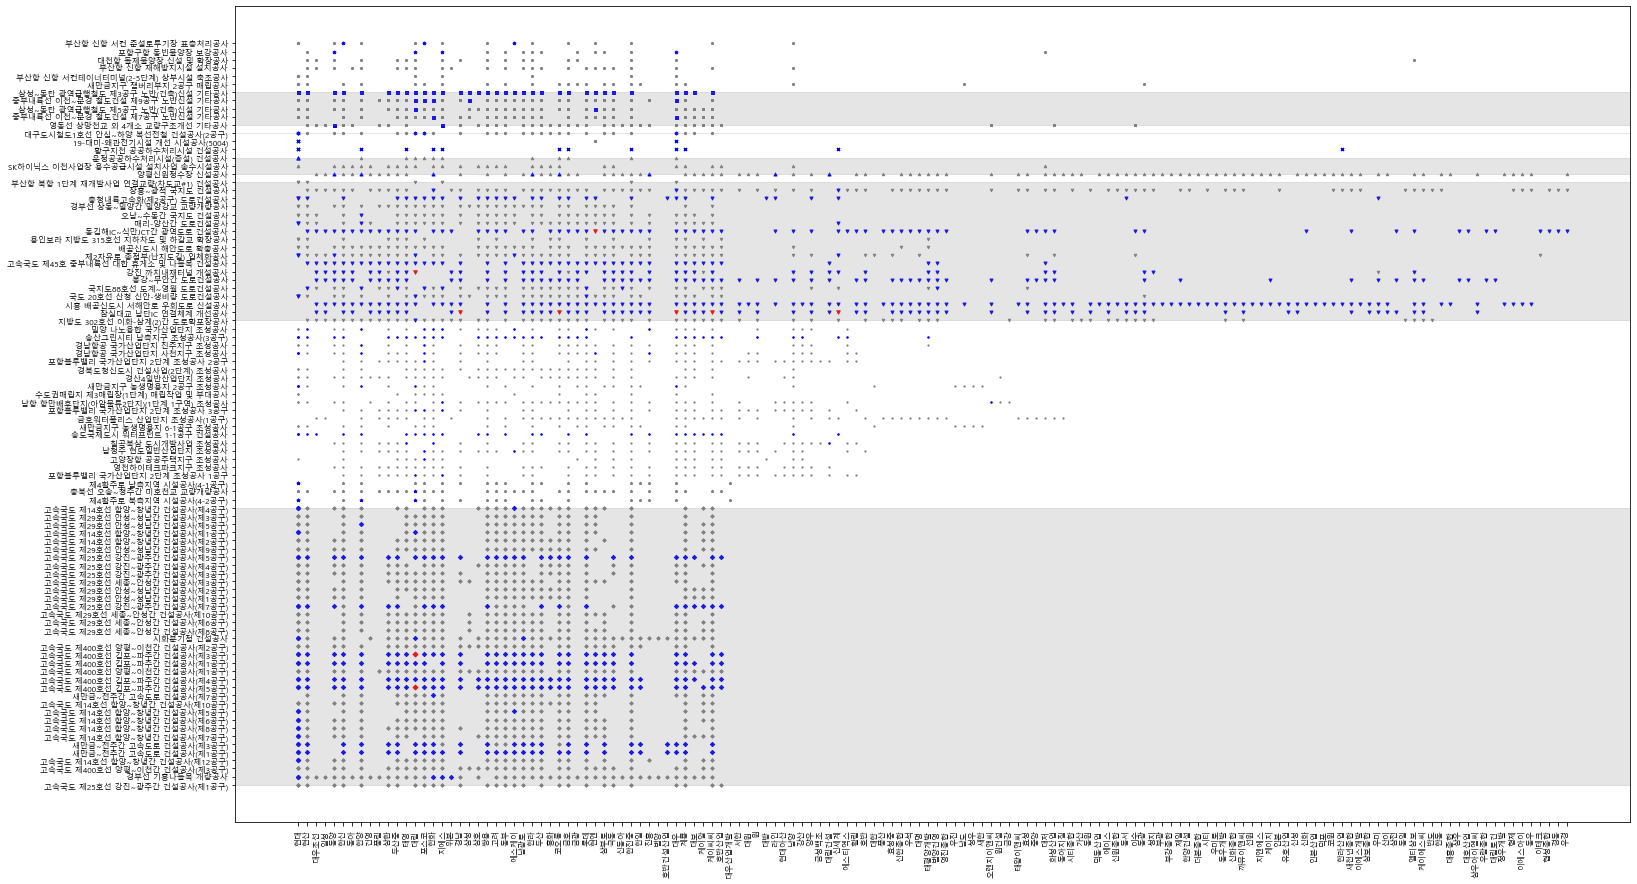

In [551]:
fig = plt.figure(figsize=(25,15))
for i,v in enumerate(list_cat):
    if i % 2 == 0:
        plt.axhspan(get_line(v)[0], get_line(v)[1], color='grey', alpha=0.2)
for i in df_com_.index.tolist():
    x = dict_company[df_com_.iloc[i,0]]
    y = dict_project[df_com_.iloc[i,2]]
    marker = get_shape(df_com_.iloc[i,3])
    size = get_sizecolor(df_com_.iloc[i,1])[0]
    color = get_sizecolor(df_com_.iloc[i,1])[1]
    plt.scatter(x,y,marker=marker, s=size, color=color)

plt.xticks(np.arange(len(dict_company.keys())), list(dict_company.keys()), size=8, rotation=90)
plt.yticks(np.arange(len(dict_project.keys())), list(dict_project.keys()), size=8)
plt.savefig('fig2_all.png', dpi=1000)
plt.show()

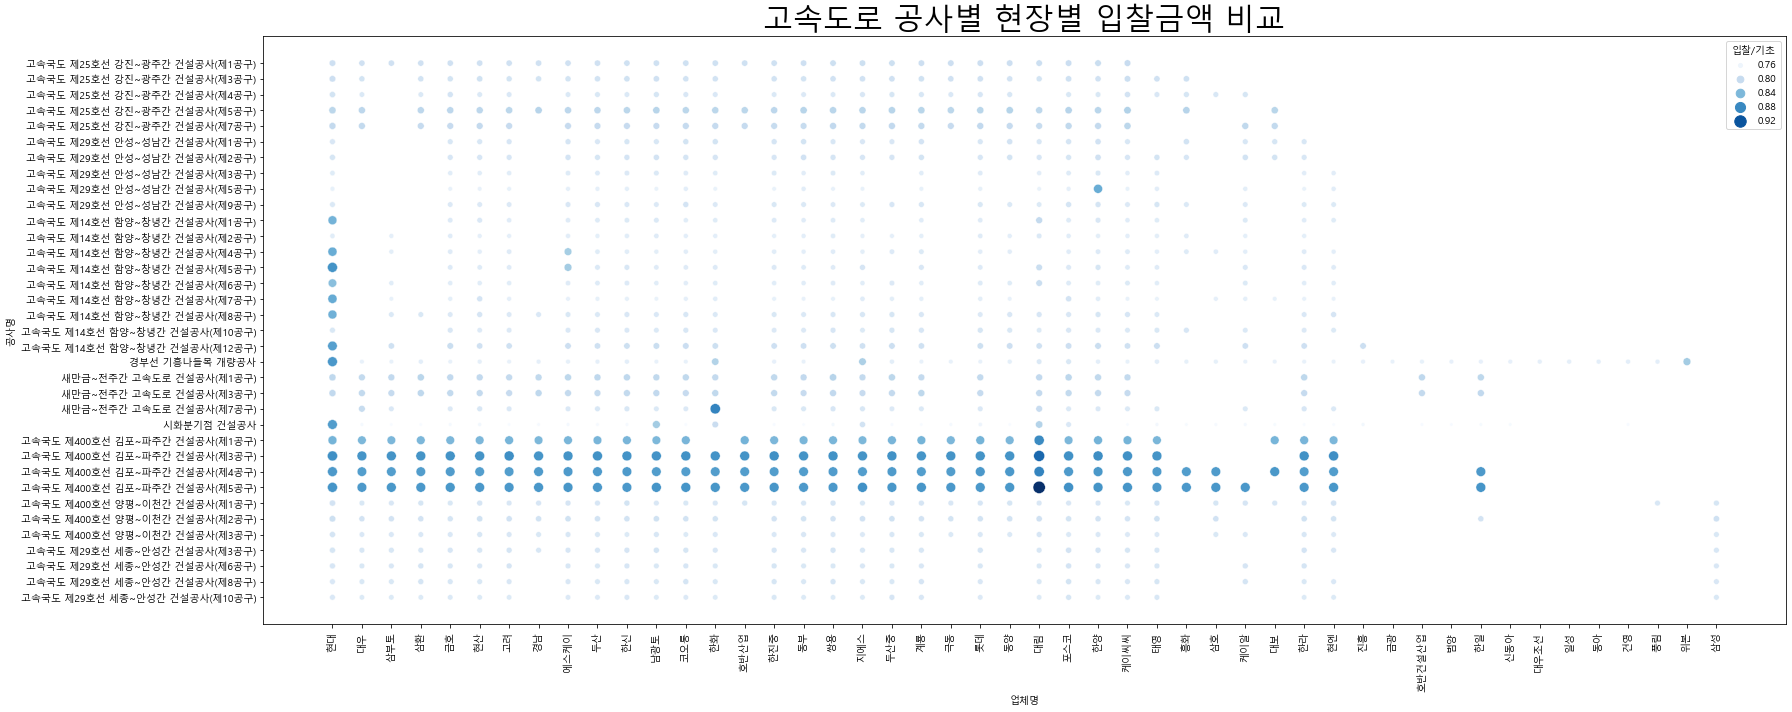

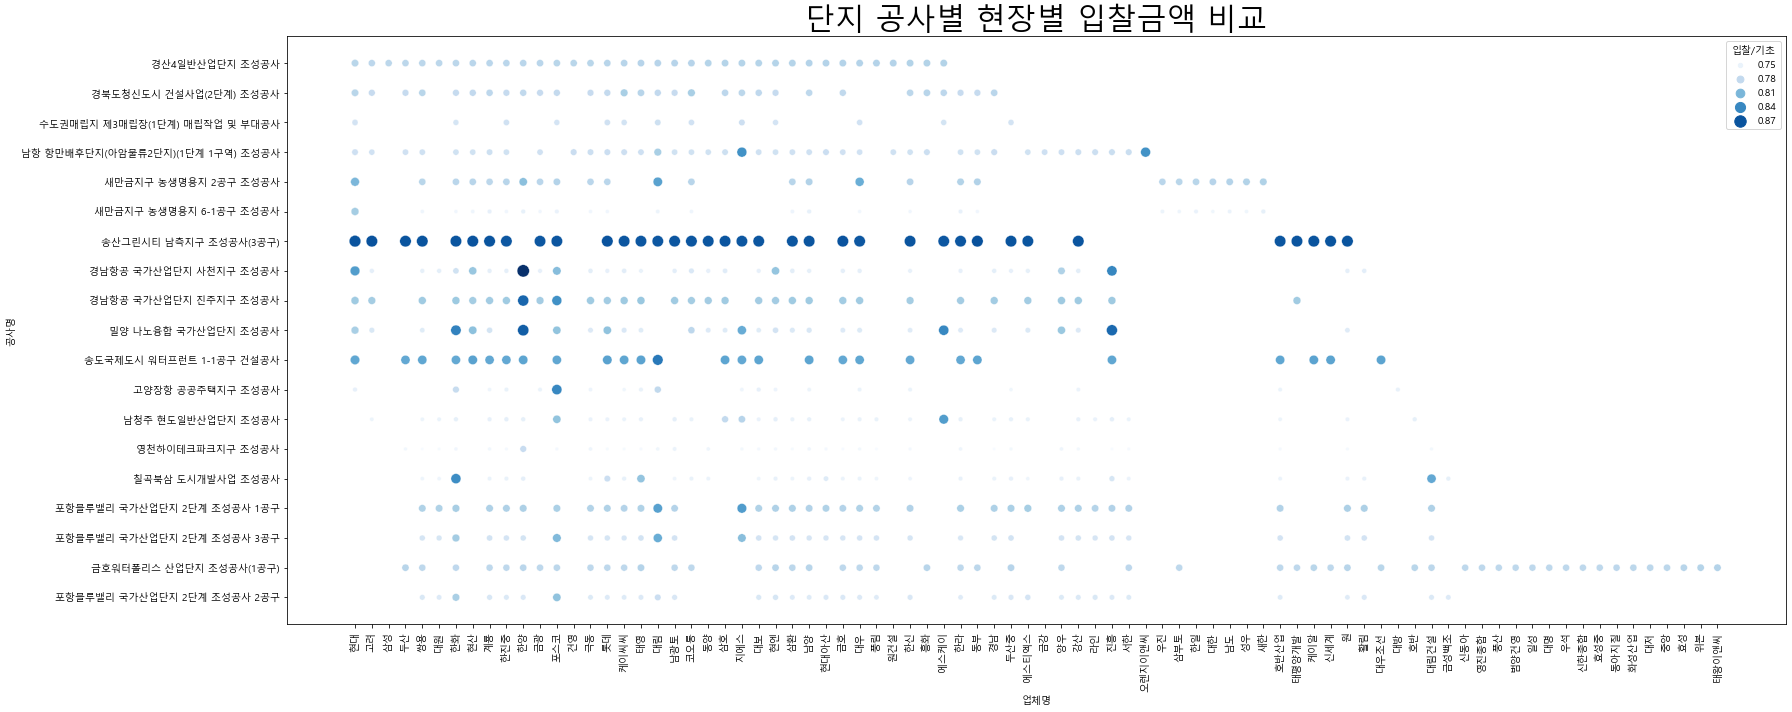

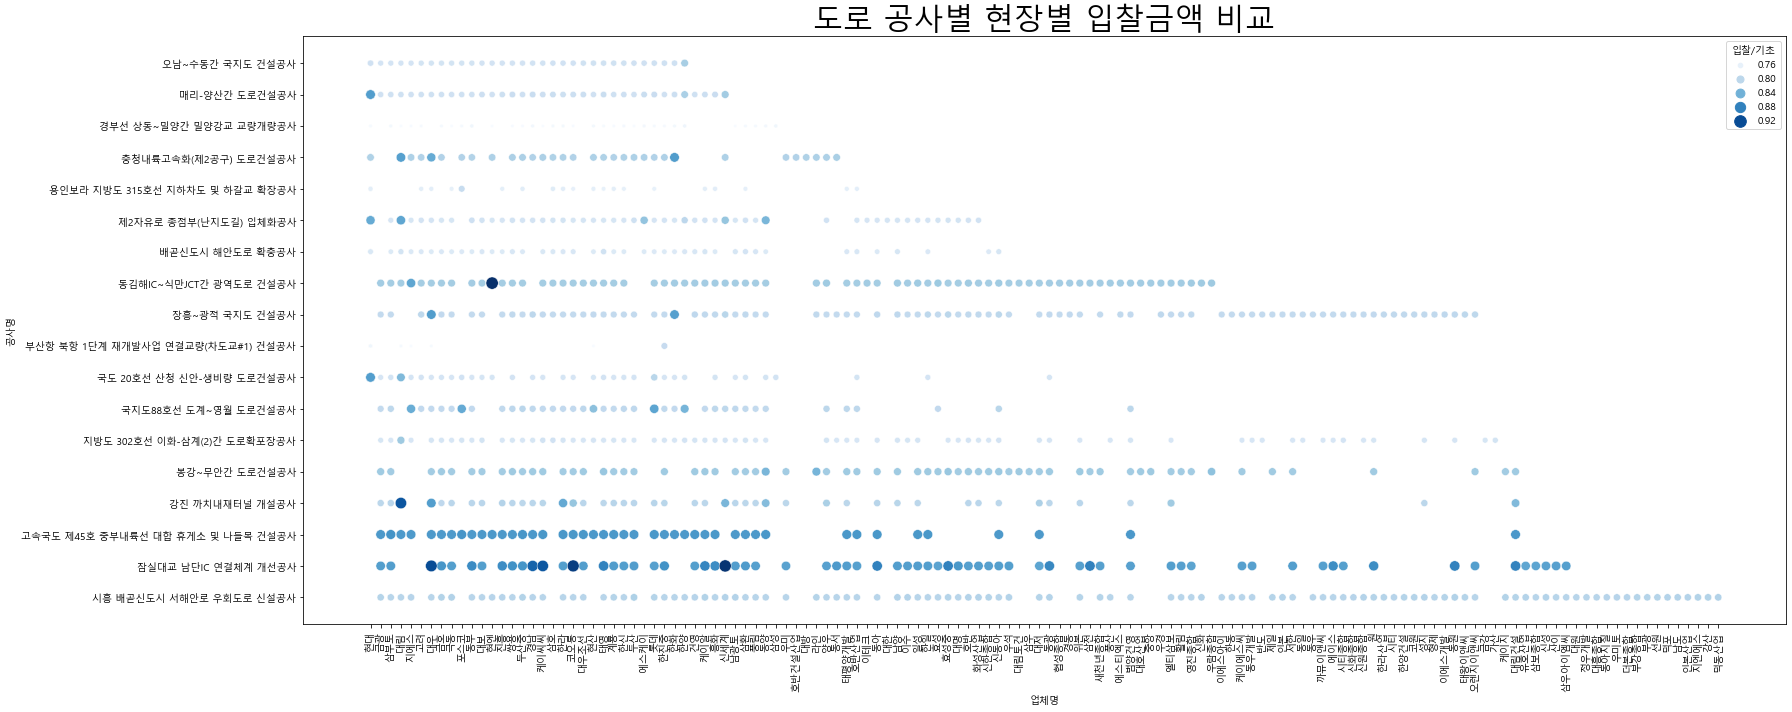

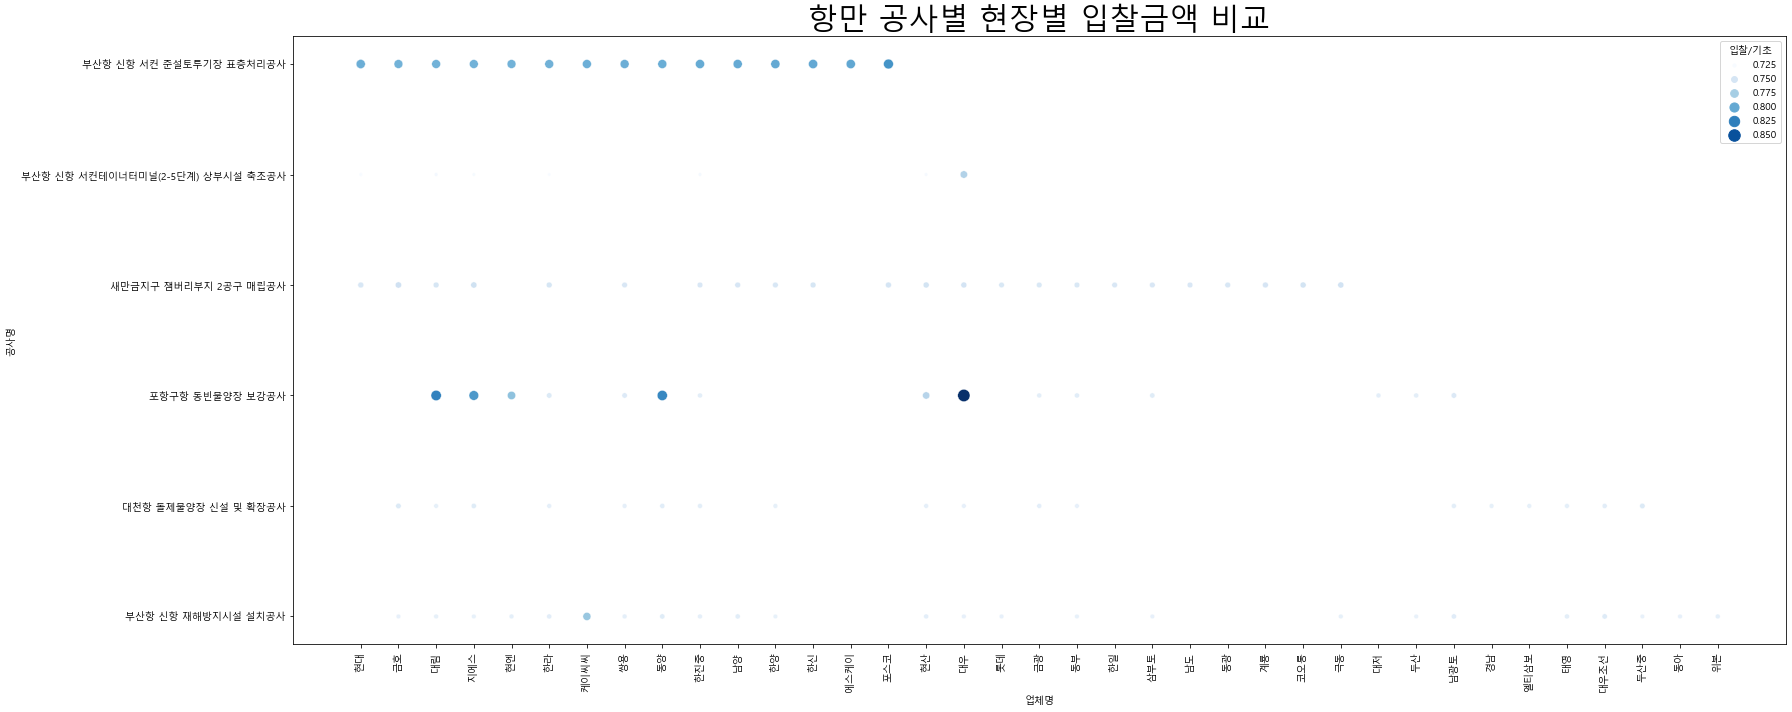

In [457]:
for i in df_com_.index.tolist():
    tmp = df_com_[df_com_['공종']==cat]
    fig = plt.figure(figsize=(25,10))
    sns.scatterplot(x=tmp['업체명'],y=tmp['공사명'], size=tmp['입찰/기초'], hue=tmp['입찰/기초'],sizes=(10, 150), palette='Blues')
    plt.xticks(fontsize=10,rotation=90)
    plt.yticks(fontsize=10)
    plt.title('{} 공사별 현장별 입찰금액 비교'.format(cat), fontsize=30)
    plt.tight_layout()
    plt.savefig('fig2_{}.png'.format(cat), dpi=1000)
    plt.show()

In [34]:
tmp = df_com[df_com['공사명']=='송도68공구']['업체명'].unique().tolist()
df_com[df_com['업체명'].isin(tmp)]['업체명'].value_counts()

한진중     45
쌍용      44
한라      43
대우      41
금호      38
케이씨씨    37
남광토     37
태영      36
동부      36
계룡      36
코오롱     33
극동      33
한신      33
경남      32
두산중     32
롯데      31
진흥      30
두산      30
호반산업    29
지에스     29
대보      29
삼부토     29
풍림      28
한화      27
금광      27
대우조선    26
동양      25
남양      25
한양      24
케이알     23
현산      23
흥화      21
신동아     20
현엔      19
포스코     19
한일      18
일성      17
엘티삼보    17
호반      16
신세계     16
고려      12
삼호      11
에스케이     4
Name: 업체명, dtype: int64

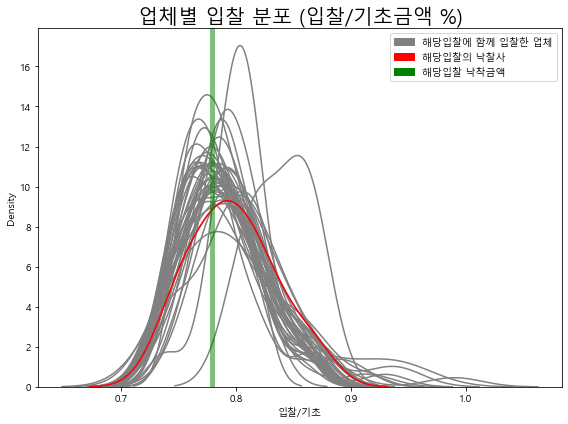

In [61]:
fig = plt.figure(figsize=(8,6))
for i in tmp:
    sns.distplot(df_com[df_com['업체명']==i]['입찰/기초'].tolist(), hist=False, color='grey', bins=30)
sns.distplot(df_com_[df_com_['업체명']=='흥화']['입찰/기초'],hist=False, color='red')
m1 = mpatches.Patch(label='해당입찰에 함께 입찰한 업체', color='grey')
m2 = mpatches.Patch(label='해당입찰의 낙찰사', color='red')
m3 = mpatches.Patch(label='해당입찰 낙착금액', color='green')
plt.axvline(0.779, color='green', linewidth=5, alpha=0.5)
plt.legend(handles=[m1,m2,m3])
plt.title('업체별 입찰 분포 (입찰/기초금액 %)', fontsize=20)
plt.tight_layout()
plt.savefig('fig3.png', dpi=1000)
plt.show()

In [64]:
df_main[df_main['낙찰사']=='흥화']

순    입찰년도                 입찰일시    공종                           공사명  \
86    85  2017.0  2017-07-24 00:00:00  고속도로  고속국도 제25호선 강진~광주간 건설공사(제3공구)   
284  283  2020.0  2020-05-20 10:00:00    도로    송도6,8공구 광2-14호선외 15개소 건설공사   

                수요처   발주처 가격심사\nA/B계수 균형가격\n산정방법\n(20개초과) 입찰\n참여\n여부 PQ\n통과사  \
86             도로공사  도로공사       0.5/1             40%/20%         참여      28   
284  인천광역시\n경제자유구역청   조달청         1/1             20%/20%         불참      43   

    입찰\n방법 Unnamed: 12          공고금액          기초금액          선정예가      예가산출율  \
86     종심제          일반  157428698000  157428698000  158533847461    0.00702   
284    종평제         NaN   5.83492e+10   56588276000   56779685875  0.0033825   

    낙찰사   Unnamed: 18 Unnamed: 19 Unnamed: 20 비  고  
86   흥화  124508061000    0.790885         NaN  NaN  
284  흥화   44100490610    0.779322  0.00349302  NaN

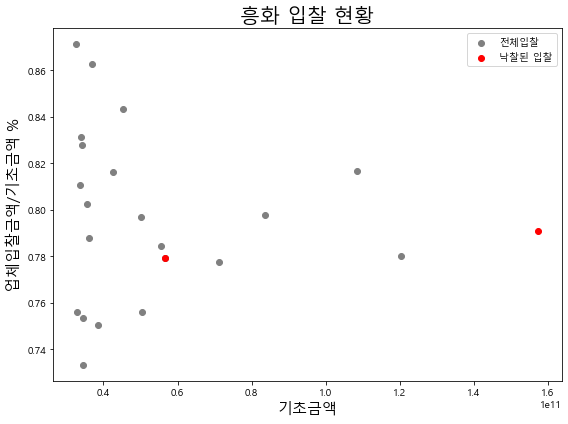

In [84]:
fig = plt.figure(figsize=(8,6))
tmp = df_com[df_com['업체명']=='흥화']
m1 = plt.scatter(x=tmp['기초금액'], y=tmp['입찰/기초'], color='grey', label='전체입찰')
m2 = plt.scatter(x = df_main[df_main['낙찰사']=='흥화']['기초금액'], y=df_main[df_main['낙찰사']=='흥화']['Unnamed: 19'], color='red', label='낙찰된 입찰')
plt.title('흥화 입찰 현황',fontsize=20)
plt.xlabel('기초금액',fontsize=15)
plt.ylabel('업체입찰금액/기초금액 %', fontsize=15)
plt.legend(handles=[m1,m2])
plt.tight_layout()
plt.savefig('fig4.png', dpi=1000)
plt.show()

In [ ]:
df_